In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.integrate as integrate
from scipy.stats import norm
from tqdm import tqdm
colors = plt.get_cmap('Set2').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
import math
from scipy import stats
import pandas as pd
from scipy.interpolate import interp1d
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import scipy.stats as st



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


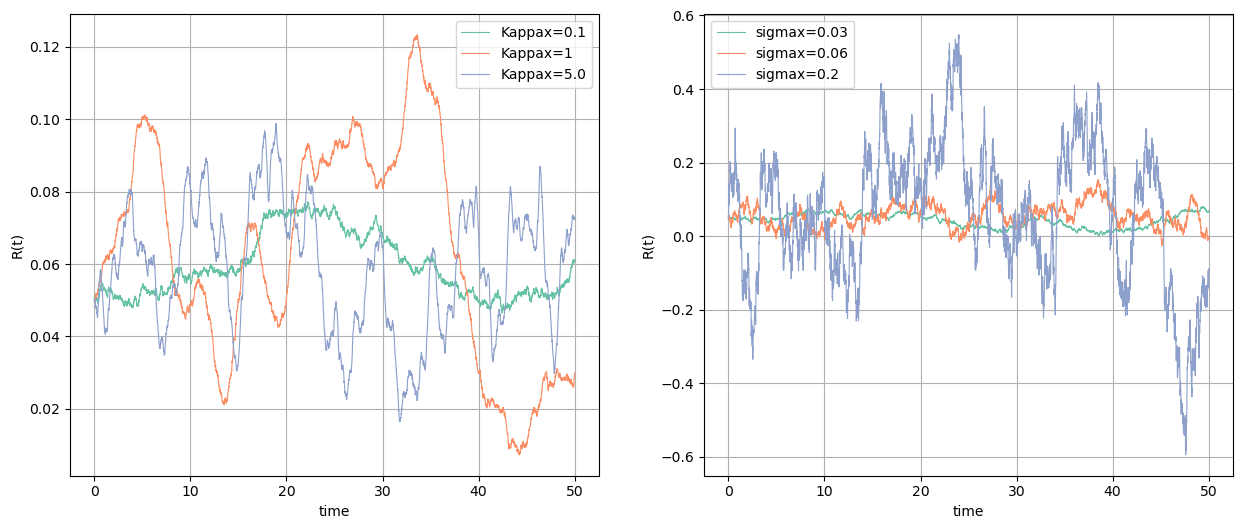

In [2]:
def generate_G2_paths(NbrPaths,NbrSteps,T,P0T,kappax,kappay,sigmax,sigmay,rho):
    dt = T / float(NbrSteps)
    forward = lambda t: -(np.log(P0T(t+dt)) - np.log(P0T(t -dt)))/(2*dt)
    r0 = forward(0.00001)
    phi = lambda t:  forward(t) + sigmax*sigmax / (2*kappax*kappax) *pow(1-np.exp(-kappax*t),2) + sigmay*sigmay / ( 2*kappay*kappay) * pow(1-np.exp(-kappay*t),2) + rho*sigmax*sigmay / (kappax*kappay) * (1-np.exp(-kappax*t))*(1-np.exp(-kappay*t))
    dt = T / float(NbrSteps)
    mean= [0,0]
    cov=[[1,rho],[rho,1]]
    R = np.zeros([NbrPaths, NbrSteps+1])
    x = np.zeros([NbrPaths, NbrSteps+1])
    y= np.zeros([NbrPaths, NbrSteps+1])
    R[:,0]=r0
    time = np.zeros([NbrSteps+1])
    for i in range(0,NbrSteps):
        Gaussian=np.random.multivariate_normal(mean,cov,NbrPaths)
        x[:,i+1]=x[:,i] * (1- kappax*dt) + sigmax * np.sqrt(dt) * Gaussian[:,0]
        y[:,i+1]=y[:,i] * (1-kappay*dt) +  sigmay *  np.sqrt(dt) * Gaussian[:,1]
        time[i+1] = time[i] +dt
        R[:,i+1] = x[:,i+1] + y[:,i+1]+ phi(time[i+1])
        
    # Outputs
    return time, R,x,y

                                                                       

def simulate_G2_Paths(NoOfPaths, NoOfSteps):
    T         = 50.0
    kappax     = 0.5
    kappay = 0.15
    sigmax=0.02
    sigmay = 0.02
    rho=-0.99
    
    np.random.seed(0) #for reproductibility
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 

    # Effect of mean reversion lambda
    fig, ax = plt.subplots(1, 2, figsize = (15, 6))
    legend = []
    KappaxVec = [0.1, 1, 5.0]
    for kappa in tqdm(KappaxVec):    
        time, R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,T,P0T, kappa,kappay,sigmax,sigmay,rho)
        legend.append('Kappax={0}'.format(kappa))
        ax[0].plot(time, np.transpose(R), linewidth = '0.8')  
        ax[0].set_xlabel("time")
        ax[0].set_ylabel("R(t)")
    ax[0].legend(legend)
    ax[0].grid()
    # Effect of the volatility
    legend = []
    sigmaxVec = [0.03, 0.06, 0.2]
    for sigma in tqdm(sigmaxVec):
        time, R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,T,P0T,kappax,kappay,sigma,sigmay,rho)
        legend.append('sigmax={0}'.format(sigma))
        ax[1].plot(time, np.transpose(R), linewidth = '0.8') 
        ax[1].set_xlabel("time")
        ax[1].set_ylabel("R(t)")
    ax[1].legend(legend)
    ax[1].grid()
    fig.savefig("G2++_model_parameters.png")
    plt.show()
simulate_G2_Paths (1, 5000)

In [3]:
NoOfPaths = 200
NoOfSteps = 1000
kappax     = 0.60
kappay = 0.15
sigmax=0.06
sigmay = 0.04
rho=-0.99
notional  = 10000.0 
hazard_rate = 0.01
# We define a ZCB curve (obtained from the market)
P0T = lambda T: np.exp(-0.01*T)
K = 0.01  # strike
Ti = 1.0  # begining of the swap
Tm = 10.0 # end date of the swap 
n = 10    # number of payments between Ti and Tm
T=10

time,R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,T,P0T,kappax,kappay,sigmax,sigmay,rho)

100%|████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:01<00:00, 1592.08it/s]


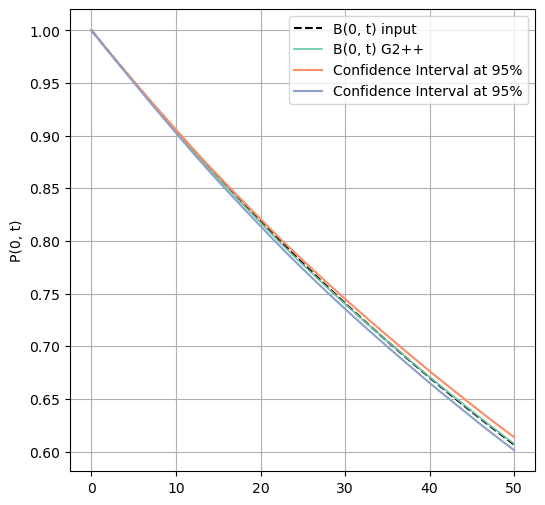

In [4]:
def ZCB_sanity_check(NoOfPaths, NoOfSteps):
    T         = 50
    kappax     = 0.12
    kappay = 0.3
    sigmax=0.02
    sigmay = 0.02
    rho=-0.9
    dt = T / float(NoOfSteps)
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.01*T) 
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))  
    time, R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,T,P0T,kappax,kappay,sigmax,sigmay,rho)
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    for i in tqdm(range(0, NoOfSteps)):
        #money saving account:  dM(t)=rM(t)dt is M(t)=M(t_0)exp(int_0^tr(t)dt)
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt) #Tripazoides method
    Pmdl=  np.zeros([NoOfSteps+1])
    PmdlSup= np.zeros([NoOfSteps+1])
    PmdlInf= np.zeros([NoOfSteps+1])
    for i in tqdm(range(0,NoOfSteps+1)):
        Pmdl[i] = np.mean(1.0/M[:,i])
        PmdlSup[i]=Pmdl[i] + 1.96 *np.std(1.0 / M[:,i]) / np.sqrt(NoOfPaths)
        PmdlInf[i]=Pmdl[i] - 1.96 *np.std(1.0 / M[:,i]) / np.sqrt(NoOfPaths)
    ax.plot(time,(P0T(time)),"--k", label = "B(0, t) input")
    ax.plot(time, Pmdl, linewidth = "1.2", label = "B(0, t) G2++")
    ax.plot(time, PmdlSup,  label = "Confidence Interval at 95%")
    ax.plot(time, PmdlInf,  label = "Confidence Interval at 95%")
    ax.set_ylabel("P(0, t)")
    ax.grid()
    plt.legend()
    plt.show()
    #fig.savefig("G2++_ZCB.png")
ZCB_sanity_check (20000, 2000)

In [5]:
def V(kappax,kappay,sigmax,sigmay,rho,T1,T2):
    facteur1=pow(sigmax,2)/pow(kappax,2)
    facteur2=pow(sigmay,2)/pow(kappay,2)
    kappa=kappax+kappay
    facteur3=(2*rho*sigmax*sigmay)/(kappax*kappay)
    
    first=facteur1*(T2-T1+ 2*np.exp(-kappax*(T2-T1))/(kappax)-(np.exp(-2*kappax*(T2-T1)))/(2*kappax)-3/(2*kappax))
    #print(first)
    second=facteur2*(T2-T1+ 2*np.exp(-kappay*(T2-T1))/(kappay)-(np.exp(-2*kappay*(T2-T1)))/(2*kappay)-3/(2*kappay))
    #print(second)
    third=facteur3*(T2-T1+(np.exp(-kappax*(T2-T1))-1)/(kappax)+(np.exp(-kappay*(T2-T1))-1)/(kappay)-(np.exp(-kappa*(T2-T1))-1)/(kappa))
    #print(third)
    return first+second+third


def G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,T1,T2,xT1,yT1):
    
    n = np.size(xT1) 
        
    if T1<T2:
        first_factor=P0T(T2) / P0T(T1)
        #first_factor=(-1/(T2-T1))  *np.log(P0T(T2)/P0T(T1))
        second_factor = 1/2 * (V(kappax,kappay,sigmax,sigmay,rho,T1,T2) -V(kappax,kappay,sigmax,sigmay,rho,0,T2) +V(kappax,kappay,sigmax,sigmay,rho,0,T1))
        third_factor= ((1-np.exp(-kappax*(T2-T1)))*xT1) / (kappax) + ((1-np.exp(-kappay*(T2-T1)))*yT1) / (kappay)
        return first_factor*np.exp(second_factor-third_factor)
    else:
        return 1

def G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    if np.size(prevTi)==0:
        return 0
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= 0 
    
    P_t_TiLambda = lambda Ti : G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,t,Ti,x_t,y_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==1: # Receiver
        swap = (P_t_Ti-P_t_Tm) - K*temp
    else:
        swap = K*temp - (P_t_Ti-P_t_Tm)
    
    return swap*notional


# A Revoir : 
#def G2_SwaptionPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
#    swap_price=G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho)
#    payoff=np.maximum(swap_price,0)
#    return np.mean(payoff)*np.exp(-



In [6]:
x_t=0
y_t=0
kappax     = 0.6
kappay = 0.15
sigmax=0.06
sigmay = 0.04
rho= - 0.99
K=0.01
Ti=1
Tm=10
notional=1000
n=20
t=9.99999999
CP=1

In [7]:
G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho)

-4.736841944751771

<h3> Update de la fonction Interpolator pour les ZCB G2++ : </h3>

On calcule pour chacun des tenors $T_k$ de $IM-SIMM$ $P(t,T_k)$

In [227]:
def G2_SwapPriceInterpolated(CP,notional,K,t,Ti,Tm,n,P0T,kappax,kappay,sigmax,sigmay,rho,YParams):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    #if np.size(prevTi) ==0:
    #    return 0
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(x_t));
    
    
    ISMMTenorsWeights={2/52 : 0.0109 , 1/12 : 0.0105 , 1/4 : 0.0090 , 1/2 : 0.0071 , 1 : 0.0066 , 2 : 0.0066
                       , 3: 0.0064 , 5 : 0.0060 , 10 : 0.0060 , 15 : 0.0061 ,20 : 0.0061 , 30 : 0.0067}
    
    Tenors = list(ISMMTenorsWeights.keys())                       
    # We will now interpolate the Yield Curve Function that we have. We have a function P_t_Ti
    interpolator = interp1d(Tenors,YParams,kind='linear',fill_value='extrapolate')
    

    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * np.exp(-(ti-t) * (interpolator(ti)))
            
    P_t_Ti = np.exp(-(Ti-t)*interpolator(Ti))
    P_t_Tm = np.exp(-(Tm-t) * interpolator(Tm))
    
    if CP==1:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    else:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional




# A Revoir : 
#def G2_SwaptionPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
#    swap_price=G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho)
#    payoff=np.maximum(swap_price,0)
#    return np.mean(payoff)*np.exp(-



Equations will be based on the following representation : 


- $ IM(t) = \sum_{k \in \mathcal{T}} S_{k}  Weights_{k}$ avec $\mathcal{T}=\lbrace 2 W , 1M , 3M , 6M , 1Y, 2Y ,3Y , 5Y, 10Y ,15Y, 20Y,30Y \rbrace $
- $DIM(t)=\mathbb{E}^{Q} [e^{-\int_{0}^{t} r_u du} IM(t) | \mathcal{F}_{0}]$
- $MVA=\int_{0}^{T} f(s) DIM(s) ds$
- $f(s)= ((1-R_B)\lambda_B(s) - s_I(s))e^{-\int_{t_{0}}^{s} \lambda_{B}(u) + \lambda_{C}(u) du}$

In [469]:
def NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NoOfPaths):
    
    NoOfSteps = 100
    ISMMTenorsWeights={2/52 : 0.0109 , 1/12 : 0.0105 , 1/4 : 0.0090 , 1/2 : 0.0071 , 1 : 0.0066 , 2 : 0.0066
                       , 3: 0.0064 , 5 : 0.0060 , 10 : 0.0060 , 15 : 0.0061 ,20 : 0.0061 , 30 : 0.0067}
    Tenors = list(ISMMTenorsWeights.keys())
    Weights =list(ISMMTenorsWeights.values())
    P0T = lambda T: np.exp(-r0*T) # Initial Curve ZCB

    # Model Parameters
    
    
    # Swap settings
    K = 0.01  # strike
    Ti1 = 1.0  # begining of the swap
    Tm1 = 6.0 # end date of the swap 
    Ti2 = 0
    Tm2 = 6
    Ti3 = 1.5
    Tm3 = 6
    Ti4 = 0.5
    Tm4 = 6
    Ti5 = 3
    Tm5 = 6
    n1 = 20
    n2 = 10
    n3 = 10
    n4  = 5
    n5  = 20# number of payments between Ti and Tm
    dt = Tm1 / NoOfSteps 
    
    
    
    IM = np.zeros([NoOfPaths,NoOfSteps + 1])
    ZCBArray= np.zeros([NoOfPaths,NoOfSteps + 1])
    DIM=np.zeros(NoOfSteps+1)
    notional  = 1000000.0 
 
    time, R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,Tm1,P0T,kappax,kappay,sigmax,sigmay,rho)
    for i in tqdm(range(0,NoOfSteps)):
        current_t = time[i]
        for j in range(NoOfPaths):
            current_R , current_X,current_Y= R[j,i] ,x[j,i],y[j,i]
            sensitivity=np.zeros(len(Tenors)) # Sensitivity of Len Tenors
            YParams=[]
            for k in range(len(Tenors)):
                current_tenor = Tenors[k]
                if current_t==current_tenor :
                    YParams.append(0.0)
                else:
                    ZCB = G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,current_t,current_tenor,current_X,current_Y) # Calculation of
                    YParams.append((-np.log(ZCB)) / (current_tenor - current_t))
            
            # We will now interpolate the Yield Curve Function that we have
            V1=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti1,Tm1,n1,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            V2=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti2,Tm2,n2,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            V3=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti3,Tm3,n3,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            V4=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti4,Tm4,n4,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            V5=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti5,Tm5,n5,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            # Defining the G2_Swap Price Here
            for k in range(len(Tenors)):
                VShift=YParams.copy() # Copy of the Actual Yield Curve 
                VShift[k] = VShift[k] + 0.0001 # Shock to the k-th Yield
                NewSwapPrice1 = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti1,Tm1,n1,P0T,kappax,kappay,sigmax,sigmay,rho,VShift) # ReEvaluation of Instrument
                NewSwapPrice2 = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti2,Tm2,n2,P0T,kappax,kappay,sigmax,sigmay,rho,VShift)     # ReEvaluation of Instrument
                NewSwapPrice3 = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti3,Tm3,n3,P0T,kappax,kappay,sigmax,sigmay,rho,VShift)     # ReEvaluation of Instrument
                NewSwapPrice4 = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti4,Tm4,n4,P0T,kappax,kappay,sigmax,sigmay,rho,VShift)     # ReEvaluation of Instrument
                NewSwapPrice5 = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti5,Tm5,n5,P0T,kappax,kappay,sigmax,sigmay,rho,VShift)     # ReEvaluation of Instrument
                #sensitivity[k] = (NewSwapPrice1 - V1) + (NewSwapPrice2 - V2) + (NewSwapPrice3 - V3) + (NewSwapPrice4 - V4) + (NewSwapPrice5 -V5)# Sensitivity of k-th Yield
                sensitivity[k]= (NewSwapPrice1 - V1) + (NewSwapPrice2 - V2) + (NewSwapPrice3 - V3) + (NewSwapPrice4 - V4) + (NewSwapPrice5 -V5)
                if current_t==time[-1]:
                    sensitivity[k]=0
            for k,weight in enumerate(Weights):
                IM[j,i]+=weight * sensitivity[k]
                

            IM[j,i]=IM[j,i] *np.exp(-sum(R[j,:i+1])*dt) 
            ZCBArray[j,i]= np.exp(-sum(R[j,:i+1])*dt) 
            
        
    DIM=np.mean(IM,axis=0) # Computation of Dynamic Initial Margin
        
    return IM, DIM,ZCBArray,time
                
               
def MVACalculation(DIM):
    
    N = len(DIM)
    
    # Parameters Setting
    
    Tm=6
    # Parameters
    
    dt = Tm / N
    RecoveryB=0.4
    lambdaB= 0.0167
    spreadI= 0
    lambdaC= 0 
    
    f = lambda  t : ((1-RecoveryB)*lambdaB - spreadI)*np.exp(-(lambdaB+lambdaC)*t)
    
    MVA=0 # Margin Valuation Adjustment
    
    for i in range(0,N):
        current_t = i * T / N
        MVA += f(current_t) * DIM[i] * dt
        
    return MVA
    
                
                
                
                        

            
            
            
    

In [280]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.6
r0=0.015

In [281]:
DIMNew

array([0.        , 3.58510507, 3.54044821, 3.57007872, 3.58241166,
       3.75927511, 3.67756755, 3.6151288 , 3.70042344, 3.76362545,
       3.80413898, 3.84521864, 2.971046  , 3.12965049, 3.18062592,
       3.10872678, 3.1782278 , 5.90655657, 5.88529936, 5.91530264,
       5.84794442, 5.72885892, 5.41989474, 4.95549712, 4.92359057,
       7.27220021, 6.9435586 , 6.7351493 , 6.88605453, 6.83011548,
       6.56091475, 6.59453745, 6.55625805, 6.26614299, 5.48606181,
       5.20284844, 5.33095337, 5.29911617, 5.20703356, 5.06183287,
       5.02140443, 4.9452038 , 4.70665361, 4.49471024, 4.60419594,
       4.28515395, 4.40639079, 4.44392537, 4.2416076 , 4.30560311,
       4.05857307, 4.17367509, 4.08177211, 4.0220704 , 4.06352558,
       4.06576076, 3.7186776 , 3.60897596, 3.5816565 , 3.36639418,
       3.36348822, 3.20437101, 3.19124869, 3.23894459, 3.24892041,
       3.16977702, 3.20068998, 2.59036374, 2.5914337 , 2.63080756,
       2.47641091, 2.46281041, 2.45833224, 2.47793267, 2.35303

In [408]:
kappax = 0.10
kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= - 0.6
r0=0.015
NbrPaths=1
IM,DIMNewTest,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.49it/s]


In [411]:
len(time)

101

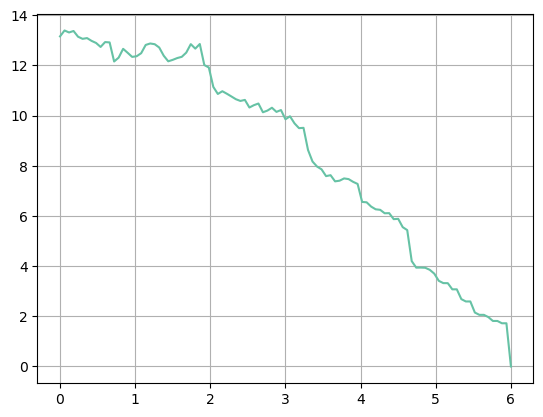

In [409]:
plt.plot(time,DIMNewTest)
plt.grid()

In [47]:
P0T = lambda T: np.exp(-0.01*T) # Initial Curve ZCB
timegrid=np.linspace(0,6,101)


In [48]:
G2_ZCBTest=[]
P0TTest=[]
for t in timegrid:
    G2_ZCBTest.append(G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,0,t,0,0))
    P0TTest.append(P0T(t))
    

In [548]:
MVA = MVACalculation(DIM)

In [549]:
print(" MVA = " + str(MVA))

 MVA = 0.3212292452840844


In [555]:
pd.DataFrame(pd.DataFrame(IM).iloc[:,49:60]).describe()

,49,50,51,52,53,54,55,56,57,58,59
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.760495,5.753149,5.182347,5.195810,5.189401,5.175604,5.185406,4.653804,4.661263,4.669390,4.651334
std,3.132306,3.132600,2.904389,2.998658,3.070107,3.056374,3.041103,2.840449,2.882413,2.885629,2.858405
min,0.907376,0.878572,0.745759,0.790483,0.735051,0.758406,0.764667,0.613908,0.644426,0.662771,0.784728
25%,3.619976,3.602995,3.218657,3.206321,3.199603,3.241261,3.199503,2.808332,2.832451,2.835747,2.780408
50%,5.150099,5.075084,4.532529,4.553406,4.485629,4.506352,4.478870,4.026961,4.038856,4.012269,3.987402
75%,7.078828,7.175604,6.457899,6.516564,6.407260,6.411144,6.416286,5.806949,5.797809,5.840565,5.906309
max,42.675725,42.661934,37.007028,42.541466,44.758292,43.470949,41.703109,39.811706,41.151991,42.337533,40.204243


<h3> Some Plots of DIM : </h3>

<h3> Noisy Labels with $N_{MC} = 1 $

In [ ]:
kappax = 0.10
kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= - 0.3
r0=0.03
NbrPaths=1000

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


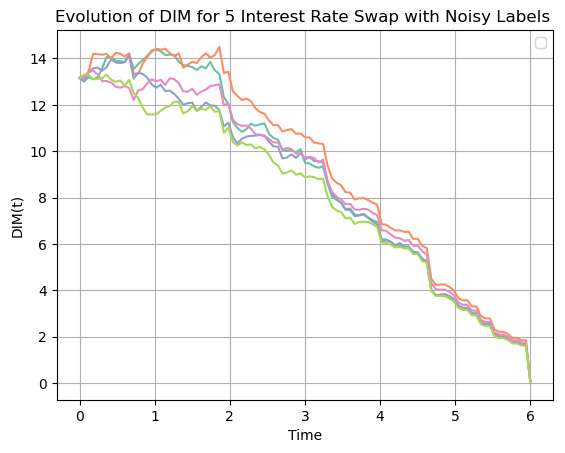

In [474]:
for _ in range(5):
    kappax = 0.10
    kappay = 0.12
    sigmax=0.015
    sigmay = 0.015
    rho= - 0.6
    r0=0.015
    IM,DIMNew,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,1)
    plt.plot(time,DIMNew)
    
#plt.plot(time,DIM2,label="Dynamic Initial Margin Setting 2 ")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("DIM(t)")
plt.title("Evolution of DIM for 5 Interest Rate Swap with Noisy Labels ")
plt.savefig("Noisy Labels of DIM for 5 Interest Rate Swap.png")

<h3> Labels with $N_{MC} = 1000 $ </h3>

In [ ]:
for _ in range(5):
    kappax = 0.4
    kappay = 0.3
    sigmax=0.03
    sigmay = 0.05
    rho= - 0.3
    IM,DIMNew,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho)
    plt.plot(time,DIMNew)
#plt.plot(time,DIM2,label="Dynamic Initial Margin Setting 2 ")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("DIM(t)")
plt.title("Evolution of DIM for an Interest Rate Swap")

<h3> DIM Deep Learning Approach : </h3>

Deep Learning Approach to compute $DIM$ and $MVA$ : 

We aim to approximate the DIM Values as follows :

\begin{equation}
\textbf{DIM}=(DIM_0,...,DIM_N)=(\mathbb{E}^{Q}[IM_0| X],...\mathbb{E}^{Q}[IM_N|X])
\end{equation}


Les Labels vont être les IM calculés en prenant le vecteur de paramètres correspondant 
For the Training Purposes, we need to train a function with outputs will be a function in dimension $\mathbb{R}^{160}$


<h5> NN Parameters : </h5>

- Num Inputs : 5
- Num Outputs : 160
- Num Hidden Layers : 3
- Num Units Per Layer : 256
- Activation Function : $ReLU$
- Weight Initialization : Glorot Uniform

In [289]:
import numpy as np
import torch
import torch.nn as nn

Defining the following parameters for the training dataset :

- $K_T = 10 000 * 0.8 = 8000 $ market state vectors for the training set 
- $K_V = 10 000 * 0.2 = 2000$ for the validation set
- $M_V = 10 000 $ paths for the ground truth estimations of the quantity $DIM$ as it's computationally too costly to go for more.

<h3> Defining Uniformly Random Parameters for Initialization of the Algorithm :  </h3>



In [4]:
Parameters={"Kx":0.072,
            "Ky": 0.089,
            "sigmax":0.015,
            "sigmay":0.015,
           "rho":-0.999,
           "r0" : 0.03}

df = pd.DataFrame(Parameters.items(), columns=['Parameter', 'Value'])

df["Min"]=df["Value"]-2/3*df["Value"]
df["Max"]=df["Value"]+2/3*df["Value"]
df["Min"][4]=-0.999
df["Max"][4]=0.999
df["Min"][5]=-0.03
df["Max"][5]=0.06

dataset=df.copy()


dataset=pd.DataFrame(columns=["Kx","Ky","sigmax","sigmay","rho","r0"])
dataset

for parameter in df["Parameter"]:
    min_value = df.loc[df["Parameter"] == parameter, "Min"].values[0]
    max_value = df.loc[df["Parameter"] == parameter, "Max"].values[0]
    dataset[parameter] = np.random.uniform(min_value, max_value, 100000)
    
dataset.index
dataset.describe()

import seaborn as sns

C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_8276\1335575939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Min"][4]=-0.999
C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_8276\1335575939.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Max"][4]=0.999
C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_8276\1335575939.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Min"][5]=-0.03
C:\Users\samy.mekk

In [5]:
DataParameters=dataset.copy()
DataParametersSemiSet=DataParameters.iloc[:10000,:]

In [292]:
DataParametersSemiSet #Generation of the DataSet which will be used for training.

,Kx,Ky,sigmax,sigmay,rho,r0
0,0.064066,0.107717,0.020404,0.021375,0.080095,0.026022
1,0.104511,0.036899,0.012894,0.015904,0.929068,0.011949
2,0.039628,0.050763,0.019029,0.016056,0.570407,0.057019
3,0.073892,0.091313,0.020408,0.018365,0.316240,-0.003563
4,0.044820,0.123183,0.015489,0.013047,-0.039239,-0.000045
...,...,...,...,...,...,...
9995,0.088827,0.087714,0.007233,0.005456,0.512528,-0.003548
9996,0.105245,0.035439,0.022010,0.007401,0.113079,0.026164
9997,0.110779,0.130139,0.016906,0.011459,-0.052167,0.050277
9998,0.061766,0.050356,0.005454,0.022312,0.421744,-0.023296


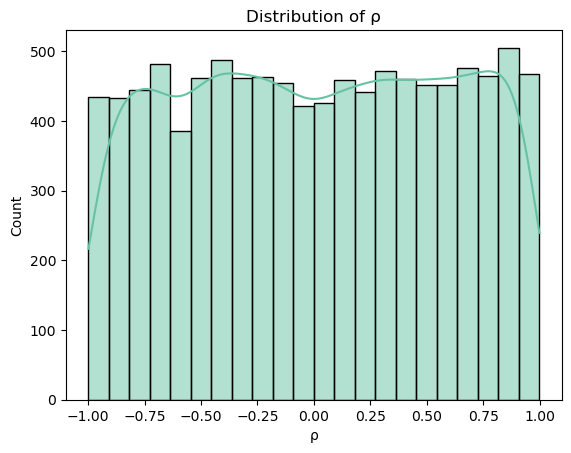

In [6]:
# Distribiution Plot

sns.histplot(DataParametersSemiSet['rho'], kde=True)
plt.xlabel("ρ")
plt.title("Distribution of ρ")
plt.savefig("Distributionofrho.png")

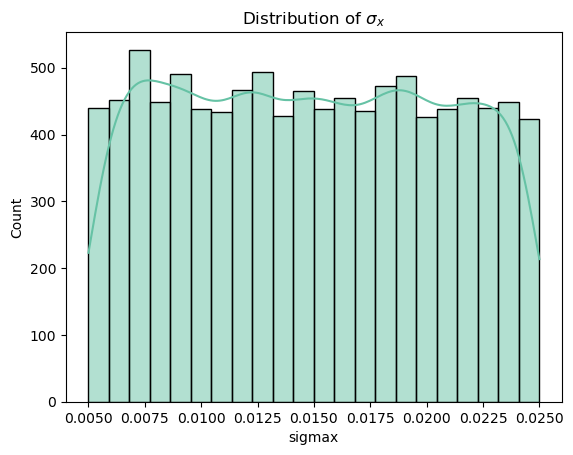

In [81]:
# Distribiution Plot

sns.histplot(DataParametersSemiSet['sigmax'], kde=True)
plt.title("Distribution of $σ_x$")
plt.savefig("Distributionofsigmax.png")

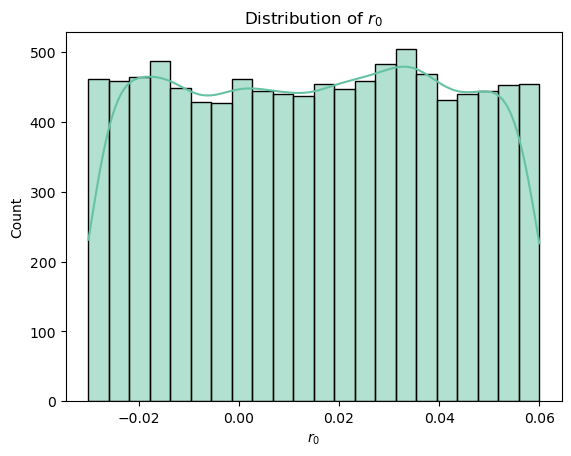

In [8]:
# Distribiution Plot

sns.histplot(DataParametersSemiSet['r0'], kde=True)
plt.xlabel("$r_0$")

plt.title("Distribution of $r_0$")
plt.savefig("Distributionofr0.png")

<h3> Generating the dataset :  </h3>

In [12]:
IM=pd.read_excel("DataIM.xlsx")

KeyboardInterrupt: 

In [413]:
NoOfSteps=100
Trainingset5Swaps=np.zeros([len(DataParametersSemiSet),NoOfSteps+1])
ZCset=np.zeros([len(DataParametersSemiSet),NoOfSteps+1])
for i in tqdm(range(len(DataParametersSemiSet))):
    kappax,kappay,sigmax,sigmay,rho,r0=DataParametersSemiSet["Kx"][i],DataParametersSemiSet["Ky"][i],DataParametersSemiSet["sigmax"][i],DataParametersSemiSet["sigmay"][i],DataParametersSemiSet["rho"][i],DataParametersSemiSet["r0"][i]
    IM,DIM,ZC,time=NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,1)
    Trainingset5Swaps[i,:]=DIM
    ZCset[i,:]=ZC

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [7:39:39<00:00,  2.76s/it]


In [469]:
#DataIM=pd.DataFrame(Trainingset)
#DataZC=pd.DataFrame(ZCset)

In [414]:
DataIM5swap = pd.DataFrame(Trainingset5Swaps)
DataIM5swap.to_excel("DataIM5swaps.xlsx",sheet_name="IM Values",index=False)


In [415]:
DataIM5swap

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,12.159189,11.495238,11.519284,11.080260,10.959589,11.136091,11.341202,10.981373,11.471138,11.773208,...,1.884886,1.551838,1.475635,1.466879,1.393288,1.277791,1.269706,1.198212,1.191037,0.0
1,13.448239,13.761270,13.215079,12.739312,12.750012,12.919516,13.197485,13.935153,14.244903,14.268769,...,2.160987,1.783863,1.699698,1.688821,1.603950,1.471316,1.462973,1.380814,1.371969,0.0
2,9.695412,11.328478,11.689061,10.929085,11.776637,11.452822,11.308306,11.595888,11.251784,11.401360,...,1.990598,1.647684,1.573208,1.568405,1.495707,1.377145,1.374966,1.303234,1.300415,0.0
3,15.008483,15.012758,14.726205,14.942205,15.309953,14.481805,13.811895,14.191870,13.889705,13.634360,...,2.408979,1.993313,1.903117,1.896719,1.806752,1.660905,1.655680,1.567737,1.563038,0.0
4,14.641029,14.505830,14.421116,13.555467,14.316875,13.965214,13.713843,13.692559,13.694827,13.940881,...,3.005814,2.498878,2.395690,2.397889,2.293132,2.118011,2.119649,2.014298,2.014979,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15.006815,15.251146,15.056061,14.999552,15.258752,14.955471,14.853261,14.850641,14.890012,15.011289,...,2.422601,2.009247,1.921791,1.919878,1.832418,1.688680,1.686949,1.600411,1.599146,0.0
9996,12.146818,12.229719,12.315024,12.233153,11.635789,11.575502,11.556834,11.951593,11.731392,11.650555,...,1.846884,1.522903,1.448251,1.439927,1.367274,1.253010,1.245309,1.174823,1.166612,0.0
9997,10.190738,9.767171,9.768268,10.351818,10.399615,10.417487,10.392104,10.476619,10.676707,10.586281,...,2.161316,1.788696,1.709203,1.706053,1.627163,1.498372,1.495416,1.417497,1.415005,0.0
9998,17.227121,17.261083,16.549480,16.528412,15.117590,15.608337,15.915771,16.148754,16.387801,16.355249,...,3.838212,3.199506,3.072443,3.082124,2.957012,2.740076,2.751043,2.624319,2.636625,0.0


In [104]:
DataZC.describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.994002e-01,0.998811,0.998226,0.997636,0.997042,0.996444,0.995876,0.995286,0.994681,0.993982,...,0.949394,0.948847,0.948347,0.947882,0.947437,0.946954,0.946496,0.946009,0.945474,0.944937
std,1.510659e-14,0.000992,0.002283,0.003846,0.005627,0.007568,0.009656,0.011886,0.014286,0.016782,...,0.432726,0.439490,0.446271,0.453208,0.460100,0.466975,0.473991,0.481102,0.488055,0.494913
min,9.994002e-01,0.994225,0.988442,0.982015,0.975291,0.968799,0.959576,0.950599,0.942181,0.930776,...,0.136639,0.131785,0.127232,0.122674,0.118300,0.113883,0.109609,0.105424,0.101333,0.097412
25%,9.994002e-01,0.998242,0.996963,0.995524,0.994111,0.992467,0.990481,0.988671,0.986368,0.984156,...,0.683368,0.679124,0.675841,0.671499,0.669110,0.663642,0.660680,0.655430,0.651449,0.646743
50%,9.994002e-01,0.998805,0.998266,0.997579,0.997018,0.996426,0.995747,0.995320,0.994752,0.993735,...,0.886791,0.885792,0.880972,0.878819,0.876288,0.869882,0.866053,0.861883,0.857098,0.853773
75%,9.994002e-01,0.999383,0.999455,0.999746,1.000172,1.000632,1.001416,1.002266,1.002853,1.003247,...,1.128915,1.127965,1.128053,1.128005,1.126384,1.123993,1.122306,1.121796,1.118901,1.116311
max,9.994002e-01,1.002847,1.009628,1.017053,1.023819,1.034440,1.043578,1.050556,1.058565,1.063559,...,4.137086,4.206125,4.271737,4.342876,4.408470,4.473050,4.536931,4.605221,4.674140,4.738854


In [474]:
#DataIM.to_excel("DataIM.xlsx",sheet_name="IM Values",index=False)
#DataParameters.to_excel("DataParameters.xlsx",sheet_name="DataParameters values",index=False)
#DataZC.to_excel("ZC.xlsx",sheet_name="ZC values",index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_excel'

In [477]:
#DataIM=pd.read_excel("DataIM.xlsx")
#DataParameters=pd.read_excel("DataParameters.xlsx")
#ZC=pd.read_excel("ZC.xlsx")

In [146]:
DataIM

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2.846406,2.786376,2.798880,2.822805,2.770428,2.736456,2.725901,2.751612,2.829050,2.789813,...,0.302746,0.302221,0.301675,0.301142,0.300556,0.299958,0.299344,0.298744,0.298159,0.297583
1,2.846406,2.795883,2.836733,2.842960,2.790105,2.753968,2.832589,2.864912,2.866228,2.890968,...,0.310125,0.309885,0.309466,0.308988,0.308556,0.308118,0.307679,0.307226,0.306778,0.306335
2,2.846406,2.860550,2.896318,3.064708,3.045453,3.003525,3.011894,2.976199,2.974567,3.052669,...,0.324687,0.324691,0.324660,0.324718,0.324602,0.324504,0.324328,0.324207,0.324099,0.323996
3,2.846406,2.741896,2.744091,2.692145,2.743923,2.742218,2.708856,2.710106,2.674062,2.671669,...,0.293512,0.293212,0.292816,0.292476,0.292144,0.291763,0.291364,0.290911,0.290418,0.289908
4,2.846406,2.881683,2.823905,2.804630,2.801557,2.801998,2.896814,2.826556,2.931392,2.895168,...,0.302762,0.301795,0.300847,0.300101,0.299157,0.298213,0.297193,0.296139,0.295141,0.294205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.846406,2.920799,2.909233,2.876240,2.946773,2.983232,3.069286,3.112165,3.060621,2.982356,...,0.300204,0.299487,0.298952,0.298151,0.297363,0.296525,0.295542,0.294665,0.293801,0.292915
9996,2.846406,2.777963,2.753664,2.805765,2.804513,2.726926,2.714528,2.727194,2.731968,2.792180,...,0.286079,0.285528,0.285057,0.284577,0.284116,0.283671,0.283146,0.282603,0.282005,0.281366
9997,2.846406,2.805394,2.807790,2.862791,2.839397,2.824754,2.783365,2.779739,2.782994,2.759140,...,0.338733,0.338626,0.338689,0.338564,0.338379,0.338191,0.338085,0.337991,0.337934,0.337863
9998,2.846406,2.704837,2.678312,2.741553,2.732975,2.563130,2.590866,2.518674,2.596248,2.593566,...,0.279070,0.278398,0.278043,0.277881,0.277450,0.277147,0.276836,0.276484,0.276095,0.275706


<h3> Data Visualisation  :  </h3>

In [147]:
DataIM.describe().loc[:,0:49]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.846406e+00,2.850452,2.854128,2.858415,2.861000,2.864485,2.868808,2.872480,2.875927,2.880332,...,2.262644,2.265993,2.269046,2.272185,2.275455,1.922662,1.925020,1.927670,1.929810,1.932098
std,6.140358e-13,0.067426,0.094107,0.112585,0.129026,0.142049,0.153380,0.163050,0.172344,0.181002,...,0.231141,0.231168,0.230760,0.229918,0.229471,0.215439,0.213942,0.212537,0.211400,0.210171
min,2.846406e+00,2.453746,2.393736,2.320383,2.200221,2.205803,2.242725,2.215850,2.133023,2.074337,...,1.379262,1.385549,1.383823,1.424451,1.424447,1.124391,1.157391,1.151318,1.143675,1.157828
25%,2.846406e+00,2.812023,2.800840,2.794284,2.786063,2.781219,2.778875,2.777954,2.776694,2.774245,...,2.125289,2.128846,2.130569,2.136679,2.141451,1.797224,1.800532,1.804196,1.807504,1.809708
50%,2.846406e+00,2.849384,2.852557,2.856880,2.858703,2.861164,2.863853,2.869223,2.872027,2.877045,...,2.252804,2.254016,2.257416,2.260825,2.264719,1.910738,1.912061,1.916378,1.918279,1.920390
75%,2.846406e+00,2.887330,2.905185,2.921076,2.933198,2.944348,2.953974,2.961240,2.972086,2.979340,...,2.383385,2.385324,2.388630,2.392314,2.394948,2.035343,2.036050,2.036671,2.039553,2.039586
max,2.846406e+00,3.255493,3.325524,3.332785,3.541799,3.658286,3.667194,3.800849,3.842974,3.945599,...,3.904596,3.839127,3.758371,3.758334,3.728885,3.362842,3.369340,3.281297,3.218287,3.270410


In [148]:
DataParameters.head(5)

,Kx,Ky,sigmax,sigmay,rho
0,0.073156,0.140349,0.011359,0.008740,-0.392287
1,0.048318,0.093084,0.017859,0.008171,-0.986177
2,0.050065,0.102856,0.024792,0.017529,-0.402616
3,0.072569,0.044852,0.005438,0.013690,-0.658266
4,0.068313,0.091618,0.006126,0.016456,-0.023750


In [149]:
# Execute this cell if you want to scale your data (Not Necessary in this case)

#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#DataParametersScaled=pd.DataFrame(scaler.fit_transform(DataParameters),columns=DataParameters.columns)
#DataIMScaled=pd.DataFrame(scaler.fit_transform(DataIM),columns=DataIM.columns)


#DataParametersSemiSetScaled = pd.DataFrame(scaler.fit_transform(DataParametersSemiSet),columns=DataParametersSemiSet.columns)
#DataIMScaled=pd.DataFrame(scaler.fit_transform(DataIM),columns=DataIM.columns)


In [372]:
DataIM1swap

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2.532970,2.545216,2.518242,2.524638,2.564511,2.642026,2.529425,2.619009,2.664650,2.526724,...,0.376268,0.250474,0.250066,0.249757,0.249525,0.124629,0.124508,0.124314,0.124085,0.0
1,2.803130,2.700144,2.690238,2.709420,2.784686,2.641818,2.798680,2.847501,2.709498,2.592370,...,0.483378,0.323484,0.323775,0.324235,0.324842,0.163081,0.163235,0.163330,0.163488,0.0
2,2.015109,2.006256,2.011360,2.149846,2.193182,2.163131,2.259259,2.064653,2.077150,1.949899,...,0.369069,0.245934,0.245465,0.245166,0.244831,0.122442,0.122361,0.122270,0.122202,0.0
3,3.129523,3.166653,3.190023,3.166141,3.310480,3.263935,3.209230,3.260701,3.174997,3.128734,...,0.475266,0.314288,0.312785,0.310984,0.309267,0.153398,0.152648,0.151831,0.151006,0.0
4,3.052709,2.949016,2.894516,2.923064,2.903976,2.848246,2.734627,2.823805,2.726846,2.654675,...,0.402155,0.267610,0.267120,0.266573,0.266105,0.132850,0.132635,0.132375,0.132100,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.129174,3.125632,3.106530,3.200730,3.190242,3.118502,3.076076,3.066997,3.093896,3.134639,...,0.479402,0.319759,0.319512,0.319214,0.318931,0.159487,0.159299,0.159114,0.158939,0.0
9996,2.530375,2.509311,2.492553,2.474354,2.463140,2.349322,2.350369,2.334153,2.418955,2.426788,...,0.330422,0.219419,0.218697,0.218159,0.217413,0.108402,0.108171,0.107928,0.107619,0.0
9997,2.119399,2.119880,2.163702,2.217672,2.196117,2.162586,2.139656,2.108385,2.068415,2.032546,...,0.328417,0.218089,0.217524,0.216937,0.216409,0.107973,0.107776,0.107578,0.107382,0.0
9998,3.592659,3.595297,3.515021,3.323008,3.490457,3.493622,3.487487,3.373627,3.297347,3.278726,...,0.587545,0.393217,0.393956,0.394571,0.395148,0.198469,0.198637,0.198970,0.199352,0.0


In [416]:
X = DataParametersSemiSet.copy()
#X= DataParameters.copy()
y = DataIM5swap.loc[:,].copy()
#y=DataIM.loc[:,1:].copy()

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset,DataLoader

# Diviser les données X et y en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir en tenseurs


# Afficher les tailles des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement X :", X_train.shape)
print("Taille de l'ensemble de test X :", X_test.shape)
print("Taille de l'ensemble d'entraînement y :", y_train.shape)
print("Taille de l'ensemble de test y :", y_test.shape)

Train_data=TensorDataset(X_train,y_train)
Test_data=TensorDataset(X_test,y_test)
batchsize=4096
train_loader=DataLoader(Train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(Test_data,batch_size=batchsize)

for X,y in test_loader:
    print(X.shape,y.shape)


Taille de l'ensemble d'entraînement X : torch.Size([8000, 6])
Taille de l'ensemble de test X : torch.Size([2000, 6])
Taille de l'ensemble d'entraînement y : torch.Size([8000, 101])
Taille de l'ensemble de test y : torch.Size([2000, 101])
torch.Size([2000, 6]) torch.Size([2000, 101])


In [417]:
class NeuralNet(torch.nn.Module):
    def __init__(self, d):
        super(NeuralNet, self).__init__()
        self.a1 = nn.Linear(d, 256) 
        self.relu = nn.ReLU()
        self.a2 = nn.Linear(256, 256)
        self.a3 = nn.Linear(256,256)
        self.a4 = nn.Linear(256, 101) 
        
        self.dropout=nn.Dropout(p=0.25)
        
        nn.init.xavier_uniform_(self.a1.weight)
        nn.init.zeros_(self.a1.bias)
        nn.init.xavier_uniform_(self.a2.weight)
        nn.init.zeros_(self.a2.bias)
        nn.init.xavier_uniform_(self.a3.weight)
        nn.init.zeros_(self.a3.bias)
        nn.init.xavier_uniform_(self.a4.weight)
        nn.init.zeros_(self.a4.bias)
        
    
    def forward(self, x):
        out = self.a1(x)
        out = self.relu(out)
        out = self.a2(out)
        out = self.relu(out)
        out = self.a2(out)
        out = self.relu(out)
        out = self.a3(out)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.a4(out)
        
        return out
    
    


In [375]:
# Instanciation du modèle
modele = NeuralNet(d=6)

# Affichage de la structure du modèle
print(modele)

#X,y=next(iter(train_loader))
#yHat=modele(X)
lossfun=nn.MSELoss()
# lossfun(yHat,y)

NeuralNet(
  (a1): Linear(in_features=6, out_features=256, bias=True)
  (relu): ReLU()
  (a2): Linear(in_features=256, out_features=256, bias=True)
  (a3): Linear(in_features=256, out_features=256, bias=True)
  (a4): Linear(in_features=256, out_features=101, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


<h3> Model Training for Calculation of MVA :  </h3>

In [418]:
net=NeuralNet(d=6)
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)
lossfun=nn.MSELoss()


# num epochs
numepochs=1000

# Initialize losses and accuracies

trainLoss=torch.zeros(numepochs)
testLoss=torch.zeros(numepochs)
MAETrainLoss=torch.zeros(numepochs)
MAETestLoss=torch.zeros(numepochs)
trainAcc=torch.zeros(numepochs)
testAcc=torch.zeros(numepochs)


for epoch in tqdm(range(numepochs)):
    batchLoss=[]
    
    for X,y in train_loader:
        yHat=net(X)
        loss=lossfun(yHat,y)  
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batchLoss.append(loss.item())
    trainLoss[epoch]=np.mean(batchLoss)
    MAETrainLoss[epoch] = nn.L1Loss(reduction="mean")(yHat,y)
    X,y=next(iter(test_loader))
    yHat=net(X)
    loss=lossfun(yHat,y)
    testLoss[epoch]=loss.item()
    MAETestLoss[epoch] = nn.L1Loss(reduction="mean")(yHat,y)
    print("Epoch n°  " + str(epoch))
    print("MSE on the Train loss" + str(trainLoss[epoch]))
    print("MAE on the Train Loss" + str(MAETrainLoss[epoch]))
    print("MSE on the Test Loss " + str(testLoss[epoch]))
    print("MAE on the Test Loss" + str(MAETestLoss[epoch]))



  0%|▏                                                                                | 2/1000 [00:00<02:38,  6.31it/s]

Epoch n°  0
MSE on the Train losstensor(95.5163)
MAE on the Train Losstensor(8.6583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(95.0730)
MAE on the Test Losstensor(8.6459, grad_fn=<SelectBackward0>)
Epoch n°  1
MSE on the Train losstensor(95.5993)
MAE on the Train Losstensor(8.6606, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(94.8781)
MAE on the Test Losstensor(8.6363, grad_fn=<SelectBackward0>)


  0%|▎                                                                                | 4/1000 [00:01<04:34,  3.63it/s]

Epoch n°  2
MSE on the Train losstensor(94.5523)
MAE on the Train Losstensor(8.6145, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(94.6221)
MAE on the Test Losstensor(8.6236, grad_fn=<SelectBackward0>)
Epoch n°  3
MSE on the Train losstensor(94.4457)
MAE on the Train Losstensor(8.6038, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(94.2716)
MAE on the Test Losstensor(8.6059, grad_fn=<SelectBackward0>)


  1%|▍                                                                                | 6/1000 [00:01<03:10,  5.22it/s]

Epoch n°  4
MSE on the Train losstensor(94.2467)
MAE on the Train Losstensor(8.5998, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(93.7848)
MAE on the Test Losstensor(8.5809, grad_fn=<SelectBackward0>)
Epoch n°  5
MSE on the Train losstensor(93.1737)
MAE on the Train Losstensor(8.5470, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(93.1127)
MAE on the Test Losstensor(8.5460, grad_fn=<SelectBackward0>)


  1%|▋                                                                                | 8/1000 [00:01<02:22,  6.97it/s]

Epoch n°  6
MSE on the Train losstensor(92.8875)
MAE on the Train Losstensor(8.5225, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(92.1909)
MAE on the Test Losstensor(8.4974, grad_fn=<SelectBackward0>)
Epoch n°  7
MSE on the Train losstensor(92.9111)
MAE on the Train Losstensor(8.5195, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(90.9355)
MAE on the Test Losstensor(8.4301, grad_fn=<SelectBackward0>)


  1%|▊                                                                               | 10/1000 [00:01<02:31,  6.54it/s]

Epoch n°  8
MSE on the Train losstensor(91.1834)
MAE on the Train Losstensor(8.4275, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(89.2464)
MAE on the Test Losstensor(8.3378, grad_fn=<SelectBackward0>)
Epoch n°  9
MSE on the Train losstensor(89.6169)
MAE on the Train Losstensor(8.3489, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(87.0061)
MAE on the Test Losstensor(8.2131, grad_fn=<SelectBackward0>)
Epoch n°  10
MSE on the Train losstensor(87.4313)
MAE on the Train Losstensor(8.2249, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(84.0786)
MAE on the Test Losstensor(8.0457, grad_fn=<SelectBackward0>)


  1%|█                                                                               | 13/1000 [00:02<03:19,  4.96it/s]

Epoch n°  11
MSE on the Train losstensor(84.2971)
MAE on the Train Losstensor(8.0470, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(80.3002)
MAE on the Test Losstensor(7.8228, grad_fn=<SelectBackward0>)
Epoch n°  12
MSE on the Train losstensor(80.7593)
MAE on the Train Losstensor(7.8288, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(75.5243)
MAE on the Test Losstensor(7.5326, grad_fn=<SelectBackward0>)


  2%|█▏                                                                              | 15/1000 [00:02<02:40,  6.14it/s]

Epoch n°  13
MSE on the Train losstensor(75.7260)
MAE on the Train Losstensor(7.5330, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(69.6087)
MAE on the Test Losstensor(7.1665, grad_fn=<SelectBackward0>)
Epoch n°  14
MSE on the Train losstensor(69.3272)
MAE on the Train Losstensor(7.1434, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(62.4708)
MAE on the Test Losstensor(6.7191, grad_fn=<SelectBackward0>)


  2%|█▎                                                                              | 16/1000 [00:03<03:17,  4.99it/s]

Epoch n°  15
MSE on the Train losstensor(63.3059)
MAE on the Train Losstensor(6.7485, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(54.1412)
MAE on the Test Losstensor(6.1795, grad_fn=<SelectBackward0>)
Epoch n°  16
MSE on the Train losstensor(53.8165)
MAE on the Train Losstensor(6.1447, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(44.8590)
MAE on the Test Losstensor(5.5413, grad_fn=<SelectBackward0>)


  2%|█▌                                                                              | 19/1000 [00:03<02:30,  6.52it/s]

Epoch n°  17
MSE on the Train losstensor(45.4749)
MAE on the Train Losstensor(5.5642, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(35.2395)
MAE on the Test Losstensor(4.8245, grad_fn=<SelectBackward0>)
Epoch n°  18
MSE on the Train losstensor(35.2753)
MAE on the Train Losstensor(4.8122, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(26.5207)
MAE on the Test Losstensor(4.1241, grad_fn=<SelectBackward0>)


  2%|█▋                                                                              | 21/1000 [00:03<02:12,  7.38it/s]

Epoch n°  19
MSE on the Train losstensor(26.7179)
MAE on the Train Losstensor(4.1324, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(20.8055)
MAE on the Test Losstensor(3.6619, grad_fn=<SelectBackward0>)
Epoch n°  20
MSE on the Train losstensor(21.6190)
MAE on the Train Losstensor(3.7248, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(20.5878)
MAE on the Test Losstensor(3.6643, grad_fn=<SelectBackward0>)


  2%|█▊                                                                              | 23/1000 [00:03<02:05,  7.78it/s]

Epoch n°  21
MSE on the Train losstensor(20.8686)
MAE on the Train Losstensor(3.6767, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(24.9441)
MAE on the Test Losstensor(4.0030, grad_fn=<SelectBackward0>)
Epoch n°  22
MSE on the Train losstensor(25.2696)
MAE on the Train Losstensor(4.0154, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(27.5299)
MAE on the Test Losstensor(4.1908, grad_fn=<SelectBackward0>)


  2%|██                                                                              | 25/1000 [00:04<02:04,  7.83it/s]

Epoch n°  23
MSE on the Train losstensor(28.0825)
MAE on the Train Losstensor(4.2074, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(25.2267)
MAE on the Test Losstensor(4.0013, grad_fn=<SelectBackward0>)
Epoch n°  24
MSE on the Train losstensor(25.6553)
MAE on the Train Losstensor(4.0146, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(20.0051)
MAE on the Test Losstensor(3.5502, grad_fn=<SelectBackward0>)


  3%|██▏                                                                             | 27/1000 [00:04<02:00,  8.08it/s]

Epoch n°  25
MSE on the Train losstensor(20.3928)
MAE on the Train Losstensor(3.5612, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(14.8245)
MAE on the Test Losstensor(3.0413, grad_fn=<SelectBackward0>)
Epoch n°  26
MSE on the Train losstensor(15.4439)
MAE on the Train Losstensor(3.0789, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(11.3817)
MAE on the Test Losstensor(2.6361, grad_fn=<SelectBackward0>)


  3%|██▎                                                                             | 29/1000 [00:05<06:03,  2.67it/s]

Epoch n°  27
MSE on the Train losstensor(11.8708)
MAE on the Train Losstensor(2.6660, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(9.9922)
MAE on the Test Losstensor(2.4149, grad_fn=<SelectBackward0>)
Epoch n°  28
MSE on the Train losstensor(10.3730)
MAE on the Train Losstensor(2.4498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(10.0527)
MAE on the Test Losstensor(2.3683, grad_fn=<SelectBackward0>)


  3%|██▍                                                                             | 31/1000 [00:06<03:54,  4.12it/s]

Epoch n°  29
MSE on the Train losstensor(10.3517)
MAE on the Train Losstensor(2.3991, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(10.7424)
MAE on the Test Losstensor(2.4299, grad_fn=<SelectBackward0>)
Epoch n°  30
MSE on the Train losstensor(11.0480)
MAE on the Train Losstensor(2.4713, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(11.4105)
MAE on the Test Losstensor(2.5176, grad_fn=<SelectBackward0>)


  3%|██▋                                                                             | 33/1000 [00:06<02:53,  5.57it/s]

Epoch n°  31
MSE on the Train losstensor(11.6965)
MAE on the Train Losstensor(2.5549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(11.6774)
MAE on the Test Losstensor(2.5710, grad_fn=<SelectBackward0>)
Epoch n°  32
MSE on the Train losstensor(12.2350)
MAE on the Train Losstensor(2.6437, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(11.4055)
MAE on the Test Losstensor(2.5621, grad_fn=<SelectBackward0>)


  4%|██▊                                                                             | 35/1000 [00:06<02:23,  6.75it/s]

Epoch n°  33
MSE on the Train losstensor(11.7867)
MAE on the Train Losstensor(2.6184, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(10.6684)
MAE on the Test Losstensor(2.4939, grad_fn=<SelectBackward0>)
Epoch n°  34
MSE on the Train losstensor(11.2856)
MAE on the Train Losstensor(2.5731, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(9.6439)
MAE on the Test Losstensor(2.3847, grad_fn=<SelectBackward0>)


  4%|██▉                                                                             | 37/1000 [00:06<02:05,  7.65it/s]

Epoch n°  35
MSE on the Train losstensor(10.0779)
MAE on the Train Losstensor(2.4408, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(8.6018)
MAE on the Test Losstensor(2.2659, grad_fn=<SelectBackward0>)
Epoch n°  36
MSE on the Train losstensor(8.5835)
MAE on the Train Losstensor(2.2651, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(7.8339)
MAE on the Test Losstensor(2.1743, grad_fn=<SelectBackward0>)


  4%|███                                                                             | 39/1000 [00:07<02:00,  8.00it/s]

Epoch n°  37
MSE on the Train losstensor(7.9028)
MAE on the Train Losstensor(2.1732, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(7.5370)
MAE on the Test Losstensor(2.1346, grad_fn=<SelectBackward0>)
Epoch n°  38
MSE on the Train losstensor(7.8580)
MAE on the Train Losstensor(2.1579, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(7.7240)
MAE on the Test Losstensor(2.1468, grad_fn=<SelectBackward0>)


  4%|███▏                                                                            | 40/1000 [00:07<02:01,  7.93it/s]

Epoch n°  39
MSE on the Train losstensor(7.9989)
MAE on the Train Losstensor(2.1566, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(8.1482)
MAE on the Test Losstensor(2.1838, grad_fn=<SelectBackward0>)


  4%|███▎                                                                            | 42/1000 [00:07<02:46,  5.75it/s]

Epoch n°  40
MSE on the Train losstensor(8.5272)
MAE on the Train Losstensor(2.2132, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(8.4307)
MAE on the Test Losstensor(2.2058, grad_fn=<SelectBackward0>)
Epoch n°  41
MSE on the Train losstensor(8.7470)
MAE on the Train Losstensor(2.2180, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(8.3092)
MAE on the Test Losstensor(2.1847, grad_fn=<SelectBackward0>)


  4%|███▌                                                                            | 44/1000 [00:07<02:13,  7.15it/s]

Epoch n°  42
MSE on the Train losstensor(8.6910)
MAE on the Train Losstensor(2.2028, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(7.7655)
MAE on the Test Losstensor(2.1163, grad_fn=<SelectBackward0>)
Epoch n°  43
MSE on the Train losstensor(7.9938)
MAE on the Train Losstensor(2.1200, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(7.0312)
MAE on the Test Losstensor(2.0222, grad_fn=<SelectBackward0>)


  5%|███▋                                                                            | 46/1000 [00:08<02:04,  7.65it/s]

Epoch n°  44
MSE on the Train losstensor(7.3337)
MAE on the Train Losstensor(2.0332, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(6.3809)
MAE on the Test Losstensor(1.9327, grad_fn=<SelectBackward0>)
Epoch n°  45
MSE on the Train losstensor(6.6270)
MAE on the Train Losstensor(1.9417, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.9898)
MAE on the Test Losstensor(1.8705, grad_fn=<SelectBackward0>)


  5%|███▊                                                                            | 48/1000 [00:08<01:56,  8.17it/s]

Epoch n°  46
MSE on the Train losstensor(6.1542)
MAE on the Train Losstensor(1.8722, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.8627)
MAE on the Test Losstensor(1.8404, grad_fn=<SelectBackward0>)
Epoch n°  47
MSE on the Train losstensor(6.1495)
MAE on the Train Losstensor(1.8715, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.8847)
MAE on the Test Losstensor(1.8302, grad_fn=<SelectBackward0>)


  5%|████                                                                            | 50/1000 [00:08<01:57,  8.07it/s]

Epoch n°  48
MSE on the Train losstensor(6.0926)
MAE on the Train Losstensor(1.8528, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.9127)
MAE on the Test Losstensor(1.8211, grad_fn=<SelectBackward0>)
Epoch n°  49
MSE on the Train losstensor(6.1930)
MAE on the Train Losstensor(1.8566, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.8450)
MAE on the Test Losstensor(1.7990, grad_fn=<SelectBackward0>)


  5%|████▏                                                                           | 53/1000 [00:08<01:45,  8.99it/s]

Epoch n°  50
MSE on the Train losstensor(6.2034)
MAE on the Train Losstensor(1.8449, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.6355)
MAE on the Test Losstensor(1.7575, grad_fn=<SelectBackward0>)
Epoch n°  51
MSE on the Train losstensor(5.7489)
MAE on the Train Losstensor(1.7660, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.3309)
MAE on the Test Losstensor(1.7049, grad_fn=<SelectBackward0>)
Epoch n°  52
MSE on the Train losstensor(5.5921)
MAE on the Train Losstensor(1.7400, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(5.0060)
MAE on the Test Losstensor(1.6528, grad_fn=<SelectBackward0>)


  6%|████▍                                                                           | 55/1000 [00:09<02:25,  6.47it/s]

Epoch n°  53
MSE on the Train losstensor(5.2137)
MAE on the Train Losstensor(1.6689, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.7513)
MAE on the Test Losstensor(1.6156, grad_fn=<SelectBackward0>)
Epoch n°  54
MSE on the Train losstensor(4.9878)
MAE on the Train Losstensor(1.6382, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.6204)
MAE on the Test Losstensor(1.6012, grad_fn=<SelectBackward0>)


  6%|████▌                                                                           | 57/1000 [00:09<02:07,  7.42it/s]

Epoch n°  55
MSE on the Train losstensor(4.8731)
MAE on the Train Losstensor(1.6287, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.6036)
MAE on the Test Losstensor(1.6059, grad_fn=<SelectBackward0>)
Epoch n°  56
MSE on the Train losstensor(4.8948)
MAE on the Train Losstensor(1.6299, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.6356)
MAE on the Test Losstensor(1.6173, grad_fn=<SelectBackward0>)


  6%|████▋                                                                           | 59/1000 [00:09<01:57,  7.99it/s]

Epoch n°  57
MSE on the Train losstensor(4.8439)
MAE on the Train Losstensor(1.6280, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.6329)
MAE on the Test Losstensor(1.6205, grad_fn=<SelectBackward0>)
Epoch n°  58
MSE on the Train losstensor(4.8363)
MAE on the Train Losstensor(1.6345, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.5520)
MAE on the Test Losstensor(1.6073, grad_fn=<SelectBackward0>)


  6%|████▉                                                                           | 61/1000 [00:10<01:54,  8.22it/s]

Epoch n°  59
MSE on the Train losstensor(4.8250)
MAE on the Train Losstensor(1.6272, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.4033)
MAE on the Test Losstensor(1.5787, grad_fn=<SelectBackward0>)
Epoch n°  60
MSE on the Train losstensor(4.6941)
MAE on the Train Losstensor(1.6157, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.2388)
MAE on the Test Losstensor(1.5431, grad_fn=<SelectBackward0>)


  6%|█████                                                                           | 63/1000 [00:10<02:09,  7.21it/s]

Epoch n°  61
MSE on the Train losstensor(4.4385)
MAE on the Train Losstensor(1.5598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.1166)
MAE on the Test Losstensor(1.5118, grad_fn=<SelectBackward0>)
Epoch n°  62
MSE on the Train losstensor(4.2566)
MAE on the Train Losstensor(1.5212, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.0585)
MAE on the Test Losstensor(1.4909, grad_fn=<SelectBackward0>)


  6%|█████▏                                                                          | 65/1000 [00:10<01:58,  7.87it/s]

Epoch n°  63
MSE on the Train losstensor(4.4000)
MAE on the Train Losstensor(1.5436, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.0473)
MAE on the Test Losstensor(1.4792, grad_fn=<SelectBackward0>)
Epoch n°  64
MSE on the Train losstensor(4.2267)
MAE on the Train Losstensor(1.5007, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.0473)
MAE on the Test Losstensor(1.4720, grad_fn=<SelectBackward0>)


  7%|█████▎                                                                          | 67/1000 [00:11<02:49,  5.51it/s]

Epoch n°  65
MSE on the Train losstensor(4.2925)
MAE on the Train Losstensor(1.5023, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(4.0203)
MAE on the Test Losstensor(1.4641, grad_fn=<SelectBackward0>)
Epoch n°  66
MSE on the Train losstensor(4.1443)
MAE on the Train Losstensor(1.4745, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.9592)
MAE on the Test Losstensor(1.4536, grad_fn=<SelectBackward0>)


  7%|█████▌                                                                          | 69/1000 [00:11<02:17,  6.79it/s]

Epoch n°  67
MSE on the Train losstensor(4.0676)
MAE on the Train Losstensor(1.4702, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.8740)
MAE on the Test Losstensor(1.4417, grad_fn=<SelectBackward0>)
Epoch n°  68
MSE on the Train losstensor(4.1014)
MAE on the Train Losstensor(1.4743, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.7862)
MAE on the Test Losstensor(1.4313, grad_fn=<SelectBackward0>)


  7%|█████▋                                                                          | 71/1000 [00:11<02:00,  7.70it/s]

Epoch n°  69
MSE on the Train losstensor(3.9958)
MAE on the Train Losstensor(1.4578, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.7164)
MAE on the Test Losstensor(1.4252, grad_fn=<SelectBackward0>)
Epoch n°  70
MSE on the Train losstensor(3.8930)
MAE on the Train Losstensor(1.4388, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.6743)
MAE on the Test Losstensor(1.4234, grad_fn=<SelectBackward0>)


  7%|█████▊                                                                          | 73/1000 [00:11<02:06,  7.36it/s]

Epoch n°  71
MSE on the Train losstensor(3.9517)
MAE on the Train Losstensor(1.4545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.6541)
MAE on the Test Losstensor(1.4245, grad_fn=<SelectBackward0>)
Epoch n°  72
MSE on the Train losstensor(3.8991)
MAE on the Train Losstensor(1.4525, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.6406)
MAE on the Test Losstensor(1.4247, grad_fn=<SelectBackward0>)


  8%|██████                                                                          | 76/1000 [00:12<01:45,  8.74it/s]

Epoch n°  73
MSE on the Train losstensor(3.7146)
MAE on the Train Losstensor(1.4256, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.6136)
MAE on the Test Losstensor(1.4199, grad_fn=<SelectBackward0>)
Epoch n°  74
MSE on the Train losstensor(3.7744)
MAE on the Train Losstensor(1.4347, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.5673)
MAE on the Test Losstensor(1.4091, grad_fn=<SelectBackward0>)
Epoch n°  75
MSE on the Train losstensor(3.6209)
MAE on the Train Losstensor(1.4093, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.5132)
MAE on the Test Losstensor(1.3952, grad_fn=<SelectBackward0>)


  8%|██████▏                                                                         | 77/1000 [00:12<01:49,  8.46it/s]

Epoch n°  76
MSE on the Train losstensor(3.6958)
MAE on the Train Losstensor(1.4150, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.4650)
MAE on the Test Losstensor(1.3811, grad_fn=<SelectBackward0>)


  8%|██████▏                                                                         | 78/1000 [00:12<02:35,  5.93it/s]

Epoch n°  77
MSE on the Train losstensor(3.6600)
MAE on the Train Losstensor(1.4082, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.4322)
MAE on the Test Losstensor(1.3693, grad_fn=<SelectBackward0>)
Epoch n°  78
MSE on the Train losstensor(3.5685)
MAE on the Train Losstensor(1.3757, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.4137)
MAE on the Test Losstensor(1.3608, grad_fn=<SelectBackward0>)


  8%|██████▍                                                                         | 81/1000 [00:13<02:08,  7.16it/s]

Epoch n°  79
MSE on the Train losstensor(3.7003)
MAE on the Train Losstensor(1.4077, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.3992)
MAE on the Test Losstensor(1.3544, grad_fn=<SelectBackward0>)
Epoch n°  80
MSE on the Train losstensor(3.4907)
MAE on the Train Losstensor(1.3582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.3785)
MAE on the Test Losstensor(1.3487, grad_fn=<SelectBackward0>)


  8%|██████▋                                                                         | 84/1000 [00:13<01:51,  8.25it/s]

Epoch n°  81
MSE on the Train losstensor(3.4761)
MAE on the Train Losstensor(1.3540, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.3478)
MAE on the Test Losstensor(1.3429, grad_fn=<SelectBackward0>)
Epoch n°  82
MSE on the Train losstensor(3.4691)
MAE on the Train Losstensor(1.3476, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.3117)
MAE on the Test Losstensor(1.3372, grad_fn=<SelectBackward0>)
Epoch n°  83
MSE on the Train losstensor(3.4514)
MAE on the Train Losstensor(1.3548, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.2737)
MAE on the Test Losstensor(1.3325, grad_fn=<SelectBackward0>)


  9%|██████▉                                                                         | 86/1000 [00:13<01:50,  8.27it/s]

Epoch n°  84
MSE on the Train losstensor(3.4366)
MAE on the Train Losstensor(1.3494, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.2425)
MAE on the Test Losstensor(1.3293, grad_fn=<SelectBackward0>)
Epoch n°  85
MSE on the Train losstensor(3.4947)
MAE on the Train Losstensor(1.3577, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.2193)
MAE on the Test Losstensor(1.3274, grad_fn=<SelectBackward0>)


  9%|███████                                                                         | 88/1000 [00:13<01:46,  8.54it/s]

Epoch n°  86
MSE on the Train losstensor(3.4313)
MAE on the Train Losstensor(1.3495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.2019)
MAE on the Test Losstensor(1.3261, grad_fn=<SelectBackward0>)
Epoch n°  87
MSE on the Train losstensor(3.4066)
MAE on the Train Losstensor(1.3539, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.1848)
MAE on the Test Losstensor(1.3238, grad_fn=<SelectBackward0>)


  9%|███████▏                                                                        | 90/1000 [00:14<01:43,  8.77it/s]

Epoch n°  88
MSE on the Train losstensor(3.3849)
MAE on the Train Losstensor(1.3526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.1616)
MAE on the Test Losstensor(1.3187, grad_fn=<SelectBackward0>)
Epoch n°  89
MSE on the Train losstensor(3.3208)
MAE on the Train Losstensor(1.3362, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.1343)
MAE on the Test Losstensor(1.3114, grad_fn=<SelectBackward0>)


  9%|███████▎                                                                        | 92/1000 [00:14<02:19,  6.51it/s]

Epoch n°  90
MSE on the Train losstensor(3.2593)
MAE on the Train Losstensor(1.3272, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.1073)
MAE on the Test Losstensor(1.3032, grad_fn=<SelectBackward0>)
Epoch n°  91
MSE on the Train losstensor(3.2395)
MAE on the Train Losstensor(1.3184, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.0853)
MAE on the Test Losstensor(1.2958, grad_fn=<SelectBackward0>)


  9%|███████▌                                                                        | 94/1000 [00:14<01:57,  7.74it/s]

Epoch n°  92
MSE on the Train losstensor(3.0995)
MAE on the Train Losstensor(1.2860, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.0689)
MAE on the Test Losstensor(1.2893, grad_fn=<SelectBackward0>)
Epoch n°  93
MSE on the Train losstensor(3.2571)
MAE on the Train Losstensor(1.3196, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.0545)
MAE on the Test Losstensor(1.2840, grad_fn=<SelectBackward0>)
Epoch n°  94
MSE on the Train losstensor(3.1209)
MAE on the Train Losstensor(1.2951, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.0391)
MAE on the Test Losstensor(1.2794, grad_fn=<SelectBackward0>)


 10%|███████▊                                                                        | 97/1000 [00:14<01:40,  8.97it/s]

Epoch n°  95
MSE on the Train losstensor(3.1805)
MAE on the Train Losstensor(1.2951, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(3.0192)
MAE on the Test Losstensor(1.2752, grad_fn=<SelectBackward0>)
Epoch n°  96
MSE on the Train losstensor(3.1142)
MAE on the Train Losstensor(1.2860, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.9950)
MAE on the Test Losstensor(1.2716, grad_fn=<SelectBackward0>)


 10%|███████▉                                                                        | 99/1000 [00:15<01:38,  9.15it/s]

Epoch n°  97
MSE on the Train losstensor(3.1196)
MAE on the Train Losstensor(1.2873, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.9703)
MAE on the Test Losstensor(1.2687, grad_fn=<SelectBackward0>)
Epoch n°  98
MSE on the Train losstensor(3.0616)
MAE on the Train Losstensor(1.2794, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.9492)
MAE on the Test Losstensor(1.2667, grad_fn=<SelectBackward0>)


 10%|███████▉                                                                       | 101/1000 [00:15<01:49,  8.22it/s]

Epoch n°  99
MSE on the Train losstensor(3.1039)
MAE on the Train Losstensor(1.2913, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.9311)
MAE on the Test Losstensor(1.2645, grad_fn=<SelectBackward0>)
Epoch n°  100
MSE on the Train losstensor(2.9752)
MAE on the Train Losstensor(1.2638, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.9138)
MAE on the Test Losstensor(1.2617, grad_fn=<SelectBackward0>)


 10%|████████                                                                       | 102/1000 [00:15<01:52,  7.98it/s]

Epoch n°  101
MSE on the Train losstensor(3.0073)
MAE on the Train Losstensor(1.2665, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8960)
MAE on the Test Losstensor(1.2578, grad_fn=<SelectBackward0>)


 10%|████████▏                                                                      | 104/1000 [00:16<02:40,  5.58it/s]

Epoch n°  102
MSE on the Train losstensor(2.9729)
MAE on the Train Losstensor(1.2661, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8770)
MAE on the Test Losstensor(1.2523, grad_fn=<SelectBackward0>)
Epoch n°  103
MSE on the Train losstensor(3.0793)
MAE on the Train Losstensor(1.2836, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8591)
MAE on the Test Losstensor(1.2464, grad_fn=<SelectBackward0>)


 11%|████████▎                                                                      | 106/1000 [00:16<02:18,  6.48it/s]

Epoch n°  104
MSE on the Train losstensor(2.9235)
MAE on the Train Losstensor(1.2482, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8429)
MAE on the Test Losstensor(1.2411, grad_fn=<SelectBackward0>)
Epoch n°  105
MSE on the Train losstensor(2.9701)
MAE on the Train Losstensor(1.2603, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8281)
MAE on the Test Losstensor(1.2361, grad_fn=<SelectBackward0>)


 11%|████████▌                                                                      | 108/1000 [00:16<02:23,  6.22it/s]

Epoch n°  106
MSE on the Train losstensor(2.9202)
MAE on the Train Losstensor(1.2488, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.8127)
MAE on the Test Losstensor(1.2317, grad_fn=<SelectBackward0>)
Epoch n°  107
MSE on the Train losstensor(2.9527)
MAE on the Train Losstensor(1.2546, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7952)
MAE on the Test Losstensor(1.2279, grad_fn=<SelectBackward0>)


 11%|████████▋                                                                      | 110/1000 [00:16<02:09,  6.87it/s]

Epoch n°  108
MSE on the Train losstensor(2.8939)
MAE on the Train Losstensor(1.2412, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7766)
MAE on the Test Losstensor(1.2245, grad_fn=<SelectBackward0>)
Epoch n°  109
MSE on the Train losstensor(2.9320)
MAE on the Train Losstensor(1.2491, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7580)
MAE on the Test Losstensor(1.2214, grad_fn=<SelectBackward0>)


 11%|████████▊                                                                      | 112/1000 [00:17<02:12,  6.68it/s]

Epoch n°  110
MSE on the Train losstensor(2.8466)
MAE on the Train Losstensor(1.2322, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7403)
MAE on the Test Losstensor(1.2185, grad_fn=<SelectBackward0>)
Epoch n°  111
MSE on the Train losstensor(2.8753)
MAE on the Train Losstensor(1.2351, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7234)
MAE on the Test Losstensor(1.2155, grad_fn=<SelectBackward0>)


 11%|█████████                                                                      | 114/1000 [00:17<02:27,  6.02it/s]

Epoch n°  112
MSE on the Train losstensor(2.8788)
MAE on the Train Losstensor(1.2435, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.7070)
MAE on the Test Losstensor(1.2119, grad_fn=<SelectBackward0>)
Epoch n°  113
MSE on the Train losstensor(2.8250)
MAE on the Train Losstensor(1.2275, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6906)
MAE on the Test Losstensor(1.2080, grad_fn=<SelectBackward0>)


 12%|█████████                                                                      | 115/1000 [00:17<02:26,  6.03it/s]

Epoch n°  114
MSE on the Train losstensor(2.7908)
MAE on the Train Losstensor(1.2245, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6744)
MAE on the Test Losstensor(1.2033, grad_fn=<SelectBackward0>)


 12%|█████████▏                                                                     | 117/1000 [00:18<03:23,  4.33it/s]

Epoch n°  115
MSE on the Train losstensor(2.7910)
MAE on the Train Losstensor(1.2206, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6587)
MAE on the Test Losstensor(1.1985, grad_fn=<SelectBackward0>)
Epoch n°  116
MSE on the Train losstensor(2.7741)
MAE on the Train Losstensor(1.2207, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6435)
MAE on the Test Losstensor(1.1939, grad_fn=<SelectBackward0>)


 12%|█████████▍                                                                     | 119/1000 [00:18<02:49,  5.20it/s]

Epoch n°  117
MSE on the Train losstensor(2.7359)
MAE on the Train Losstensor(1.2087, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6285)
MAE on the Test Losstensor(1.1894, grad_fn=<SelectBackward0>)
Epoch n°  118
MSE on the Train losstensor(2.7787)
MAE on the Train Losstensor(1.2168, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.6124)
MAE on the Test Losstensor(1.1856, grad_fn=<SelectBackward0>)


 12%|█████████▌                                                                     | 121/1000 [00:18<02:20,  6.25it/s]

Epoch n°  119
MSE on the Train losstensor(2.6983)
MAE on the Train Losstensor(1.2028, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5959)
MAE on the Test Losstensor(1.1820, grad_fn=<SelectBackward0>)
Epoch n°  120
MSE on the Train losstensor(2.7923)
MAE on the Train Losstensor(1.2191, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5790)
MAE on the Test Losstensor(1.1791, grad_fn=<SelectBackward0>)


 12%|█████████▋                                                                     | 123/1000 [00:19<01:59,  7.34it/s]

Epoch n°  121
MSE on the Train losstensor(2.7365)
MAE on the Train Losstensor(1.2055, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5628)
MAE on the Test Losstensor(1.1759, grad_fn=<SelectBackward0>)
Epoch n°  122
MSE on the Train losstensor(2.6973)
MAE on the Train Losstensor(1.2005, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5470)
MAE on the Test Losstensor(1.1725, grad_fn=<SelectBackward0>)


 12%|█████████▉                                                                     | 125/1000 [00:19<02:00,  7.26it/s]

Epoch n°  123
MSE on the Train losstensor(2.6588)
MAE on the Train Losstensor(1.1902, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5313)
MAE on the Test Losstensor(1.1686, grad_fn=<SelectBackward0>)
Epoch n°  124
MSE on the Train losstensor(2.7260)
MAE on the Train Losstensor(1.2017, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.5156)
MAE on the Test Losstensor(1.1644, grad_fn=<SelectBackward0>)


 13%|██████████                                                                     | 127/1000 [00:19<02:07,  6.83it/s]

Epoch n°  125
MSE on the Train losstensor(2.6763)
MAE on the Train Losstensor(1.1899, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4999)
MAE on the Test Losstensor(1.1600, grad_fn=<SelectBackward0>)
Epoch n°  126
MSE on the Train losstensor(2.4909)
MAE on the Train Losstensor(1.1576, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4847)
MAE on the Test Losstensor(1.1553, grad_fn=<SelectBackward0>)


 13%|██████████                                                                     | 128/1000 [00:19<02:05,  6.94it/s]

Epoch n°  127
MSE on the Train losstensor(2.5628)
MAE on the Train Losstensor(1.1675, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4695)
MAE on the Test Losstensor(1.1509, grad_fn=<SelectBackward0>)


 13%|██████████▎                                                                    | 130/1000 [00:20<02:46,  5.22it/s]

Epoch n°  128
MSE on the Train losstensor(2.4910)
MAE on the Train Losstensor(1.1519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4548)
MAE on the Test Losstensor(1.1464, grad_fn=<SelectBackward0>)
Epoch n°  129
MSE on the Train losstensor(2.5736)
MAE on the Train Losstensor(1.1681, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4404)
MAE on the Test Losstensor(1.1418, grad_fn=<SelectBackward0>)


 13%|██████████▍                                                                    | 132/1000 [00:20<02:23,  6.07it/s]

Epoch n°  130
MSE on the Train losstensor(2.5651)
MAE on the Train Losstensor(1.1657, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4252)
MAE on the Test Losstensor(1.1378, grad_fn=<SelectBackward0>)
Epoch n°  131
MSE on the Train losstensor(2.4777)
MAE on the Train Losstensor(1.1498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.4095)
MAE on the Test Losstensor(1.1340, grad_fn=<SelectBackward0>)


 13%|██████████▌                                                                    | 134/1000 [00:20<02:02,  7.06it/s]

Epoch n°  132
MSE on the Train losstensor(2.4949)
MAE on the Train Losstensor(1.1457, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3931)
MAE on the Test Losstensor(1.1307, grad_fn=<SelectBackward0>)
Epoch n°  133
MSE on the Train losstensor(2.4956)
MAE on the Train Losstensor(1.1505, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3769)
MAE on the Test Losstensor(1.1274, grad_fn=<SelectBackward0>)


 14%|██████████▋                                                                    | 136/1000 [00:21<01:50,  7.80it/s]

Epoch n°  134
MSE on the Train losstensor(2.4641)
MAE on the Train Losstensor(1.1410, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3613)
MAE on the Test Losstensor(1.1243, grad_fn=<SelectBackward0>)
Epoch n°  135
MSE on the Train losstensor(2.4843)
MAE on the Train Losstensor(1.1411, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3460)
MAE on the Test Losstensor(1.1210, grad_fn=<SelectBackward0>)


 14%|██████████▉                                                                    | 138/1000 [00:21<01:47,  7.99it/s]

Epoch n°  136
MSE on the Train losstensor(2.4156)
MAE on the Train Losstensor(1.1370, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3308)
MAE on the Test Losstensor(1.1166, grad_fn=<SelectBackward0>)
Epoch n°  137
MSE on the Train losstensor(2.5051)
MAE on the Train Losstensor(1.1506, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3155)
MAE on the Test Losstensor(1.1122, grad_fn=<SelectBackward0>)


 14%|███████████                                                                    | 140/1000 [00:21<01:47,  7.97it/s]

Epoch n°  138
MSE on the Train losstensor(2.4490)
MAE on the Train Losstensor(1.1435, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.3003)
MAE on the Test Losstensor(1.1075, grad_fn=<SelectBackward0>)
Epoch n°  139
MSE on the Train losstensor(2.4108)
MAE on the Train Losstensor(1.1310, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2854)
MAE on the Test Losstensor(1.1027, grad_fn=<SelectBackward0>)


 14%|███████████▏                                                                   | 142/1000 [00:22<02:29,  5.73it/s]

Epoch n°  140
MSE on the Train losstensor(2.3678)
MAE on the Train Losstensor(1.1206, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2711)
MAE on the Test Losstensor(1.0977, grad_fn=<SelectBackward0>)
Epoch n°  141
MSE on the Train losstensor(2.3349)
MAE on the Train Losstensor(1.1087, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2568)
MAE on the Test Losstensor(1.0932, grad_fn=<SelectBackward0>)


 14%|███████████▍                                                                   | 144/1000 [00:22<01:59,  7.18it/s]

Epoch n°  142
MSE on the Train losstensor(2.3027)
MAE on the Train Losstensor(1.1052, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2414)
MAE on the Test Losstensor(1.0890, grad_fn=<SelectBackward0>)
Epoch n°  143
MSE on the Train losstensor(2.3033)
MAE on the Train Losstensor(1.1029, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2252)
MAE on the Test Losstensor(1.0851, grad_fn=<SelectBackward0>)


 15%|███████████▌                                                                   | 146/1000 [00:22<01:45,  8.10it/s]

Epoch n°  144
MSE on the Train losstensor(2.2784)
MAE on the Train Losstensor(1.0994, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.2090)
MAE on the Test Losstensor(1.0814, grad_fn=<SelectBackward0>)
Epoch n°  145
MSE on the Train losstensor(2.3265)
MAE on the Train Losstensor(1.1057, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1928)
MAE on the Test Losstensor(1.0780, grad_fn=<SelectBackward0>)


 15%|███████████▋                                                                   | 148/1000 [00:22<01:51,  7.66it/s]

Epoch n°  146
MSE on the Train losstensor(2.2552)
MAE on the Train Losstensor(1.0946, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1771)
MAE on the Test Losstensor(1.0746, grad_fn=<SelectBackward0>)
Epoch n°  147
MSE on the Train losstensor(2.3091)
MAE on the Train Losstensor(1.1068, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1617)
MAE on the Test Losstensor(1.0709, grad_fn=<SelectBackward0>)


 15%|███████████▊                                                                   | 150/1000 [00:23<01:51,  7.59it/s]

Epoch n°  148
MSE on the Train losstensor(2.2309)
MAE on the Train Losstensor(1.0843, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1462)
MAE on the Test Losstensor(1.0667, grad_fn=<SelectBackward0>)
Epoch n°  149
MSE on the Train losstensor(2.2539)
MAE on the Train Losstensor(1.0908, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1307)
MAE on the Test Losstensor(1.0620, grad_fn=<SelectBackward0>)


 15%|████████████                                                                   | 152/1000 [00:23<01:48,  7.83it/s]

Epoch n°  150
MSE on the Train losstensor(2.2745)
MAE on the Train Losstensor(1.0875, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.1151)
MAE on the Test Losstensor(1.0573, grad_fn=<SelectBackward0>)
Epoch n°  151
MSE on the Train losstensor(2.2204)
MAE on the Train Losstensor(1.0762, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0996)
MAE on the Test Losstensor(1.0525, grad_fn=<SelectBackward0>)


 15%|████████████▏                                                                  | 154/1000 [00:23<02:30,  5.61it/s]

Epoch n°  152
MSE on the Train losstensor(2.1794)
MAE on the Train Losstensor(1.0699, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0843)
MAE on the Test Losstensor(1.0476, grad_fn=<SelectBackward0>)
Epoch n°  153
MSE on the Train losstensor(2.2083)
MAE on the Train Losstensor(1.0715, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0692)
MAE on the Test Losstensor(1.0427, grad_fn=<SelectBackward0>)


 16%|████████████▎                                                                  | 156/1000 [00:24<02:05,  6.73it/s]

Epoch n°  154
MSE on the Train losstensor(2.1706)
MAE on the Train Losstensor(1.0594, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0531)
MAE on the Test Losstensor(1.0386, grad_fn=<SelectBackward0>)
Epoch n°  155
MSE on the Train losstensor(2.1256)
MAE on the Train Losstensor(1.0522, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0370)
MAE on the Test Losstensor(1.0346, grad_fn=<SelectBackward0>)


 16%|████████████▍                                                                  | 158/1000 [00:24<01:49,  7.67it/s]

Epoch n°  156
MSE on the Train losstensor(2.0885)
MAE on the Train Losstensor(1.0517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0211)
MAE on the Test Losstensor(1.0305, grad_fn=<SelectBackward0>)
Epoch n°  157
MSE on the Train losstensor(2.1392)
MAE on the Train Losstensor(1.0569, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(2.0053)
MAE on the Test Losstensor(1.0262, grad_fn=<SelectBackward0>)


 16%|████████████▋                                                                  | 160/1000 [00:24<01:47,  7.80it/s]

Epoch n°  158
MSE on the Train losstensor(2.0570)
MAE on the Train Losstensor(1.0342, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9896)
MAE on the Test Losstensor(1.0216, grad_fn=<SelectBackward0>)
Epoch n°  159
MSE on the Train losstensor(2.0391)
MAE on the Train Losstensor(1.0275, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9739)
MAE on the Test Losstensor(1.0169, grad_fn=<SelectBackward0>)


 16%|████████████▊                                                                  | 162/1000 [00:24<01:44,  8.00it/s]

Epoch n°  160
MSE on the Train losstensor(2.0882)
MAE on the Train Losstensor(1.0416, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9584)
MAE on the Test Losstensor(1.0120, grad_fn=<SelectBackward0>)
Epoch n°  161
MSE on the Train losstensor(1.9884)
MAE on the Train Losstensor(1.0193, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9433)
MAE on the Test Losstensor(1.0067, grad_fn=<SelectBackward0>)


 16%|████████████▉                                                                  | 164/1000 [00:25<01:42,  8.12it/s]

Epoch n°  162
MSE on the Train losstensor(1.9821)
MAE on the Train Losstensor(1.0134, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9283)
MAE on the Test Losstensor(1.0016, grad_fn=<SelectBackward0>)
Epoch n°  163
MSE on the Train losstensor(1.9906)
MAE on the Train Losstensor(1.0169, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.9132)
MAE on the Test Losstensor(0.9967, grad_fn=<SelectBackward0>)


 16%|█████████████                                                                  | 165/1000 [00:25<01:40,  8.27it/s]

Epoch n°  164
MSE on the Train losstensor(1.9101)
MAE on the Train Losstensor(0.9960, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8981)
MAE on the Test Losstensor(0.9919, grad_fn=<SelectBackward0>)


 17%|█████████████▏                                                                 | 167/1000 [00:25<02:24,  5.78it/s]

Epoch n°  165
MSE on the Train losstensor(1.9395)
MAE on the Train Losstensor(0.9957, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8819)
MAE on the Test Losstensor(0.9876, grad_fn=<SelectBackward0>)
Epoch n°  166
MSE on the Train losstensor(1.9103)
MAE on the Train Losstensor(0.9938, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8658)
MAE on the Test Losstensor(0.9833, grad_fn=<SelectBackward0>)


 17%|█████████████▎                                                                 | 169/1000 [00:25<01:59,  6.97it/s]

Epoch n°  167
MSE on the Train losstensor(1.9238)
MAE on the Train Losstensor(0.9902, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8494)
MAE on the Test Losstensor(0.9795, grad_fn=<SelectBackward0>)
Epoch n°  168
MSE on the Train losstensor(1.9418)
MAE on the Train Losstensor(1.0002, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8335)
MAE on the Test Losstensor(0.9752, grad_fn=<SelectBackward0>)


 17%|█████████████▌                                                                 | 171/1000 [00:26<01:51,  7.42it/s]

Epoch n°  169
MSE on the Train losstensor(1.9307)
MAE on the Train Losstensor(0.9960, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8179)
MAE on the Test Losstensor(0.9700, grad_fn=<SelectBackward0>)
Epoch n°  170
MSE on the Train losstensor(1.9042)
MAE on the Train Losstensor(0.9869, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.8022)
MAE on the Test Losstensor(0.9650, grad_fn=<SelectBackward0>)


 17%|█████████████▋                                                                 | 173/1000 [00:26<01:44,  7.92it/s]

Epoch n°  171
MSE on the Train losstensor(1.9169)
MAE on the Train Losstensor(0.9893, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7867)
MAE on the Test Losstensor(0.9599, grad_fn=<SelectBackward0>)
Epoch n°  172
MSE on the Train losstensor(1.8408)
MAE on the Train Losstensor(0.9757, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7713)
MAE on the Test Losstensor(0.9549, grad_fn=<SelectBackward0>)


 18%|█████████████▊                                                                 | 175/1000 [00:26<01:45,  7.79it/s]

Epoch n°  173
MSE on the Train losstensor(1.8129)
MAE on the Train Losstensor(0.9590, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7560)
MAE on the Test Losstensor(0.9499, grad_fn=<SelectBackward0>)
Epoch n°  174
MSE on the Train losstensor(1.8426)
MAE on the Train Losstensor(0.9687, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7402)
MAE on the Test Losstensor(0.9454, grad_fn=<SelectBackward0>)


 18%|█████████████▉                                                                 | 177/1000 [00:26<01:44,  7.87it/s]

Epoch n°  175
MSE on the Train losstensor(1.7742)
MAE on the Train Losstensor(0.9581, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7245)
MAE on the Test Losstensor(0.9409, grad_fn=<SelectBackward0>)
Epoch n°  176
MSE on the Train losstensor(1.8303)
MAE on the Train Losstensor(0.9658, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.7089)
MAE on the Test Losstensor(0.9362, grad_fn=<SelectBackward0>)


 18%|██████████████▏                                                                | 179/1000 [00:27<02:19,  5.90it/s]

Epoch n°  177
MSE on the Train losstensor(1.7938)
MAE on the Train Losstensor(0.9571, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6935)
MAE on the Test Losstensor(0.9312, grad_fn=<SelectBackward0>)
Epoch n°  178
MSE on the Train losstensor(1.7693)
MAE on the Train Losstensor(0.9501, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6784)
MAE on the Test Losstensor(0.9260, grad_fn=<SelectBackward0>)


 18%|██████████████▎                                                                | 181/1000 [00:27<01:56,  7.02it/s]

Epoch n°  179
MSE on the Train losstensor(1.7499)
MAE on the Train Losstensor(0.9445, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6636)
MAE on the Test Losstensor(0.9207, grad_fn=<SelectBackward0>)
Epoch n°  180
MSE on the Train losstensor(1.7123)
MAE on the Train Losstensor(0.9350, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6491)
MAE on the Test Losstensor(0.9153, grad_fn=<SelectBackward0>)


 18%|██████████████▍                                                                | 183/1000 [00:27<01:49,  7.46it/s]

Epoch n°  181
MSE on the Train losstensor(1.7114)
MAE on the Train Losstensor(0.9352, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6350)
MAE on the Test Losstensor(0.9101, grad_fn=<SelectBackward0>)
Epoch n°  182
MSE on the Train losstensor(1.7196)
MAE on the Train Losstensor(0.9297, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6202)
MAE on the Test Losstensor(0.9052, grad_fn=<SelectBackward0>)


 18%|██████████████▌                                                                | 185/1000 [00:28<01:52,  7.26it/s]

Epoch n°  183
MSE on the Train losstensor(1.6817)
MAE on the Train Losstensor(0.9196, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.6047)
MAE on the Test Losstensor(0.9006, grad_fn=<SelectBackward0>)
Epoch n°  184
MSE on the Train losstensor(1.6228)
MAE on the Train Losstensor(0.9086, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5894)
MAE on the Test Losstensor(0.8960, grad_fn=<SelectBackward0>)


 19%|██████████████▊                                                                | 187/1000 [00:28<01:45,  7.69it/s]

Epoch n°  185
MSE on the Train losstensor(1.6712)
MAE on the Train Losstensor(0.9186, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5741)
MAE on the Test Losstensor(0.8919, grad_fn=<SelectBackward0>)
Epoch n°  186
MSE on the Train losstensor(1.6569)
MAE on the Train Losstensor(0.9118, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5598)
MAE on the Test Losstensor(0.8881, grad_fn=<SelectBackward0>)


 19%|██████████████▉                                                                | 189/1000 [00:28<01:41,  7.97it/s]

Epoch n°  187
MSE on the Train losstensor(1.5969)
MAE on the Train Losstensor(0.9022, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5459)
MAE on the Test Losstensor(0.8836, grad_fn=<SelectBackward0>)
Epoch n°  188
MSE on the Train losstensor(1.5810)
MAE on the Train Losstensor(0.8902, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5321)
MAE on the Test Losstensor(0.8786, grad_fn=<SelectBackward0>)


 19%|███████████████                                                                | 190/1000 [00:28<01:46,  7.63it/s]

Epoch n°  189
MSE on the Train losstensor(1.5989)
MAE on the Train Losstensor(0.8947, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5186)
MAE on the Test Losstensor(0.8731, grad_fn=<SelectBackward0>)


 19%|███████████████▏                                                               | 192/1000 [00:29<02:24,  5.60it/s]

Epoch n°  190
MSE on the Train losstensor(1.5813)
MAE on the Train Losstensor(0.8921, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.5065)
MAE on the Test Losstensor(0.8675, grad_fn=<SelectBackward0>)
Epoch n°  191
MSE on the Train losstensor(1.5760)
MAE on the Train Losstensor(0.8900, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4953)
MAE on the Test Losstensor(0.8623, grad_fn=<SelectBackward0>)


 19%|███████████████▎                                                               | 194/1000 [00:29<02:03,  6.51it/s]

Epoch n°  192
MSE on the Train losstensor(1.5643)
MAE on the Train Losstensor(0.8786, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4823)
MAE on the Test Losstensor(0.8577, grad_fn=<SelectBackward0>)
Epoch n°  193
MSE on the Train losstensor(1.5144)
MAE on the Train Losstensor(0.8648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4681)
MAE on the Test Losstensor(0.8536, grad_fn=<SelectBackward0>)


 20%|███████████████▍                                                               | 196/1000 [00:29<01:49,  7.36it/s]

Epoch n°  194
MSE on the Train losstensor(1.5402)
MAE on the Train Losstensor(0.8747, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4550)
MAE on the Test Losstensor(0.8504, grad_fn=<SelectBackward0>)
Epoch n°  195
MSE on the Train losstensor(1.4924)
MAE on the Train Losstensor(0.8605, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4437)
MAE on the Test Losstensor(0.8471, grad_fn=<SelectBackward0>)


 20%|███████████████▋                                                               | 198/1000 [00:30<01:40,  7.95it/s]

Epoch n°  196
MSE on the Train losstensor(1.4598)
MAE on the Train Losstensor(0.8545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4322)
MAE on the Test Losstensor(0.8428, grad_fn=<SelectBackward0>)
Epoch n°  197
MSE on the Train losstensor(1.5184)
MAE on the Train Losstensor(0.8711, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4209)
MAE on the Test Losstensor(0.8375, grad_fn=<SelectBackward0>)


 20%|███████████████▊                                                               | 200/1000 [00:30<01:36,  8.29it/s]

Epoch n°  198
MSE on the Train losstensor(1.4740)
MAE on the Train Losstensor(0.8551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.4106)
MAE on the Test Losstensor(0.8326, grad_fn=<SelectBackward0>)
Epoch n°  199
MSE on the Train losstensor(1.4646)
MAE on the Train Losstensor(0.8457, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3998)
MAE on the Test Losstensor(0.8284, grad_fn=<SelectBackward0>)


 20%|███████████████▉                                                               | 202/1000 [00:30<01:35,  8.37it/s]

Epoch n°  200
MSE on the Train losstensor(1.4874)
MAE on the Train Losstensor(0.8568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3890)
MAE on the Test Losstensor(0.8245, grad_fn=<SelectBackward0>)
Epoch n°  201
MSE on the Train losstensor(1.4231)
MAE on the Train Losstensor(0.8389, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3780)
MAE on the Test Losstensor(0.8213, grad_fn=<SelectBackward0>)


 20%|████████████████                                                               | 203/1000 [00:30<01:33,  8.48it/s]

Epoch n°  202
MSE on the Train losstensor(1.4246)
MAE on the Train Losstensor(0.8406, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3683)
MAE on the Test Losstensor(0.8177, grad_fn=<SelectBackward0>)


 20%|████████████████▏                                                              | 205/1000 [00:31<02:10,  6.09it/s]

Epoch n°  203
MSE on the Train losstensor(1.4040)
MAE on the Train Losstensor(0.8270, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3590)
MAE on the Test Losstensor(0.8140, grad_fn=<SelectBackward0>)
Epoch n°  204
MSE on the Train losstensor(1.4239)
MAE on the Train Losstensor(0.8344, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3499)
MAE on the Test Losstensor(0.8104, grad_fn=<SelectBackward0>)


 21%|████████████████▎                                                              | 207/1000 [00:31<01:54,  6.90it/s]

Epoch n°  205
MSE on the Train losstensor(1.4369)
MAE on the Train Losstensor(0.8406, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3413)
MAE on the Test Losstensor(0.8069, grad_fn=<SelectBackward0>)
Epoch n°  206
MSE on the Train losstensor(1.3860)
MAE on the Train Losstensor(0.8184, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3330)
MAE on the Test Losstensor(0.8038, grad_fn=<SelectBackward0>)


 21%|████████████████▌                                                              | 209/1000 [00:31<01:44,  7.60it/s]

Epoch n°  207
MSE on the Train losstensor(1.4016)
MAE on the Train Losstensor(0.8211, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3252)
MAE on the Test Losstensor(0.8010, grad_fn=<SelectBackward0>)
Epoch n°  208
MSE on the Train losstensor(1.3706)
MAE on the Train Losstensor(0.8162, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3181)
MAE on the Test Losstensor(0.7981, grad_fn=<SelectBackward0>)


 21%|████████████████▋                                                              | 211/1000 [00:31<01:40,  7.88it/s]

Epoch n°  209
MSE on the Train losstensor(1.3631)
MAE on the Train Losstensor(0.8182, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3120)
MAE on the Test Losstensor(0.7948, grad_fn=<SelectBackward0>)
Epoch n°  210
MSE on the Train losstensor(1.3880)
MAE on the Train Losstensor(0.8182, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.3055)
MAE on the Test Losstensor(0.7917, grad_fn=<SelectBackward0>)


 21%|████████████████▊                                                              | 213/1000 [00:32<01:41,  7.78it/s]

Epoch n°  211
MSE on the Train losstensor(1.3450)
MAE on the Train Losstensor(0.8054, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2990)
MAE on the Test Losstensor(0.7888, grad_fn=<SelectBackward0>)
Epoch n°  212
MSE on the Train losstensor(1.3521)
MAE on the Train Losstensor(0.8041, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2923)
MAE on the Test Losstensor(0.7862, grad_fn=<SelectBackward0>)


 22%|████████████████▉                                                              | 215/1000 [00:32<01:39,  7.91it/s]

Epoch n°  213
MSE on the Train losstensor(1.3044)
MAE on the Train Losstensor(0.7962, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2854)
MAE on the Test Losstensor(0.7841, grad_fn=<SelectBackward0>)
Epoch n°  214
MSE on the Train losstensor(1.3268)
MAE on the Train Losstensor(0.8031, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2795)
MAE on the Test Losstensor(0.7823, grad_fn=<SelectBackward0>)


 22%|█████████████████▏                                                             | 217/1000 [00:32<02:14,  5.82it/s]

Epoch n°  215
MSE on the Train losstensor(1.3069)
MAE on the Train Losstensor(0.7926, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2745)
MAE on the Test Losstensor(0.7805, grad_fn=<SelectBackward0>)
Epoch n°  216
MSE on the Train losstensor(1.3262)
MAE on the Train Losstensor(0.7972, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2697)
MAE on the Test Losstensor(0.7782, grad_fn=<SelectBackward0>)


 22%|█████████████████▎                                                             | 219/1000 [00:33<01:55,  6.79it/s]

Epoch n°  217
MSE on the Train losstensor(1.3080)
MAE on the Train Losstensor(0.7955, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2663)
MAE on the Test Losstensor(0.7757, grad_fn=<SelectBackward0>)
Epoch n°  218
MSE on the Train losstensor(1.3141)
MAE on the Train Losstensor(0.7957, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2651)
MAE on the Test Losstensor(0.7740, grad_fn=<SelectBackward0>)


 22%|█████████████████▍                                                             | 221/1000 [00:33<01:49,  7.14it/s]

Epoch n°  219
MSE on the Train losstensor(1.3265)
MAE on the Train Losstensor(0.7948, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2614)
MAE on the Test Losstensor(0.7724, grad_fn=<SelectBackward0>)
Epoch n°  220
MSE on the Train losstensor(1.3196)
MAE on the Train Losstensor(0.7888, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2565)
MAE on the Test Losstensor(0.7714, grad_fn=<SelectBackward0>)


 22%|█████████████████▌                                                             | 223/1000 [00:33<01:40,  7.72it/s]

Epoch n°  221
MSE on the Train losstensor(1.2895)
MAE on the Train Losstensor(0.7805, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2531)
MAE on the Test Losstensor(0.7709, grad_fn=<SelectBackward0>)
Epoch n°  222
MSE on the Train losstensor(1.2901)
MAE on the Train Losstensor(0.7858, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2494)
MAE on the Test Losstensor(0.7698, grad_fn=<SelectBackward0>)


 22%|█████████████████▊                                                             | 225/1000 [00:33<01:36,  8.07it/s]

Epoch n°  223
MSE on the Train losstensor(1.2733)
MAE on the Train Losstensor(0.7798, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2454)
MAE on the Test Losstensor(0.7675, grad_fn=<SelectBackward0>)
Epoch n°  224
MSE on the Train losstensor(1.2560)
MAE on the Train Losstensor(0.7769, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2441)
MAE on the Test Losstensor(0.7658, grad_fn=<SelectBackward0>)


 23%|█████████████████▉                                                             | 227/1000 [00:34<01:33,  8.29it/s]

Epoch n°  225
MSE on the Train losstensor(1.3284)
MAE on the Train Losstensor(0.7862, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2424)
MAE on the Test Losstensor(0.7650, grad_fn=<SelectBackward0>)
Epoch n°  226
MSE on the Train losstensor(1.2871)
MAE on the Train Losstensor(0.7843, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2383)
MAE on the Test Losstensor(0.7641, grad_fn=<SelectBackward0>)


 23%|██████████████████                                                             | 229/1000 [00:34<02:08,  5.98it/s]

Epoch n°  227
MSE on the Train losstensor(1.2730)
MAE on the Train Losstensor(0.7745, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2358)
MAE on the Test Losstensor(0.7636, grad_fn=<SelectBackward0>)
Epoch n°  228
MSE on the Train losstensor(1.2681)
MAE on the Train Losstensor(0.7738, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2341)
MAE on the Test Losstensor(0.7628, grad_fn=<SelectBackward0>)


 23%|██████████████████▏                                                            | 231/1000 [00:34<01:54,  6.74it/s]

Epoch n°  229
MSE on the Train losstensor(1.2577)
MAE on the Train Losstensor(0.7695, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2331)
MAE on the Test Losstensor(0.7621, grad_fn=<SelectBackward0>)
Epoch n°  230
MSE on the Train losstensor(1.3132)
MAE on the Train Losstensor(0.7881, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2320)
MAE on the Test Losstensor(0.7616, grad_fn=<SelectBackward0>)


 23%|██████████████████▍                                                            | 233/1000 [00:34<01:48,  7.09it/s]

Epoch n°  231
MSE on the Train losstensor(1.2566)
MAE on the Train Losstensor(0.7747, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2308)
MAE on the Test Losstensor(0.7606, grad_fn=<SelectBackward0>)
Epoch n°  232
MSE on the Train losstensor(1.2866)
MAE on the Train Losstensor(0.7844, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2298)
MAE on the Test Losstensor(0.7596, grad_fn=<SelectBackward0>)


 24%|██████████████████▌                                                            | 235/1000 [00:35<01:37,  7.85it/s]

Epoch n°  233
MSE on the Train losstensor(1.2427)
MAE on the Train Losstensor(0.7691, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2286)
MAE on the Test Losstensor(0.7590, grad_fn=<SelectBackward0>)
Epoch n°  234
MSE on the Train losstensor(1.2703)
MAE on the Train Losstensor(0.7720, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2265)
MAE on the Test Losstensor(0.7585, grad_fn=<SelectBackward0>)


 24%|██████████████████▋                                                            | 237/1000 [00:35<01:33,  8.17it/s]

Epoch n°  235
MSE on the Train losstensor(1.2580)
MAE on the Train Losstensor(0.7748, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2246)
MAE on the Test Losstensor(0.7584, grad_fn=<SelectBackward0>)
Epoch n°  236
MSE on the Train losstensor(1.2722)
MAE on the Train Losstensor(0.7764, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2236)
MAE on the Test Losstensor(0.7582, grad_fn=<SelectBackward0>)


 24%|██████████████████▉                                                            | 239/1000 [00:35<01:30,  8.40it/s]

Epoch n°  237
MSE on the Train losstensor(1.2428)
MAE on the Train Losstensor(0.7652, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2227)
MAE on the Test Losstensor(0.7575, grad_fn=<SelectBackward0>)
Epoch n°  238
MSE on the Train losstensor(1.2579)
MAE on the Train Losstensor(0.7659, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2231)
MAE on the Test Losstensor(0.7569, grad_fn=<SelectBackward0>)


 24%|██████████████████▉                                                            | 240/1000 [00:35<01:31,  8.31it/s]

Epoch n°  239
MSE on the Train losstensor(1.2448)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2235)
MAE on the Test Losstensor(0.7566, grad_fn=<SelectBackward0>)


 24%|███████████████████                                                            | 242/1000 [00:36<02:10,  5.80it/s]

Epoch n°  240
MSE on the Train losstensor(1.2812)
MAE on the Train Losstensor(0.7748, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2211)
MAE on the Test Losstensor(0.7561, grad_fn=<SelectBackward0>)
Epoch n°  241
MSE on the Train losstensor(1.2688)
MAE on the Train Losstensor(0.7729, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2204)
MAE on the Test Losstensor(0.7559, grad_fn=<SelectBackward0>)


 24%|███████████████████▎                                                           | 244/1000 [00:36<01:47,  7.04it/s]

Epoch n°  242
MSE on the Train losstensor(1.2199)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2198)
MAE on the Test Losstensor(0.7558, grad_fn=<SelectBackward0>)
Epoch n°  243
MSE on the Train losstensor(1.2666)
MAE on the Train Losstensor(0.7720, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2190)
MAE on the Test Losstensor(0.7556, grad_fn=<SelectBackward0>)


 25%|███████████████████▍                                                           | 246/1000 [00:36<01:39,  7.54it/s]

Epoch n°  244
MSE on the Train losstensor(1.2854)
MAE on the Train Losstensor(0.7766, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2185)
MAE on the Test Losstensor(0.7550, grad_fn=<SelectBackward0>)
Epoch n°  245
MSE on the Train losstensor(1.2563)
MAE on the Train Losstensor(0.7707, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2190)
MAE on the Test Losstensor(0.7546, grad_fn=<SelectBackward0>)


 25%|███████████████████▌                                                           | 248/1000 [00:37<01:42,  7.36it/s]

Epoch n°  246
MSE on the Train losstensor(1.2510)
MAE on the Train Losstensor(0.7685, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2174)
MAE on the Test Losstensor(0.7542, grad_fn=<SelectBackward0>)
Epoch n°  247
MSE on the Train losstensor(1.2632)
MAE on the Train Losstensor(0.7701, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2160)
MAE on the Test Losstensor(0.7540, grad_fn=<SelectBackward0>)


 25%|███████████████████▊                                                           | 250/1000 [00:37<01:39,  7.53it/s]

Epoch n°  248
MSE on the Train losstensor(1.2416)
MAE on the Train Losstensor(0.7628, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2151)
MAE on the Test Losstensor(0.7537, grad_fn=<SelectBackward0>)
Epoch n°  249
MSE on the Train losstensor(1.2960)
MAE on the Train Losstensor(0.7722, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2140)
MAE on the Test Losstensor(0.7536, grad_fn=<SelectBackward0>)


 25%|███████████████████▉                                                           | 252/1000 [00:37<01:34,  7.90it/s]

Epoch n°  250
MSE on the Train losstensor(1.2731)
MAE on the Train Losstensor(0.7743, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2134)
MAE on the Test Losstensor(0.7534, grad_fn=<SelectBackward0>)
Epoch n°  251
MSE on the Train losstensor(1.2459)
MAE on the Train Losstensor(0.7638, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2131)
MAE on the Test Losstensor(0.7530, grad_fn=<SelectBackward0>)


 25%|████████████████████                                                           | 254/1000 [00:38<02:04,  5.98it/s]

Epoch n°  252
MSE on the Train losstensor(1.2295)
MAE on the Train Losstensor(0.7628, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2136)
MAE on the Test Losstensor(0.7527, grad_fn=<SelectBackward0>)
Epoch n°  253
MSE on the Train losstensor(1.2535)
MAE on the Train Losstensor(0.7679, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2134)
MAE on the Test Losstensor(0.7525, grad_fn=<SelectBackward0>)


 26%|████████████████████▏                                                          | 256/1000 [00:38<01:45,  7.05it/s]

Epoch n°  254
MSE on the Train losstensor(1.2553)
MAE on the Train Losstensor(0.7661, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2117)
MAE on the Test Losstensor(0.7522, grad_fn=<SelectBackward0>)
Epoch n°  255
MSE on the Train losstensor(1.2447)
MAE on the Train Losstensor(0.7648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2102)
MAE on the Test Losstensor(0.7526, grad_fn=<SelectBackward0>)


 26%|████████████████████▍                                                          | 258/1000 [00:38<01:44,  7.13it/s]

Epoch n°  256
MSE on the Train losstensor(1.2554)
MAE on the Train Losstensor(0.7715, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2097)
MAE on the Test Losstensor(0.7527, grad_fn=<SelectBackward0>)
Epoch n°  257
MSE on the Train losstensor(1.2419)
MAE on the Train Losstensor(0.7664, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2092)
MAE on the Test Losstensor(0.7525, grad_fn=<SelectBackward0>)


 26%|████████████████████▌                                                          | 260/1000 [00:38<01:39,  7.42it/s]

Epoch n°  258
MSE on the Train losstensor(1.2653)
MAE on the Train Losstensor(0.7694, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2089)
MAE on the Test Losstensor(0.7514, grad_fn=<SelectBackward0>)
Epoch n°  259
MSE on the Train losstensor(1.2206)
MAE on the Train Losstensor(0.7571, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2107)
MAE on the Test Losstensor(0.7512, grad_fn=<SelectBackward0>)


 26%|████████████████████▋                                                          | 262/1000 [00:39<01:37,  7.60it/s]

Epoch n°  260
MSE on the Train losstensor(1.2783)
MAE on the Train Losstensor(0.7737, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2109)
MAE on the Test Losstensor(0.7510, grad_fn=<SelectBackward0>)
Epoch n°  261
MSE on the Train losstensor(1.2111)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2084)
MAE on the Test Losstensor(0.7511, grad_fn=<SelectBackward0>)
Epoch n°  262


 26%|████████████████████▊                                                          | 264/1000 [00:39<01:28,  8.36it/s]

MSE on the Train losstensor(1.2132)
MAE on the Train Losstensor(0.7573, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2090)
MAE on the Test Losstensor(0.7521, grad_fn=<SelectBackward0>)
Epoch n°  263
MSE on the Train losstensor(1.2183)
MAE on the Train Losstensor(0.7614, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2087)
MAE on the Test Losstensor(0.7514, grad_fn=<SelectBackward0>)


 26%|████████████████████▉                                                          | 265/1000 [00:39<01:27,  8.36it/s]

Epoch n°  264
MSE on the Train losstensor(1.2508)
MAE on the Train Losstensor(0.7628, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2080)
MAE on the Test Losstensor(0.7505, grad_fn=<SelectBackward0>)


 27%|█████████████████████                                                          | 267/1000 [00:39<01:55,  6.35it/s]

Epoch n°  265
MSE on the Train losstensor(1.2794)
MAE on the Train Losstensor(0.7739, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2075)
MAE on the Test Losstensor(0.7500, grad_fn=<SelectBackward0>)
Epoch n°  266
MSE on the Train losstensor(1.2940)
MAE on the Train Losstensor(0.7763, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2062)
MAE on the Test Losstensor(0.7499, grad_fn=<SelectBackward0>)


 27%|█████████████████████▎                                                         | 269/1000 [00:40<01:46,  6.83it/s]

Epoch n°  267
MSE on the Train losstensor(1.2789)
MAE on the Train Losstensor(0.7692, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2044)
MAE on the Test Losstensor(0.7499, grad_fn=<SelectBackward0>)
Epoch n°  268
MSE on the Train losstensor(1.2157)
MAE on the Train Losstensor(0.7527, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2037)
MAE on the Test Losstensor(0.7501, grad_fn=<SelectBackward0>)


 27%|█████████████████████▍                                                         | 271/1000 [00:40<01:40,  7.22it/s]

Epoch n°  269
MSE on the Train losstensor(1.2397)
MAE on the Train Losstensor(0.7550, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2034)
MAE on the Test Losstensor(0.7501, grad_fn=<SelectBackward0>)
Epoch n°  270
MSE on the Train losstensor(1.2564)
MAE on the Train Losstensor(0.7682, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2031)
MAE on the Test Losstensor(0.7496, grad_fn=<SelectBackward0>)


 27%|█████████████████████▌                                                         | 273/1000 [00:40<01:33,  7.81it/s]

Epoch n°  271
MSE on the Train losstensor(1.2597)
MAE on the Train Losstensor(0.7659, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2033)
MAE on the Test Losstensor(0.7492, grad_fn=<SelectBackward0>)
Epoch n°  272
MSE on the Train losstensor(1.2537)
MAE on the Train Losstensor(0.7630, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2035)
MAE on the Test Losstensor(0.7490, grad_fn=<SelectBackward0>)


 28%|█████████████████████▋                                                         | 275/1000 [00:40<01:32,  7.88it/s]

Epoch n°  273
MSE on the Train losstensor(1.2453)
MAE on the Train Losstensor(0.7642, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2031)
MAE on the Test Losstensor(0.7489, grad_fn=<SelectBackward0>)
Epoch n°  274
MSE on the Train losstensor(1.2848)
MAE on the Train Losstensor(0.7704, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2031)
MAE on the Test Losstensor(0.7489, grad_fn=<SelectBackward0>)


 28%|█████████████████████▉                                                         | 277/1000 [00:41<01:29,  8.10it/s]

Epoch n°  275
MSE on the Train losstensor(1.2493)
MAE on the Train Losstensor(0.7605, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2030)
MAE on the Test Losstensor(0.7488, grad_fn=<SelectBackward0>)
Epoch n°  276
MSE on the Train losstensor(1.2466)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2019)
MAE on the Test Losstensor(0.7488, grad_fn=<SelectBackward0>)


 28%|█████████████████████▉                                                         | 278/1000 [00:41<01:24,  8.53it/s]

Epoch n°  277
MSE on the Train losstensor(1.2376)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2010)
MAE on the Test Losstensor(0.7489, grad_fn=<SelectBackward0>)


 28%|██████████████████████                                                         | 280/1000 [00:41<02:02,  5.89it/s]

Epoch n°  278
MSE on the Train losstensor(1.2274)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2006)
MAE on the Test Losstensor(0.7487, grad_fn=<SelectBackward0>)
Epoch n°  279
MSE on the Train losstensor(1.2461)
MAE on the Train Losstensor(0.7621, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2004)
MAE on the Test Losstensor(0.7485, grad_fn=<SelectBackward0>)


 28%|██████████████████████▎                                                        | 282/1000 [00:41<01:44,  6.88it/s]

Epoch n°  280
MSE on the Train losstensor(1.2547)
MAE on the Train Losstensor(0.7639, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2007)
MAE on the Test Losstensor(0.7482, grad_fn=<SelectBackward0>)
Epoch n°  281
MSE on the Train losstensor(1.2251)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.2002)
MAE on the Test Losstensor(0.7481, grad_fn=<SelectBackward0>)


 28%|██████████████████████▍                                                        | 284/1000 [00:42<01:33,  7.67it/s]

Epoch n°  282
MSE on the Train losstensor(1.2383)
MAE on the Train Losstensor(0.7653, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1996)
MAE on the Test Losstensor(0.7483, grad_fn=<SelectBackward0>)
Epoch n°  283
MSE on the Train losstensor(1.1976)
MAE on the Train Losstensor(0.7501, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1994)
MAE on the Test Losstensor(0.7486, grad_fn=<SelectBackward0>)


 29%|██████████████████████▌                                                        | 286/1000 [00:42<01:31,  7.84it/s]

Epoch n°  284
MSE on the Train losstensor(1.2799)
MAE on the Train Losstensor(0.7712, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1993)
MAE on the Test Losstensor(0.7487, grad_fn=<SelectBackward0>)
Epoch n°  285
MSE on the Train losstensor(1.2338)
MAE on the Train Losstensor(0.7654, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1991)
MAE on the Test Losstensor(0.7481, grad_fn=<SelectBackward0>)


 29%|██████████████████████▊                                                        | 288/1000 [00:42<01:25,  8.37it/s]

Epoch n°  286
MSE on the Train losstensor(1.2238)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1994)
MAE on the Test Losstensor(0.7477, grad_fn=<SelectBackward0>)
Epoch n°  287
MSE on the Train losstensor(1.2517)
MAE on the Train Losstensor(0.7606, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1996)
MAE on the Test Losstensor(0.7474, grad_fn=<SelectBackward0>)


 29%|██████████████████████▉                                                        | 290/1000 [00:42<01:25,  8.33it/s]

Epoch n°  288
MSE on the Train losstensor(1.2404)
MAE on the Train Losstensor(0.7616, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1989)
MAE on the Test Losstensor(0.7474, grad_fn=<SelectBackward0>)
Epoch n°  289
MSE on the Train losstensor(1.2461)
MAE on the Train Losstensor(0.7649, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1984)
MAE on the Test Losstensor(0.7474, grad_fn=<SelectBackward0>)


 29%|███████████████████████                                                        | 292/1000 [00:43<01:54,  6.16it/s]

Epoch n°  290
MSE on the Train losstensor(1.2351)
MAE on the Train Losstensor(0.7633, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1978)
MAE on the Test Losstensor(0.7474, grad_fn=<SelectBackward0>)
Epoch n°  291
MSE on the Train losstensor(1.2103)
MAE on the Train Losstensor(0.7552, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1980)
MAE on the Test Losstensor(0.7471, grad_fn=<SelectBackward0>)


 29%|███████████████████████▏                                                       | 294/1000 [00:43<01:37,  7.26it/s]

Epoch n°  292
MSE on the Train losstensor(1.2224)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1983)
MAE on the Test Losstensor(0.7470, grad_fn=<SelectBackward0>)
Epoch n°  293
MSE on the Train losstensor(1.2618)
MAE on the Train Losstensor(0.7688, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1977)
MAE on the Test Losstensor(0.7470, grad_fn=<SelectBackward0>)


 30%|███████████████████████▍                                                       | 296/1000 [00:43<01:29,  7.90it/s]

Epoch n°  294
MSE on the Train losstensor(1.2279)
MAE on the Train Losstensor(0.7559, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1968)
MAE on the Test Losstensor(0.7474, grad_fn=<SelectBackward0>)
Epoch n°  295
MSE on the Train losstensor(1.1853)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1964)
MAE on the Test Losstensor(0.7472, grad_fn=<SelectBackward0>)


 30%|███████████████████████▌                                                       | 298/1000 [00:43<01:31,  7.67it/s]

Epoch n°  296
MSE on the Train losstensor(1.2306)
MAE on the Train Losstensor(0.7607, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1961)
MAE on the Test Losstensor(0.7471, grad_fn=<SelectBackward0>)
Epoch n°  297
MSE on the Train losstensor(1.2346)
MAE on the Train Losstensor(0.7593, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1961)
MAE on the Test Losstensor(0.7469, grad_fn=<SelectBackward0>)


 30%|███████████████████████▋                                                       | 300/1000 [00:44<01:32,  7.56it/s]

Epoch n°  298
MSE on the Train losstensor(1.2047)
MAE on the Train Losstensor(0.7505, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1966)
MAE on the Test Losstensor(0.7465, grad_fn=<SelectBackward0>)
Epoch n°  299
MSE on the Train losstensor(1.2384)
MAE on the Train Losstensor(0.7662, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1971)
MAE on the Test Losstensor(0.7463, grad_fn=<SelectBackward0>)


 30%|███████████████████████▊                                                       | 302/1000 [00:44<01:25,  8.16it/s]

Epoch n°  300
MSE on the Train losstensor(1.2017)
MAE on the Train Losstensor(0.7542, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1961)
MAE on the Test Losstensor(0.7464, grad_fn=<SelectBackward0>)
Epoch n°  301
MSE on the Train losstensor(1.2555)
MAE on the Train Losstensor(0.7652, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1955)
MAE on the Test Losstensor(0.7470, grad_fn=<SelectBackward0>)


 30%|███████████████████████▉                                                       | 303/1000 [00:44<01:25,  8.12it/s]

Epoch n°  302
MSE on the Train losstensor(1.2338)
MAE on the Train Losstensor(0.7613, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1952)
MAE on the Test Losstensor(0.7468, grad_fn=<SelectBackward0>)


 30%|████████████████████████                                                       | 305/1000 [00:45<02:00,  5.77it/s]

Epoch n°  303
MSE on the Train losstensor(1.2656)
MAE on the Train Losstensor(0.7744, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1952)
MAE on the Test Losstensor(0.7463, grad_fn=<SelectBackward0>)
Epoch n°  304
MSE on the Train losstensor(1.2870)
MAE on the Train Losstensor(0.7766, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1949)
MAE on the Test Losstensor(0.7462, grad_fn=<SelectBackward0>)


 31%|████████████████████████▏                                                      | 306/1000 [00:45<01:47,  6.44it/s]

Epoch n°  305
MSE on the Train losstensor(1.2212)
MAE on the Train Losstensor(0.7633, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1951)
MAE on the Test Losstensor(0.7460, grad_fn=<SelectBackward0>)
Epoch n°  306
MSE on the Train losstensor(1.2269)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1953)
MAE on the Test Losstensor(0.7458, grad_fn=<SelectBackward0>)


 31%|████████████████████████▍                                                      | 309/1000 [00:45<01:31,  7.52it/s]

Epoch n°  307
MSE on the Train losstensor(1.2503)
MAE on the Train Losstensor(0.7648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1959)
MAE on the Test Losstensor(0.7457, grad_fn=<SelectBackward0>)
Epoch n°  308
MSE on the Train losstensor(1.2900)
MAE on the Train Losstensor(0.7742, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1952)
MAE on the Test Losstensor(0.7458, grad_fn=<SelectBackward0>)


 31%|████████████████████████▌                                                      | 311/1000 [00:45<01:26,  7.97it/s]

Epoch n°  309
MSE on the Train losstensor(1.2473)
MAE on the Train Losstensor(0.7621, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1949)
MAE on the Test Losstensor(0.7461, grad_fn=<SelectBackward0>)
Epoch n°  310
MSE on the Train losstensor(1.2311)
MAE on the Train Losstensor(0.7651, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1947)
MAE on the Test Losstensor(0.7463, grad_fn=<SelectBackward0>)


 31%|████████████████████████▋                                                      | 313/1000 [00:46<01:26,  7.98it/s]

Epoch n°  311
MSE on the Train losstensor(1.2464)
MAE on the Train Losstensor(0.7626, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1941)
MAE on the Test Losstensor(0.7458, grad_fn=<SelectBackward0>)
Epoch n°  312
MSE on the Train losstensor(1.2427)
MAE on the Train Losstensor(0.7618, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1937)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)


 32%|████████████████████████▉                                                      | 315/1000 [00:46<01:25,  8.03it/s]

Epoch n°  313
MSE on the Train losstensor(1.2313)
MAE on the Train Losstensor(0.7588, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1943)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)
Epoch n°  314
MSE on the Train losstensor(1.2333)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1939)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)


 32%|█████████████████████████                                                      | 317/1000 [00:46<01:53,  6.04it/s]

Epoch n°  315
MSE on the Train losstensor(1.2184)
MAE on the Train Losstensor(0.7597, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1931)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)
Epoch n°  316
MSE on the Train losstensor(1.2628)
MAE on the Train Losstensor(0.7642, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1929)
MAE on the Test Losstensor(0.7457, grad_fn=<SelectBackward0>)


 32%|█████████████████████████▏                                                     | 319/1000 [00:47<01:43,  6.55it/s]

Epoch n°  317
MSE on the Train losstensor(1.2939)
MAE on the Train Losstensor(0.7774, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1929)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)
Epoch n°  318
MSE on the Train losstensor(1.2518)
MAE on the Train Losstensor(0.7602, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1928)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)


 32%|█████████████████████████▎                                                     | 321/1000 [00:47<01:33,  7.26it/s]

Epoch n°  319
MSE on the Train losstensor(1.2238)
MAE on the Train Losstensor(0.7585, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1931)
MAE on the Test Losstensor(0.7452, grad_fn=<SelectBackward0>)
Epoch n°  320
MSE on the Train losstensor(1.2655)
MAE on the Train Losstensor(0.7625, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1938)
MAE on the Test Losstensor(0.7450, grad_fn=<SelectBackward0>)


 32%|█████████████████████████▌                                                     | 324/1000 [00:47<01:20,  8.41it/s]

Epoch n°  321
MSE on the Train losstensor(1.2440)
MAE on the Train Losstensor(0.7610, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1936)
MAE on the Test Losstensor(0.7450, grad_fn=<SelectBackward0>)
Epoch n°  322
MSE on the Train losstensor(1.2439)
MAE on the Train Losstensor(0.7638, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1926)
MAE on the Test Losstensor(0.7454, grad_fn=<SelectBackward0>)
Epoch n°  323
MSE on the Train losstensor(1.2681)
MAE on the Train Losstensor(0.7691, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1920)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)


 33%|█████████████████████████▊                                                     | 326/1000 [00:47<01:24,  7.96it/s]

Epoch n°  324
MSE on the Train losstensor(1.2750)
MAE on the Train Losstensor(0.7686, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1918)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)
Epoch n°  325
MSE on the Train losstensor(1.2552)
MAE on the Train Losstensor(0.7649, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1919)
MAE on the Test Losstensor(0.7457, grad_fn=<SelectBackward0>)


 33%|█████████████████████████▉                                                     | 328/1000 [00:48<01:22,  8.15it/s]

Epoch n°  326
MSE on the Train losstensor(1.2524)
MAE on the Train Losstensor(0.7648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1917)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)
Epoch n°  327
MSE on the Train losstensor(1.2413)
MAE on the Train Losstensor(0.7594, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1914)
MAE on the Test Losstensor(0.7451, grad_fn=<SelectBackward0>)


 33%|██████████████████████████                                                     | 330/1000 [00:48<02:01,  5.52it/s]

Epoch n°  328
MSE on the Train losstensor(1.2741)
MAE on the Train Losstensor(0.7675, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1916)
MAE on the Test Losstensor(0.7451, grad_fn=<SelectBackward0>)
Epoch n°  329
MSE on the Train losstensor(1.2529)
MAE on the Train Losstensor(0.7663, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1920)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)


 33%|██████████████████████████▏                                                    | 332/1000 [00:48<01:49,  6.11it/s]

Epoch n°  330
MSE on the Train losstensor(1.2718)
MAE on the Train Losstensor(0.7672, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1918)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)
Epoch n°  331
MSE on the Train losstensor(1.2629)
MAE on the Train Losstensor(0.7713, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1913)
MAE on the Test Losstensor(0.7449, grad_fn=<SelectBackward0>)


 33%|██████████████████████████▍                                                    | 334/1000 [00:49<01:43,  6.41it/s]

Epoch n°  332
MSE on the Train losstensor(1.2600)
MAE on the Train Losstensor(0.7592, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1911)
MAE on the Test Losstensor(0.7448, grad_fn=<SelectBackward0>)
Epoch n°  333
MSE on the Train losstensor(1.2268)
MAE on the Train Losstensor(0.7557, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7450, grad_fn=<SelectBackward0>)


 34%|██████████████████████████▌                                                    | 336/1000 [00:49<01:35,  6.95it/s]

Epoch n°  334
MSE on the Train losstensor(1.2426)
MAE on the Train Losstensor(0.7619, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1907)
MAE on the Test Losstensor(0.7454, grad_fn=<SelectBackward0>)
Epoch n°  335
MSE on the Train losstensor(1.2360)
MAE on the Train Losstensor(0.7622, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1905)
MAE on the Test Losstensor(0.7451, grad_fn=<SelectBackward0>)


 34%|██████████████████████████▋                                                    | 338/1000 [00:49<01:36,  6.85it/s]

Epoch n°  336
MSE on the Train losstensor(1.2274)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1913)
MAE on the Test Losstensor(0.7444, grad_fn=<SelectBackward0>)
Epoch n°  337
MSE on the Train losstensor(1.2109)
MAE on the Train Losstensor(0.7544, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1936)
MAE on the Test Losstensor(0.7444, grad_fn=<SelectBackward0>)


 34%|██████████████████████████▊                                                    | 340/1000 [00:50<01:30,  7.30it/s]

Epoch n°  338
MSE on the Train losstensor(1.2705)
MAE on the Train Losstensor(0.7665, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1929)
MAE on the Test Losstensor(0.7445, grad_fn=<SelectBackward0>)
Epoch n°  339
MSE on the Train losstensor(1.2337)
MAE on the Train Losstensor(0.7506, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1917)
MAE on the Test Losstensor(0.7446, grad_fn=<SelectBackward0>)


 34%|███████████████████████████                                                    | 342/1000 [00:50<02:04,  5.29it/s]

Epoch n°  340
MSE on the Train losstensor(1.2579)
MAE on the Train Losstensor(0.7651, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1910)
MAE on the Test Losstensor(0.7452, grad_fn=<SelectBackward0>)
Epoch n°  341
MSE on the Train losstensor(1.2665)
MAE on the Train Losstensor(0.7685, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1904)
MAE on the Test Losstensor(0.7448, grad_fn=<SelectBackward0>)


 34%|███████████████████████████▏                                                   | 344/1000 [00:50<01:40,  6.50it/s]

Epoch n°  342
MSE on the Train losstensor(1.2512)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1906)
MAE on the Test Losstensor(0.7442, grad_fn=<SelectBackward0>)
Epoch n°  343
MSE on the Train losstensor(1.2237)
MAE on the Train Losstensor(0.7550, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1914)
MAE on the Test Losstensor(0.7442, grad_fn=<SelectBackward0>)


 35%|███████████████████████████▎                                                   | 346/1000 [00:51<01:34,  6.94it/s]

Epoch n°  344
MSE on the Train losstensor(1.2147)
MAE on the Train Losstensor(0.7529, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1913)
MAE on the Test Losstensor(0.7443, grad_fn=<SelectBackward0>)
Epoch n°  345
MSE on the Train losstensor(1.2597)
MAE on the Train Losstensor(0.7665, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1898)
MAE on the Test Losstensor(0.7445, grad_fn=<SelectBackward0>)


 35%|███████████████████████████▍                                                   | 348/1000 [00:51<01:29,  7.27it/s]

Epoch n°  346
MSE on the Train losstensor(1.2389)
MAE on the Train Losstensor(0.7589, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1899)
MAE on the Test Losstensor(0.7447, grad_fn=<SelectBackward0>)
Epoch n°  347
MSE on the Train losstensor(1.2465)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1905)
MAE on the Test Losstensor(0.7442, grad_fn=<SelectBackward0>)


 35%|███████████████████████████▋                                                   | 350/1000 [00:51<01:24,  7.69it/s]

Epoch n°  348
MSE on the Train losstensor(1.2315)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1916)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)
Epoch n°  349
MSE on the Train losstensor(1.2366)
MAE on the Train Losstensor(0.7590, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1913)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)


 35%|███████████████████████████▊                                                   | 352/1000 [00:51<01:18,  8.30it/s]

Epoch n°  350
MSE on the Train losstensor(1.2337)
MAE on the Train Losstensor(0.7580, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7442, grad_fn=<SelectBackward0>)
Epoch n°  351
MSE on the Train losstensor(1.2455)
MAE on the Train Losstensor(0.7621, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7444, grad_fn=<SelectBackward0>)


 35%|███████████████████████████▉                                                   | 353/1000 [00:51<01:19,  8.17it/s]

Epoch n°  352
MSE on the Train losstensor(1.2528)
MAE on the Train Losstensor(0.7645, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1907)
MAE on the Test Losstensor(0.7446, grad_fn=<SelectBackward0>)


 36%|████████████████████████████                                                   | 355/1000 [00:52<01:52,  5.71it/s]

Epoch n°  353
MSE on the Train losstensor(1.2258)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1902)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)
Epoch n°  354
MSE on the Train losstensor(1.2568)
MAE on the Train Losstensor(0.7660, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1897)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)


 36%|████████████████████████████▏                                                  | 357/1000 [00:52<01:36,  6.65it/s]

Epoch n°  355
MSE on the Train losstensor(1.2042)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1898)
MAE on the Test Losstensor(0.7438, grad_fn=<SelectBackward0>)
Epoch n°  356
MSE on the Train losstensor(1.2220)
MAE on the Train Losstensor(0.7563, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1917)
MAE on the Test Losstensor(0.7438, grad_fn=<SelectBackward0>)


 36%|████████████████████████████▎                                                  | 359/1000 [00:52<01:30,  7.07it/s]

Epoch n°  357
MSE on the Train losstensor(1.2437)
MAE on the Train Losstensor(0.7626, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1905)
MAE on the Test Losstensor(0.7436, grad_fn=<SelectBackward0>)
Epoch n°  358
MSE on the Train losstensor(1.2515)
MAE on the Train Losstensor(0.7606, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1891)
MAE on the Test Losstensor(0.7443, grad_fn=<SelectBackward0>)


 36%|████████████████████████████▌                                                  | 361/1000 [00:53<01:26,  7.39it/s]

Epoch n°  359
MSE on the Train losstensor(1.2472)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1902)
MAE on the Test Losstensor(0.7456, grad_fn=<SelectBackward0>)
Epoch n°  360
MSE on the Train losstensor(1.2557)
MAE on the Train Losstensor(0.7658, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1899)
MAE on the Test Losstensor(0.7454, grad_fn=<SelectBackward0>)


 36%|████████████████████████████▋                                                  | 363/1000 [00:53<01:24,  7.50it/s]

Epoch n°  361
MSE on the Train losstensor(1.2699)
MAE on the Train Losstensor(0.7711, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1888)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)
Epoch n°  362
MSE on the Train losstensor(1.2347)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1901)
MAE on the Test Losstensor(0.7437, grad_fn=<SelectBackward0>)


 36%|████████████████████████████▊                                                  | 365/1000 [00:53<01:21,  7.79it/s]

Epoch n°  363
MSE on the Train losstensor(1.2305)
MAE on the Train Losstensor(0.7571, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1924)
MAE on the Test Losstensor(0.7437, grad_fn=<SelectBackward0>)
Epoch n°  364
MSE on the Train losstensor(1.2083)
MAE on the Train Losstensor(0.7499, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1898)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)


 37%|████████████████████████████▉                                                  | 367/1000 [00:54<01:55,  5.50it/s]

Epoch n°  365
MSE on the Train losstensor(1.2360)
MAE on the Train Losstensor(0.7590, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1906)
MAE on the Test Losstensor(0.7448, grad_fn=<SelectBackward0>)
Epoch n°  366
MSE on the Train losstensor(1.2105)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1903)
MAE on the Test Losstensor(0.7446, grad_fn=<SelectBackward0>)


 37%|█████████████████████████████▏                                                 | 369/1000 [00:54<01:43,  6.10it/s]

Epoch n°  367
MSE on the Train losstensor(1.2561)
MAE on the Train Losstensor(0.7613, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1895)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)
Epoch n°  368
MSE on the Train losstensor(1.2269)
MAE on the Train Losstensor(0.7595, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1894)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)


 37%|█████████████████████████████▎                                                 | 371/1000 [00:54<01:37,  6.48it/s]

Epoch n°  369
MSE on the Train losstensor(1.2649)
MAE on the Train Losstensor(0.7652, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1893)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)
Epoch n°  370
MSE on the Train losstensor(1.2610)
MAE on the Train Losstensor(0.7638, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1885)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)


 37%|█████████████████████████████▍                                                 | 373/1000 [00:55<01:36,  6.48it/s]

Epoch n°  371
MSE on the Train losstensor(1.2387)
MAE on the Train Losstensor(0.7620, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  372
MSE on the Train losstensor(1.2363)
MAE on the Train Losstensor(0.7572, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7439, grad_fn=<SelectBackward0>)


 38%|█████████████████████████████▋                                                 | 375/1000 [00:55<01:29,  6.99it/s]

Epoch n°  373
MSE on the Train losstensor(1.2406)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1890)
MAE on the Test Losstensor(0.7439, grad_fn=<SelectBackward0>)
Epoch n°  374
MSE on the Train losstensor(1.3099)
MAE on the Train Losstensor(0.7768, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1887)
MAE on the Test Losstensor(0.7437, grad_fn=<SelectBackward0>)


 38%|█████████████████████████████▊                                                 | 377/1000 [00:55<01:19,  7.80it/s]

Epoch n°  375
MSE on the Train losstensor(1.2468)
MAE on the Train Losstensor(0.7612, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7437, grad_fn=<SelectBackward0>)
Epoch n°  376
MSE on the Train losstensor(1.2498)
MAE on the Train Losstensor(0.7648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)


 38%|█████████████████████████████▊                                                 | 378/1000 [00:55<01:20,  7.72it/s]

Epoch n°  377
MSE on the Train losstensor(1.2543)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1892)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)


 38%|██████████████████████████████                                                 | 380/1000 [00:56<01:49,  5.64it/s]

Epoch n°  378
MSE on the Train losstensor(1.2461)
MAE on the Train Losstensor(0.7661, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1885)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)
Epoch n°  379
MSE on the Train losstensor(1.2210)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1881)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)


 38%|██████████████████████████████▏                                                | 382/1000 [00:56<01:41,  6.10it/s]

Epoch n°  380
MSE on the Train losstensor(1.2125)
MAE on the Train Losstensor(0.7543, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1884)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)
Epoch n°  381
MSE on the Train losstensor(1.2088)
MAE on the Train Losstensor(0.7564, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1893)
MAE on the Test Losstensor(0.7431, grad_fn=<SelectBackward0>)


 38%|██████████████████████████████▎                                                | 384/1000 [00:56<01:29,  6.90it/s]

Epoch n°  382
MSE on the Train losstensor(1.2338)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1895)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  383
MSE on the Train losstensor(1.2328)
MAE on the Train Losstensor(0.7539, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1895)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)


 39%|██████████████████████████████▍                                                | 386/1000 [00:57<01:28,  6.97it/s]

Epoch n°  384
MSE on the Train losstensor(1.2566)
MAE on the Train Losstensor(0.7614, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1892)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)
Epoch n°  385
MSE on the Train losstensor(1.2759)
MAE on the Train Losstensor(0.7646, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1884)
MAE on the Test Losstensor(0.7431, grad_fn=<SelectBackward0>)


 39%|██████████████████████████████▋                                                | 388/1000 [00:57<01:29,  6.86it/s]

Epoch n°  386
MSE on the Train losstensor(1.2257)
MAE on the Train Losstensor(0.7601, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7430, grad_fn=<SelectBackward0>)
Epoch n°  387
MSE on the Train losstensor(1.2175)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1879)
MAE on the Test Losstensor(0.7430, grad_fn=<SelectBackward0>)


 39%|██████████████████████████████▊                                                | 390/1000 [00:57<01:30,  6.75it/s]

Epoch n°  388
MSE on the Train losstensor(1.2365)
MAE on the Train Losstensor(0.7601, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)
Epoch n°  389
MSE on the Train losstensor(1.2616)
MAE on the Train Losstensor(0.7620, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)


 39%|██████████████████████████████▉                                                | 392/1000 [00:58<01:52,  5.39it/s]

Epoch n°  390
MSE on the Train losstensor(1.2289)
MAE on the Train Losstensor(0.7601, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7430, grad_fn=<SelectBackward0>)
Epoch n°  391
MSE on the Train losstensor(1.2303)
MAE on the Train Losstensor(0.7580, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)


 39%|███████████████████████████████▏                                               | 394/1000 [00:58<01:30,  6.68it/s]

Epoch n°  392
MSE on the Train losstensor(1.2092)
MAE on the Train Losstensor(0.7494, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7430, grad_fn=<SelectBackward0>)
Epoch n°  393
MSE on the Train losstensor(1.2812)
MAE on the Train Losstensor(0.7696, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▎                                               | 396/1000 [00:58<01:23,  7.20it/s]

Epoch n°  394
MSE on the Train losstensor(1.2282)
MAE on the Train Losstensor(0.7535, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)
Epoch n°  395
MSE on the Train losstensor(1.2429)
MAE on the Train Losstensor(0.7611, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1877)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▍                                               | 398/1000 [00:58<01:16,  7.88it/s]

Epoch n°  396
MSE on the Train losstensor(1.2745)
MAE on the Train Losstensor(0.7715, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1875)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  397
MSE on the Train losstensor(1.2311)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1873)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▌                                               | 400/1000 [00:59<01:25,  7.01it/s]

Epoch n°  398
MSE on the Train losstensor(1.2525)
MAE on the Train Losstensor(0.7645, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1874)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)
Epoch n°  399
MSE on the Train losstensor(1.2465)
MAE on the Train Losstensor(0.7618, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1884)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▊                                               | 402/1000 [00:59<01:22,  7.22it/s]

Epoch n°  400
MSE on the Train losstensor(1.2421)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1880)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)
Epoch n°  401
MSE on the Train losstensor(1.2727)
MAE on the Train Losstensor(0.7621, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1876)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▊                                               | 403/1000 [00:59<01:19,  7.47it/s]

Epoch n°  402
MSE on the Train losstensor(1.2565)
MAE on the Train Losstensor(0.7671, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1875)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)


 40%|███████████████████████████████▉                                               | 404/1000 [00:59<01:56,  5.10it/s]

Epoch n°  403
MSE on the Train losstensor(1.2570)
MAE on the Train Losstensor(0.7643, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)
Epoch n°  404
MSE on the Train losstensor(1.2393)
MAE on the Train Losstensor(0.7572, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)


 41%|████████████████████████████████▏                                              | 407/1000 [01:00<01:25,  6.93it/s]

Epoch n°  405
MSE on the Train losstensor(1.2481)
MAE on the Train Losstensor(0.7608, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1870)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  406
MSE on the Train losstensor(1.2361)
MAE on the Train Losstensor(0.7608, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1872)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)


 41%|████████████████████████████████▎                                              | 409/1000 [01:00<01:18,  7.54it/s]

Epoch n°  407
MSE on the Train losstensor(1.1804)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1874)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)
Epoch n°  408
MSE on the Train losstensor(1.1990)
MAE on the Train Losstensor(0.7479, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1906)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)


 41%|████████████████████████████████▍                                              | 411/1000 [01:00<01:11,  8.26it/s]

Epoch n°  409
MSE on the Train losstensor(1.2544)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1880)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  410
MSE on the Train losstensor(1.2156)
MAE on the Train Losstensor(0.7491, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1871)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)


 41%|████████████████████████████████▋                                              | 413/1000 [01:00<01:12,  8.06it/s]

Epoch n°  411
MSE on the Train losstensor(1.2248)
MAE on the Train Losstensor(0.7535, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7446, grad_fn=<SelectBackward0>)
Epoch n°  412
MSE on the Train losstensor(1.1764)
MAE on the Train Losstensor(0.7468, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1872)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)


 42%|████████████████████████████████▊                                              | 415/1000 [01:01<01:06,  8.73it/s]

Epoch n°  413
MSE on the Train losstensor(1.2349)
MAE on the Train Losstensor(0.7586, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1879)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)
Epoch n°  414
MSE on the Train losstensor(1.2766)
MAE on the Train Losstensor(0.7664, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1865)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)


 42%|████████████████████████████████▉                                              | 417/1000 [01:01<01:35,  6.11it/s]

Epoch n°  415
MSE on the Train losstensor(1.2282)
MAE on the Train Losstensor(0.7560, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1863)
MAE on the Test Losstensor(0.7431, grad_fn=<SelectBackward0>)
Epoch n°  416
MSE on the Train losstensor(1.2241)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)


 42%|█████████████████████████████████                                              | 419/1000 [01:01<01:18,  7.42it/s]

Epoch n°  417
MSE on the Train losstensor(1.2485)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1868)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  418
MSE on the Train losstensor(1.2593)
MAE on the Train Losstensor(0.7682, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)


 42%|█████████████████████████████████▎                                             | 421/1000 [01:02<01:11,  8.05it/s]

Epoch n°  419
MSE on the Train losstensor(1.2216)
MAE on the Train Losstensor(0.7563, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7431, grad_fn=<SelectBackward0>)
Epoch n°  420
MSE on the Train losstensor(1.2314)
MAE on the Train Losstensor(0.7561, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1879)
MAE on the Test Losstensor(0.7447, grad_fn=<SelectBackward0>)


 42%|█████████████████████████████████▍                                             | 423/1000 [01:02<01:11,  8.04it/s]

Epoch n°  421
MSE on the Train losstensor(1.2028)
MAE on the Train Losstensor(0.7524, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1870)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  422
MSE on the Train losstensor(1.2706)
MAE on the Train Losstensor(0.7630, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)


 42%|█████████████████████████████████▌                                             | 425/1000 [01:02<01:07,  8.52it/s]

Epoch n°  423
MSE on the Train losstensor(1.2589)
MAE on the Train Losstensor(0.7665, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1891)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  424
MSE on the Train losstensor(1.1979)
MAE on the Train Losstensor(0.7459, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)


 43%|█████████████████████████████████▋                                             | 427/1000 [01:02<01:08,  8.31it/s]

Epoch n°  425
MSE on the Train losstensor(1.1980)
MAE on the Train Losstensor(0.7527, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1889)
MAE on the Test Losstensor(0.7455, grad_fn=<SelectBackward0>)
Epoch n°  426
MSE on the Train losstensor(1.2193)
MAE on the Train Losstensor(0.7589, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1881)
MAE on the Test Losstensor(0.7449, grad_fn=<SelectBackward0>)


 43%|█████████████████████████████████▊                                             | 428/1000 [01:02<01:06,  8.57it/s]

Epoch n°  427
MSE on the Train losstensor(1.2139)
MAE on the Train Losstensor(0.7548, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1863)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)


 43%|█████████████████████████████████▉                                             | 430/1000 [01:03<01:39,  5.72it/s]

Epoch n°  428
MSE on the Train losstensor(1.1917)
MAE on the Train Losstensor(0.7471, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1894)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)
Epoch n°  429
MSE on the Train losstensor(1.2487)
MAE on the Train Losstensor(0.7592, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)


 43%|██████████████████████████████████▏                                            | 432/1000 [01:03<01:26,  6.54it/s]

Epoch n°  430
MSE on the Train losstensor(1.2285)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1869)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)
Epoch n°  431
MSE on the Train losstensor(1.2299)
MAE on the Train Losstensor(0.7534, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7450, grad_fn=<SelectBackward0>)


 43%|██████████████████████████████████▎                                            | 434/1000 [01:03<01:18,  7.24it/s]

Epoch n°  432
MSE on the Train losstensor(1.2055)
MAE on the Train Losstensor(0.7560, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  433
MSE on the Train losstensor(1.1838)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1891)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)


 44%|██████████████████████████████████▍                                            | 436/1000 [01:04<01:08,  8.22it/s]

Epoch n°  434
MSE on the Train losstensor(1.2301)
MAE on the Train Losstensor(0.7577, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1894)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  435
MSE on the Train losstensor(1.2476)
MAE on the Train Losstensor(0.7612, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)


 44%|██████████████████████████████████▌                                            | 438/1000 [01:04<01:10,  8.01it/s]

Epoch n°  436
MSE on the Train losstensor(1.2511)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1901)
MAE on the Test Losstensor(0.7466, grad_fn=<SelectBackward0>)
Epoch n°  437
MSE on the Train losstensor(1.2477)
MAE on the Train Losstensor(0.7620, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7451, grad_fn=<SelectBackward0>)


 44%|██████████████████████████████████▊                                            | 440/1000 [01:04<01:05,  8.51it/s]

Epoch n°  438
MSE on the Train losstensor(1.2540)
MAE on the Train Losstensor(0.7684, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1875)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)
Epoch n°  439
MSE on the Train losstensor(1.2225)
MAE on the Train Losstensor(0.7531, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1923)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)


 44%|██████████████████████████████████▉                                            | 442/1000 [01:05<01:30,  6.19it/s]

Epoch n°  440
MSE on the Train losstensor(1.2207)
MAE on the Train Losstensor(0.7543, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  441
MSE on the Train losstensor(1.2246)
MAE on the Train Losstensor(0.7527, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1863)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)


 44%|███████████████████████████████████                                            | 444/1000 [01:05<01:15,  7.36it/s]

Epoch n°  442
MSE on the Train losstensor(1.2073)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7439, grad_fn=<SelectBackward0>)
Epoch n°  443
MSE on the Train losstensor(1.2238)
MAE on the Train Losstensor(0.7557, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1865)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)


 45%|███████████████████████████████████▏                                           | 446/1000 [01:05<01:12,  7.62it/s]

Epoch n°  444
MSE on the Train losstensor(1.2589)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)
Epoch n°  445
MSE on the Train losstensor(1.2290)
MAE on the Train Losstensor(0.7500, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7420, grad_fn=<SelectBackward0>)


 45%|███████████████████████████████████▍                                           | 448/1000 [01:05<01:08,  8.04it/s]

Epoch n°  446
MSE on the Train losstensor(1.2351)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1860)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)
Epoch n°  447
MSE on the Train losstensor(1.2125)
MAE on the Train Losstensor(0.7514, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1862)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)


 45%|███████████████████████████████████▌                                           | 450/1000 [01:06<01:07,  8.17it/s]

Epoch n°  448
MSE on the Train losstensor(1.2470)
MAE on the Train Losstensor(0.7619, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1861)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  449
MSE on the Train losstensor(1.2677)
MAE on the Train Losstensor(0.7710, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)


 45%|███████████████████████████████████▋                                           | 452/1000 [01:06<01:05,  8.38it/s]

Epoch n°  450
MSE on the Train losstensor(1.2308)
MAE on the Train Losstensor(0.7584, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  451
MSE on the Train losstensor(1.2462)
MAE on the Train Losstensor(0.7589, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1870)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)


 45%|███████████████████████████████████▊                                           | 453/1000 [01:06<01:06,  8.21it/s]

Epoch n°  452
MSE on the Train losstensor(1.2209)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)


 46%|███████████████████████████████████▉                                           | 455/1000 [01:06<01:33,  5.83it/s]

Epoch n°  453
MSE on the Train losstensor(1.3059)
MAE on the Train Losstensor(0.7767, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1868)
MAE on the Test Losstensor(0.7435, grad_fn=<SelectBackward0>)
Epoch n°  454
MSE on the Train losstensor(1.2195)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1859)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 46%|████████████████████████████████████                                           | 457/1000 [01:07<01:17,  7.01it/s]

Epoch n°  455
MSE on the Train losstensor(1.2461)
MAE on the Train Losstensor(0.7643, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1870)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)
Epoch n°  456
MSE on the Train losstensor(1.2324)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1868)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)


 46%|████████████████████████████████████▎                                          | 459/1000 [01:07<01:07,  7.96it/s]

Epoch n°  457
MSE on the Train losstensor(1.1874)
MAE on the Train Losstensor(0.7412, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1857)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)
Epoch n°  458
MSE on the Train losstensor(1.2652)
MAE on the Train Losstensor(0.7699, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7438, grad_fn=<SelectBackward0>)


 46%|████████████████████████████████████▍                                          | 461/1000 [01:07<01:07,  7.94it/s]

Epoch n°  459
MSE on the Train losstensor(1.2666)
MAE on the Train Losstensor(0.7683, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1862)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  460
MSE on the Train losstensor(1.2024)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1898)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)


 46%|████████████████████████████████████▌                                          | 463/1000 [01:07<01:05,  8.22it/s]

Epoch n°  461
MSE on the Train losstensor(1.2492)
MAE on the Train Losstensor(0.7588, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1909)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)
Epoch n°  462
MSE on the Train losstensor(1.2650)
MAE on the Train Losstensor(0.7618, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1860)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)


 46%|████████████████████████████████████▋                                          | 465/1000 [01:08<01:04,  8.29it/s]

Epoch n°  463
MSE on the Train losstensor(1.2519)
MAE on the Train Losstensor(0.7642, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1887)
MAE on the Test Losstensor(0.7457, grad_fn=<SelectBackward0>)
Epoch n°  464
MSE on the Train losstensor(1.1874)
MAE on the Train Losstensor(0.7462, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7441, grad_fn=<SelectBackward0>)


 47%|████████████████████████████████████▉                                          | 467/1000 [01:08<01:26,  6.19it/s]

Epoch n°  465
MSE on the Train losstensor(1.2409)
MAE on the Train Losstensor(0.7609, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  466
MSE on the Train losstensor(1.2174)
MAE on the Train Losstensor(0.7522, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1930)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)
Epoch n°  467
MSE on the Train losstensor(1.2597)
MAE on the Train Losstensor(0.7617, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1883)
MAE on the Test Losstensor(0.7416, grad_fn=<SelectBackward0>)


 47%|█████████████████████████████████████▏                                         | 470/1000 [01:08<01:10,  7.52it/s]

Epoch n°  468
MSE on the Train losstensor(1.1855)
MAE on the Train Losstensor(0.7413, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1873)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)
Epoch n°  469
MSE on the Train losstensor(1.2169)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1874)
MAE on the Test Losstensor(0.7441, grad_fn=<SelectBackward0>)


 47%|█████████████████████████████████████▎                                         | 472/1000 [01:09<01:08,  7.73it/s]

Epoch n°  470
MSE on the Train losstensor(1.2344)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)
Epoch n°  471
MSE on the Train losstensor(1.2309)
MAE on the Train Losstensor(0.7585, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1853)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)


 47%|█████████████████████████████████████▍                                         | 474/1000 [01:09<01:03,  8.27it/s]

Epoch n°  472
MSE on the Train losstensor(1.2407)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)
Epoch n°  473
MSE on the Train losstensor(1.1961)
MAE on the Train Losstensor(0.7470, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1855)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 48%|█████████████████████████████████████▌                                         | 476/1000 [01:09<01:03,  8.19it/s]

Epoch n°  474
MSE on the Train losstensor(1.1991)
MAE on the Train Losstensor(0.7510, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1850)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)
Epoch n°  475
MSE on the Train losstensor(1.2233)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1858)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:09<01:05,  7.95it/s]

Epoch n°  476
MSE on the Train losstensor(1.2131)
MAE on the Train Losstensor(0.7519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1872)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)
Epoch n°  477
MSE on the Train losstensor(1.2440)
MAE on the Train Losstensor(0.7574, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1888)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:10<01:29,  5.80it/s]

Epoch n°  478
MSE on the Train losstensor(1.2207)
MAE on the Train Losstensor(0.7533, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1873)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)
Epoch n°  479
MSE on the Train losstensor(1.2639)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1859)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)


 48%|██████████████████████████████████████                                         | 482/1000 [01:10<01:15,  6.85it/s]

Epoch n°  480
MSE on the Train losstensor(1.2449)
MAE on the Train Losstensor(0.7603, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)
Epoch n°  481
MSE on the Train losstensor(1.2227)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:10<01:07,  7.70it/s]

Epoch n°  482
MSE on the Train losstensor(1.2032)
MAE on the Train Losstensor(0.7456, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1900)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)
Epoch n°  483
MSE on the Train losstensor(1.2158)
MAE on the Train Losstensor(0.7537, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1886)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  484
MSE on the Train losstensor(1.2140)
MAE on the Train Losstensor(0.7495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:11<00:59,  8.65it/s]

Epoch n°  485
MSE on the Train losstensor(1.2722)
MAE on the Train Losstensor(0.7656, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1871)
MAE on the Test Losstensor(0.7449, grad_fn=<SelectBackward0>)
Epoch n°  486
MSE on the Train losstensor(1.2586)
MAE on the Train Losstensor(0.7644, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7443, grad_fn=<SelectBackward0>)


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:11<00:59,  8.56it/s]

Epoch n°  487
MSE on the Train losstensor(1.2426)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1855)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)
Epoch n°  488
MSE on the Train losstensor(1.2302)
MAE on the Train Losstensor(0.7503, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1906)
MAE on the Test Losstensor(0.7420, grad_fn=<SelectBackward0>)


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:11<00:57,  8.87it/s]

Epoch n°  489
MSE on the Train losstensor(1.2301)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1858)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)


 49%|██████████████████████████████████████▊                                        | 492/1000 [01:11<01:21,  6.21it/s]

Epoch n°  490
MSE on the Train losstensor(1.2406)
MAE on the Train Losstensor(0.7616, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7436, grad_fn=<SelectBackward0>)
Epoch n°  491
MSE on the Train losstensor(1.2186)
MAE on the Train Losstensor(0.7616, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1887)
MAE on the Test Losstensor(0.7460, grad_fn=<SelectBackward0>)


 49%|███████████████████████████████████████                                        | 494/1000 [01:12<01:12,  7.00it/s]

Epoch n°  492
MSE on the Train losstensor(1.2519)
MAE on the Train Losstensor(0.7626, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1847)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)
Epoch n°  493
MSE on the Train losstensor(1.2263)
MAE on the Train Losstensor(0.7574, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:12<01:04,  7.77it/s]

Epoch n°  494
MSE on the Train losstensor(1.2211)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1923)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)
Epoch n°  495
MSE on the Train losstensor(1.2303)
MAE on the Train Losstensor(0.7586, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7416, grad_fn=<SelectBackward0>)


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:12<01:02,  8.01it/s]

Epoch n°  496
MSE on the Train losstensor(1.2393)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1869)
MAE on the Test Losstensor(0.7442, grad_fn=<SelectBackward0>)
Epoch n°  497
MSE on the Train losstensor(1.2121)
MAE on the Train Losstensor(0.7546, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:12<01:01,  8.18it/s]

Epoch n°  498
MSE on the Train losstensor(1.2419)
MAE on the Train Losstensor(0.7586, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1844)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)
Epoch n°  499
MSE on the Train losstensor(1.2122)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1865)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:13<00:56,  8.84it/s]

Epoch n°  500
MSE on the Train losstensor(1.2012)
MAE on the Train Losstensor(0.7480, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1858)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)
Epoch n°  501
MSE on the Train losstensor(1.2483)
MAE on the Train Losstensor(0.7613, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1841)
MAE on the Test Losstensor(0.7416, grad_fn=<SelectBackward0>)
Epoch n°  502
MSE on the Train losstensor(1.2492)
MAE on the Train Losstensor(0.7623, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1853)
MAE on the Test Losstensor(0.7433, grad_fn=<SelectBackward0>)


 50%|███████████████████████████████████████▉                                       | 505/1000 [01:13<01:14,  6.66it/s]

Epoch n°  503
MSE on the Train losstensor(1.2140)
MAE on the Train Losstensor(0.7560, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)
Epoch n°  504
MSE on the Train losstensor(1.2103)
MAE on the Train Losstensor(0.7500, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 51%|████████████████████████████████████████                                       | 507/1000 [01:13<01:04,  7.68it/s]

Epoch n°  505
MSE on the Train losstensor(1.1870)
MAE on the Train Losstensor(0.7399, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)
Epoch n°  506
MSE on the Train losstensor(1.2666)
MAE on the Train Losstensor(0.7617, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1862)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 51%|████████████████████████████████████████▏                                      | 509/1000 [01:14<01:06,  7.41it/s]

Epoch n°  507
MSE on the Train losstensor(1.1864)
MAE on the Train Losstensor(0.7465, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1865)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  508
MSE on the Train losstensor(1.2508)
MAE on the Train Losstensor(0.7614, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1856)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)


 51%|████████████████████████████████████████▎                                      | 511/1000 [01:14<01:03,  7.66it/s]

Epoch n°  509
MSE on the Train losstensor(1.1925)
MAE on the Train Losstensor(0.7463, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7416, grad_fn=<SelectBackward0>)
Epoch n°  510
MSE on the Train losstensor(1.2568)
MAE on the Train Losstensor(0.7672, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)


 51%|████████████████████████████████████████▌                                      | 513/1000 [01:14<01:00,  8.09it/s]

Epoch n°  511
MSE on the Train losstensor(1.2790)
MAE on the Train Losstensor(0.7671, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)
Epoch n°  512
MSE on the Train losstensor(1.2511)
MAE on the Train Losstensor(0.7620, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)


 52%|████████████████████████████████████████▋                                      | 515/1000 [01:14<00:57,  8.40it/s]

Epoch n°  513
MSE on the Train losstensor(1.2277)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1844)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)
Epoch n°  514
MSE on the Train losstensor(1.2117)
MAE on the Train Losstensor(0.7581, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1846)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)


 52%|████████████████████████████████████████▊                                      | 517/1000 [01:15<01:23,  5.81it/s]

Epoch n°  515
MSE on the Train losstensor(1.2338)
MAE on the Train Losstensor(0.7572, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1868)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)
Epoch n°  516
MSE on the Train losstensor(1.2396)
MAE on the Train Losstensor(0.7517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1860)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)


 52%|█████████████████████████████████████████                                      | 519/1000 [01:15<01:11,  6.76it/s]

Epoch n°  517
MSE on the Train losstensor(1.2524)
MAE on the Train Losstensor(0.7588, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7420, grad_fn=<SelectBackward0>)
Epoch n°  518
MSE on the Train losstensor(1.2361)
MAE on the Train Losstensor(0.7523, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7436, grad_fn=<SelectBackward0>)


 52%|█████████████████████████████████████████▏                                     | 521/1000 [01:15<01:06,  7.23it/s]

Epoch n°  519
MSE on the Train losstensor(1.2624)
MAE on the Train Losstensor(0.7674, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1835)
MAE on the Test Losstensor(0.7420, grad_fn=<SelectBackward0>)
Epoch n°  520
MSE on the Train losstensor(1.2267)
MAE on the Train Losstensor(0.7588, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1884)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)


 52%|█████████████████████████████████████████▎                                     | 523/1000 [01:16<01:04,  7.36it/s]

Epoch n°  521
MSE on the Train losstensor(1.2112)
MAE on the Train Losstensor(0.7512, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1902)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  522
MSE on the Train losstensor(1.2408)
MAE on the Train Losstensor(0.7589, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1847)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)


 52%|█████████████████████████████████████████▍                                     | 525/1000 [01:16<00:59,  8.01it/s]

Epoch n°  523
MSE on the Train losstensor(1.2352)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1908)
MAE on the Test Losstensor(0.7478, grad_fn=<SelectBackward0>)
Epoch n°  524
MSE on the Train losstensor(1.2562)
MAE on the Train Losstensor(0.7694, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1859)
MAE on the Test Losstensor(0.7436, grad_fn=<SelectBackward0>)


 53%|█████████████████████████████████████████▋                                     | 527/1000 [01:16<00:54,  8.67it/s]

Epoch n°  525
MSE on the Train losstensor(1.2659)
MAE on the Train Losstensor(0.7644, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1906)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)
Epoch n°  526
MSE on the Train losstensor(1.2294)
MAE on the Train Losstensor(0.7538, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1914)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 53%|█████████████████████████████████████████▋                                     | 528/1000 [01:16<00:59,  7.93it/s]

Epoch n°  527
MSE on the Train losstensor(1.2361)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1832)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 53%|█████████████████████████████████████████▊                                     | 530/1000 [01:17<01:19,  5.93it/s]

Epoch n°  528
MSE on the Train losstensor(1.2089)
MAE on the Train Losstensor(0.7472, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1866)
MAE on the Test Losstensor(0.7447, grad_fn=<SelectBackward0>)
Epoch n°  529
MSE on the Train losstensor(1.2402)
MAE on the Train Losstensor(0.7618, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1844)
MAE on the Test Losstensor(0.7431, grad_fn=<SelectBackward0>)


 53%|██████████████████████████████████████████                                     | 532/1000 [01:17<01:07,  6.90it/s]

Epoch n°  530
MSE on the Train losstensor(1.2321)
MAE on the Train Losstensor(0.7591, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1846)
MAE on the Test Losstensor(0.7408, grad_fn=<SelectBackward0>)
Epoch n°  531
MSE on the Train losstensor(1.2334)
MAE on the Train Losstensor(0.7574, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1897)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 53%|██████████████████████████████████████████                                     | 533/1000 [01:17<01:04,  7.27it/s]

Epoch n°  532
MSE on the Train losstensor(1.2199)
MAE on the Train Losstensor(0.7474, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1860)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)
Epoch n°  533
MSE on the Train losstensor(1.2274)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7436, grad_fn=<SelectBackward0>)


 54%|██████████████████████████████████████████▎                                    | 536/1000 [01:17<01:01,  7.60it/s]

Epoch n°  534
MSE on the Train losstensor(1.2638)
MAE on the Train Losstensor(0.7677, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1880)
MAE on the Test Losstensor(0.7461, grad_fn=<SelectBackward0>)
Epoch n°  535
MSE on the Train losstensor(1.2297)
MAE on the Train Losstensor(0.7627, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 54%|██████████████████████████████████████████▌                                    | 538/1000 [01:18<00:57,  8.07it/s]

Epoch n°  536
MSE on the Train losstensor(1.2087)
MAE on the Train Losstensor(0.7494, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1910)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)
Epoch n°  537
MSE on the Train losstensor(1.2262)
MAE on the Train Losstensor(0.7483, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1863)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 54%|██████████████████████████████████████████▋                                    | 540/1000 [01:18<00:54,  8.39it/s]

Epoch n°  538
MSE on the Train losstensor(1.1945)
MAE on the Train Losstensor(0.7487, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  539
MSE on the Train losstensor(1.2503)
MAE on the Train Losstensor(0.7584, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1864)
MAE on the Test Losstensor(0.7449, grad_fn=<SelectBackward0>)


 54%|██████████████████████████████████████████▊                                    | 542/1000 [01:18<01:15,  6.03it/s]

Epoch n°  540
MSE on the Train losstensor(1.2219)
MAE on the Train Losstensor(0.7556, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1846)
MAE on the Test Losstensor(0.7429, grad_fn=<SelectBackward0>)
Epoch n°  541
MSE on the Train losstensor(1.2065)
MAE on the Train Losstensor(0.7537, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1848)
MAE on the Test Losstensor(0.7408, grad_fn=<SelectBackward0>)


 54%|██████████████████████████████████████████▉                                    | 544/1000 [01:19<01:05,  6.94it/s]

Epoch n°  542
MSE on the Train losstensor(1.2223)
MAE on the Train Losstensor(0.7576, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1879)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  543
MSE on the Train losstensor(1.2558)
MAE on the Train Losstensor(0.7619, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1833)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


 55%|███████████████████████████████████████████▏                                   | 546/1000 [01:19<01:00,  7.52it/s]

Epoch n°  544
MSE on the Train losstensor(1.2261)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1841)
MAE on the Test Losstensor(0.7432, grad_fn=<SelectBackward0>)
Epoch n°  545
MSE on the Train losstensor(1.2430)
MAE on the Train Losstensor(0.7554, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1847)
MAE on the Test Losstensor(0.7437, grad_fn=<SelectBackward0>)


 55%|███████████████████████████████████████████▎                                   | 548/1000 [01:19<00:55,  8.19it/s]

Epoch n°  546
MSE on the Train losstensor(1.2320)
MAE on the Train Losstensor(0.7629, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1825)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  547
MSE on the Train losstensor(1.2769)
MAE on the Train Losstensor(0.7675, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1880)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)


 55%|███████████████████████████████████████████▍                                   | 550/1000 [01:19<00:54,  8.31it/s]

Epoch n°  548
MSE on the Train losstensor(1.2420)
MAE on the Train Losstensor(0.7563, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1857)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)
Epoch n°  549
MSE on the Train losstensor(1.2278)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1836)
MAE on the Test Losstensor(0.7420, grad_fn=<SelectBackward0>)


 55%|███████████████████████████████████████████▌                                   | 552/1000 [01:20<00:56,  7.94it/s]

Epoch n°  550
MSE on the Train losstensor(1.2405)
MAE on the Train Losstensor(0.7615, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1840)
MAE on the Test Losstensor(0.7430, grad_fn=<SelectBackward0>)
Epoch n°  551
MSE on the Train losstensor(1.2218)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 55%|███████████████████████████████████████████▋                                   | 553/1000 [01:20<00:54,  8.23it/s]

Epoch n°  552
MSE on the Train losstensor(1.1943)
MAE on the Train Losstensor(0.7484, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1862)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)


 56%|███████████████████████████████████████████▊                                   | 555/1000 [01:20<01:15,  5.92it/s]

Epoch n°  553
MSE on the Train losstensor(1.1988)
MAE on the Train Losstensor(0.7462, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1854)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)
Epoch n°  554
MSE on the Train losstensor(1.2058)
MAE on the Train Losstensor(0.7488, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 56%|████████████████████████████████████████████                                   | 557/1000 [01:20<01:05,  6.80it/s]

Epoch n°  555
MSE on the Train losstensor(1.2153)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1835)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)
Epoch n°  556
MSE on the Train losstensor(1.2052)
MAE on the Train Losstensor(0.7450, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7441, grad_fn=<SelectBackward0>)


 56%|████████████████████████████████████████████▏                                  | 559/1000 [01:21<00:58,  7.59it/s]

Epoch n°  557
MSE on the Train losstensor(1.2158)
MAE on the Train Losstensor(0.7539, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1825)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)
Epoch n°  558
MSE on the Train losstensor(1.2159)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1872)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 56%|████████████████████████████████████████████▎                                  | 561/1000 [01:21<00:56,  7.72it/s]

Epoch n°  559
MSE on the Train losstensor(1.2300)
MAE on the Train Losstensor(0.7528, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)
Epoch n°  560
MSE on the Train losstensor(1.2005)
MAE on the Train Losstensor(0.7491, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)


 56%|████████████████████████████████████████████▍                                  | 563/1000 [01:21<00:51,  8.43it/s]

Epoch n°  561
MSE on the Train losstensor(1.2248)
MAE on the Train Losstensor(0.7535, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7434, grad_fn=<SelectBackward0>)
Epoch n°  562
MSE on the Train losstensor(1.1978)
MAE on the Train Losstensor(0.7524, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1832)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 56%|████████████████████████████████████████████▋                                  | 565/1000 [01:21<00:50,  8.62it/s]

Epoch n°  563
MSE on the Train losstensor(1.2436)
MAE on the Train Losstensor(0.7633, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1850)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  564
MSE on the Train losstensor(1.2725)
MAE on the Train Losstensor(0.7665, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1827)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)


 57%|████████████████████████████████████████████▊                                  | 567/1000 [01:22<01:14,  5.84it/s]

Epoch n°  565
MSE on the Train losstensor(1.1703)
MAE on the Train Losstensor(0.7401, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)
Epoch n°  566
MSE on the Train losstensor(1.2320)
MAE on the Train Losstensor(0.7601, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7408, grad_fn=<SelectBackward0>)


 57%|████████████████████████████████████████████▉                                  | 569/1000 [01:22<01:01,  7.05it/s]

Epoch n°  567
MSE on the Train losstensor(1.2233)
MAE on the Train Losstensor(0.7485, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  568
MSE on the Train losstensor(1.2223)
MAE on the Train Losstensor(0.7510, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


 57%|█████████████████████████████████████████████                                  | 571/1000 [01:22<00:56,  7.53it/s]

Epoch n°  569
MSE on the Train losstensor(1.2222)
MAE on the Train Losstensor(0.7542, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)
Epoch n°  570
MSE on the Train losstensor(1.2278)
MAE on the Train Losstensor(0.7498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1833)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [01:23<00:55,  7.67it/s]

Epoch n°  571
MSE on the Train losstensor(1.1861)
MAE on the Train Losstensor(0.7453, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1844)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  572
MSE on the Train losstensor(1.1775)
MAE on the Train Losstensor(0.7386, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1841)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [01:23<00:53,  7.88it/s]

Epoch n°  573
MSE on the Train losstensor(1.1894)
MAE on the Train Losstensor(0.7452, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)
Epoch n°  574
MSE on the Train losstensor(1.2193)
MAE on the Train Losstensor(0.7517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [01:23<00:54,  7.83it/s]

Epoch n°  575
MSE on the Train losstensor(1.2229)
MAE on the Train Losstensor(0.7558, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)
Epoch n°  576
MSE on the Train losstensor(1.1728)
MAE on the Train Losstensor(0.7386, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [01:23<00:55,  7.64it/s]

Epoch n°  577
MSE on the Train losstensor(1.2188)
MAE on the Train Losstensor(0.7507, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1825)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [01:24<01:16,  5.48it/s]

Epoch n°  578
MSE on the Train losstensor(1.2421)
MAE on the Train Losstensor(0.7492, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1818)
MAE on the Test Losstensor(0.7408, grad_fn=<SelectBackward0>)
Epoch n°  579
MSE on the Train losstensor(1.2013)
MAE on the Train Losstensor(0.7508, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [01:24<01:04,  6.44it/s]

Epoch n°  580
MSE on the Train losstensor(1.2471)
MAE on the Train Losstensor(0.7560, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1827)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  581
MSE on the Train losstensor(1.2303)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 58%|██████████████████████████████████████████████▏                                | 584/1000 [01:24<01:00,  6.83it/s]

Epoch n°  582
MSE on the Train losstensor(1.2248)
MAE on the Train Losstensor(0.7479, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1832)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  583
MSE on the Train losstensor(1.2246)
MAE on the Train Losstensor(0.7561, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 59%|██████████████████████████████████████████████▎                                | 586/1000 [01:24<00:58,  7.06it/s]

Epoch n°  584
MSE on the Train losstensor(1.1966)
MAE on the Train Losstensor(0.7454, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  585
MSE on the Train losstensor(1.1645)
MAE on the Train Losstensor(0.7406, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)


 59%|██████████████████████████████████████████████▍                                | 588/1000 [01:25<00:58,  7.10it/s]

Epoch n°  586
MSE on the Train losstensor(1.2857)
MAE on the Train Losstensor(0.7672, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)
Epoch n°  587
MSE on the Train losstensor(1.1959)
MAE on the Train Losstensor(0.7520, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 59%|██████████████████████████████████████████████▌                                | 590/1000 [01:25<00:59,  6.87it/s]

Epoch n°  588
MSE on the Train losstensor(1.2087)
MAE on the Train Losstensor(0.7533, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  589
MSE on the Train losstensor(1.2074)
MAE on the Train Losstensor(0.7540, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


 59%|██████████████████████████████████████████████▊                                | 592/1000 [01:26<01:17,  5.24it/s]

Epoch n°  590
MSE on the Train losstensor(1.2047)
MAE on the Train Losstensor(0.7475, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1827)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)
Epoch n°  591
MSE on the Train losstensor(1.2038)
MAE on the Train Losstensor(0.7446, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 59%|██████████████████████████████████████████████▉                                | 594/1000 [01:26<01:03,  6.41it/s]

Epoch n°  592
MSE on the Train losstensor(1.2465)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  593
MSE on the Train losstensor(1.1950)
MAE on the Train Losstensor(0.7462, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1829)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████                                | 596/1000 [01:26<01:01,  6.56it/s]

Epoch n°  594
MSE on the Train losstensor(1.2551)
MAE on the Train Losstensor(0.7573, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1832)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)
Epoch n°  595
MSE on the Train losstensor(1.2348)
MAE on the Train Losstensor(0.7564, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1819)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████▏                               | 598/1000 [01:26<00:59,  6.78it/s]

Epoch n°  596
MSE on the Train losstensor(1.1877)
MAE on the Train Losstensor(0.7461, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1833)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)
Epoch n°  597
MSE on the Train losstensor(1.2048)
MAE on the Train Losstensor(0.7550, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████▍                               | 600/1000 [01:27<00:56,  7.03it/s]

Epoch n°  598
MSE on the Train losstensor(1.2478)
MAE on the Train Losstensor(0.7604, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1842)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  599
MSE on the Train losstensor(1.2409)
MAE on the Train Losstensor(0.7613, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████▌                               | 602/1000 [01:27<00:56,  7.07it/s]

Epoch n°  600
MSE on the Train losstensor(1.2244)
MAE on the Train Losstensor(0.7566, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)
Epoch n°  601
MSE on the Train losstensor(1.2464)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████▋                               | 603/1000 [01:27<00:53,  7.47it/s]

Epoch n°  602
MSE on the Train losstensor(1.2241)
MAE on the Train Losstensor(0.7588, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)


 60%|███████████████████████████████████████████████▊                               | 605/1000 [01:28<01:13,  5.40it/s]

Epoch n°  603
MSE on the Train losstensor(1.2247)
MAE on the Train Losstensor(0.7559, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1848)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  604
MSE on the Train losstensor(1.2479)
MAE on the Train Losstensor(0.7541, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 61%|███████████████████████████████████████████████▉                               | 607/1000 [01:28<00:59,  6.58it/s]

Epoch n°  605
MSE on the Train losstensor(1.2648)
MAE on the Train Losstensor(0.7608, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)
Epoch n°  606
MSE on the Train losstensor(1.2332)
MAE on the Train Losstensor(0.7635, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1818)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)


 61%|████████████████████████████████████████████████                               | 609/1000 [01:28<00:58,  6.68it/s]

Epoch n°  607
MSE on the Train losstensor(1.1976)
MAE on the Train Losstensor(0.7543, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  608
MSE on the Train losstensor(1.2290)
MAE on the Train Losstensor(0.7538, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1848)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 61%|████████████████████████████████████████████████▎                              | 611/1000 [01:28<00:53,  7.22it/s]

Epoch n°  609
MSE on the Train losstensor(1.2407)
MAE on the Train Losstensor(0.7586, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1837)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)
Epoch n°  610
MSE on the Train losstensor(1.1809)
MAE on the Train Losstensor(0.7417, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)


 61%|████████████████████████████████████████████████▍                              | 613/1000 [01:29<00:48,  7.92it/s]

Epoch n°  611
MSE on the Train losstensor(1.2065)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  612
MSE on the Train losstensor(1.2431)
MAE on the Train Losstensor(0.7622, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1829)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


 62%|████████████████████████████████████████████████▌                              | 615/1000 [01:29<00:45,  8.46it/s]

Epoch n°  613
MSE on the Train losstensor(1.2463)
MAE on the Train Losstensor(0.7632, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1839)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)
Epoch n°  614
MSE on the Train losstensor(1.2121)
MAE on the Train Losstensor(0.7492, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)


 62%|████████████████████████████████████████████████▋                              | 617/1000 [01:29<01:05,  5.85it/s]

Epoch n°  615
MSE on the Train losstensor(1.2049)
MAE on the Train Losstensor(0.7498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  616
MSE on the Train losstensor(1.2162)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)


 62%|████████████████████████████████████████████████▉                              | 619/1000 [01:30<00:55,  6.83it/s]

Epoch n°  617
MSE on the Train losstensor(1.2087)
MAE on the Train Losstensor(0.7513, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1843)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)
Epoch n°  618
MSE on the Train losstensor(1.2086)
MAE on the Train Losstensor(0.7492, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1865)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


 62%|█████████████████████████████████████████████████                              | 621/1000 [01:30<00:49,  7.63it/s]

Epoch n°  619
MSE on the Train losstensor(1.2329)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)
Epoch n°  620
MSE on the Train losstensor(1.2541)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1848)
MAE on the Test Losstensor(0.7439, grad_fn=<SelectBackward0>)


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [01:30<00:47,  7.94it/s]

Epoch n°  621
MSE on the Train losstensor(1.2181)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)
Epoch n°  622
MSE on the Train losstensor(1.2268)
MAE on the Train Losstensor(0.7593, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1854)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [01:30<00:43,  8.55it/s]

Epoch n°  623
MSE on the Train losstensor(1.2179)
MAE on the Train Losstensor(0.7574, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1885)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  624
MSE on the Train losstensor(1.2361)
MAE on the Train Losstensor(0.7534, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [01:30<00:43,  8.57it/s]

Epoch n°  625
MSE on the Train losstensor(1.1825)
MAE on the Train Losstensor(0.7446, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)
Epoch n°  626
MSE on the Train losstensor(1.2696)
MAE on the Train Losstensor(0.7705, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [01:31<00:42,  8.72it/s]

Epoch n°  627
MSE on the Train losstensor(1.2376)
MAE on the Train Losstensor(0.7606, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1825)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [01:31<01:04,  5.78it/s]

Epoch n°  628
MSE on the Train losstensor(1.2497)
MAE on the Train Losstensor(0.7606, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1851)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)
Epoch n°  629
MSE on the Train losstensor(1.1740)
MAE on the Train Losstensor(0.7383, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1819)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [01:31<00:52,  6.99it/s]

Epoch n°  630
MSE on the Train losstensor(1.1783)
MAE on the Train Losstensor(0.7422, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  631
MSE on the Train losstensor(1.2184)
MAE on the Train Losstensor(0.7485, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 63%|██████████████████████████████████████████████████                             | 634/1000 [01:32<00:58,  6.28it/s]

Epoch n°  632
MSE on the Train losstensor(1.2526)
MAE on the Train Losstensor(0.7634, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1843)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  633
MSE on the Train losstensor(1.2284)
MAE on the Train Losstensor(0.7525, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [01:32<00:51,  7.06it/s]

Epoch n°  634
MSE on the Train losstensor(1.1962)
MAE on the Train Losstensor(0.7455, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)
Epoch n°  635
MSE on the Train losstensor(1.1856)
MAE on the Train Losstensor(0.7435, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1818)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [01:32<00:46,  7.80it/s]

Epoch n°  636
MSE on the Train losstensor(1.2247)
MAE on the Train Losstensor(0.7574, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1832)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  637
MSE on the Train losstensor(1.2722)
MAE on the Train Losstensor(0.7611, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1837)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [01:32<00:43,  8.30it/s]

Epoch n°  638
MSE on the Train losstensor(1.2306)
MAE on the Train Losstensor(0.7504, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1815)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)
Epoch n°  639
MSE on the Train losstensor(1.2662)
MAE on the Train Losstensor(0.7639, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1833)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [01:33<01:10,  5.11it/s]

Epoch n°  640
MSE on the Train losstensor(1.2196)
MAE on the Train Losstensor(0.7520, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  641
MSE on the Train losstensor(1.2371)
MAE on the Train Losstensor(0.7539, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1849)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [01:33<00:53,  6.69it/s]

Epoch n°  642
MSE on the Train losstensor(1.2593)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1838)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  643
MSE on the Train losstensor(1.2026)
MAE on the Train Losstensor(0.7479, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1816)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 65%|███████████████████████████████████████████████████                            | 646/1000 [01:33<00:50,  7.07it/s]

Epoch n°  644
MSE on the Train losstensor(1.2243)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1826)
MAE on the Test Losstensor(0.7422, grad_fn=<SelectBackward0>)
Epoch n°  645
MSE on the Train losstensor(1.2047)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [01:34<00:44,  7.83it/s]

Epoch n°  646
MSE on the Train losstensor(1.2724)
MAE on the Train Losstensor(0.7656, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  647
MSE on the Train losstensor(1.1993)
MAE on the Train Losstensor(0.7474, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1809)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [01:34<00:42,  8.24it/s]

Epoch n°  648
MSE on the Train losstensor(1.2509)
MAE on the Train Losstensor(0.7609, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1827)
MAE on the Test Losstensor(0.7426, grad_fn=<SelectBackward0>)
Epoch n°  649
MSE on the Train losstensor(1.2588)
MAE on the Train Losstensor(0.7624, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1809)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [01:34<00:43,  8.02it/s]

Epoch n°  650
MSE on the Train losstensor(1.1620)
MAE on the Train Losstensor(0.7381, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1829)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  651
MSE on the Train losstensor(1.2271)
MAE on the Train Losstensor(0.7499, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1815)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [01:34<00:42,  8.17it/s]

Epoch n°  652
MSE on the Train losstensor(1.2257)
MAE on the Train Losstensor(0.7559, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [01:35<01:02,  5.49it/s]

Epoch n°  653
MSE on the Train losstensor(1.1883)
MAE on the Train Losstensor(0.7473, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)
Epoch n°  654
MSE on the Train losstensor(1.2135)
MAE on the Train Losstensor(0.7468, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1811)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [01:35<00:53,  6.44it/s]

Epoch n°  655
MSE on the Train losstensor(1.2119)
MAE on the Train Losstensor(0.7495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1808)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)
Epoch n°  656
MSE on the Train losstensor(1.2127)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1811)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 66%|████████████████████████████████████████████████████                           | 659/1000 [01:35<00:45,  7.52it/s]

Epoch n°  657
MSE on the Train losstensor(1.2013)
MAE on the Train Losstensor(0.7518, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  658
MSE on the Train losstensor(1.2287)
MAE on the Train Losstensor(0.7516, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1816)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [01:35<00:41,  8.11it/s]

Epoch n°  659
MSE on the Train losstensor(1.2394)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1814)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)
Epoch n°  660
MSE on the Train losstensor(1.2105)
MAE on the Train Losstensor(0.7525, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1811)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [01:36<00:44,  7.63it/s]

Epoch n°  661
MSE on the Train losstensor(1.2069)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  662
MSE on the Train losstensor(1.2255)
MAE on the Train Losstensor(0.7548, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [01:36<00:45,  7.44it/s]

Epoch n°  663
MSE on the Train losstensor(1.2284)
MAE on the Train Losstensor(0.7512, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  664
MSE on the Train losstensor(1.2132)
MAE on the Train Losstensor(0.7503, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [01:36<00:54,  6.16it/s]

Epoch n°  665
MSE on the Train losstensor(1.2762)
MAE on the Train Losstensor(0.7685, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)
Epoch n°  666
MSE on the Train losstensor(1.2116)
MAE on the Train Losstensor(0.7579, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1835)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [01:37<00:46,  7.13it/s]

Epoch n°  667
MSE on the Train losstensor(1.2564)
MAE on the Train Losstensor(0.7628, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  668
MSE on the Train losstensor(1.2271)
MAE on the Train Losstensor(0.7563, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [01:37<00:43,  7.51it/s]

Epoch n°  669
MSE on the Train losstensor(1.2329)
MAE on the Train Losstensor(0.7553, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7413, grad_fn=<SelectBackward0>)
Epoch n°  670
MSE on the Train losstensor(1.1974)
MAE on the Train Losstensor(0.7483, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [01:37<00:40,  8.11it/s]

Epoch n°  671
MSE on the Train losstensor(1.2291)
MAE on the Train Losstensor(0.7539, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  672
MSE on the Train losstensor(1.2118)
MAE on the Train Losstensor(0.7491, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [01:37<00:37,  8.68it/s]

Epoch n°  673
MSE on the Train losstensor(1.2290)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  674
MSE on the Train losstensor(1.2106)
MAE on the Train Losstensor(0.7523, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1828)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [01:38<00:39,  8.22it/s]

Epoch n°  675
MSE on the Train losstensor(1.1868)
MAE on the Train Losstensor(0.7484, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7406, grad_fn=<SelectBackward0>)
Epoch n°  676
MSE on the Train losstensor(1.1839)
MAE on the Train Losstensor(0.7455, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [01:38<00:39,  8.21it/s]

Epoch n°  677
MSE on the Train losstensor(1.2440)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1867)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [01:38<00:51,  6.20it/s]

Epoch n°  678
MSE on the Train losstensor(1.2271)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  679
MSE on the Train losstensor(1.2324)
MAE on the Train Losstensor(0.7596, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7423, grad_fn=<SelectBackward0>)


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [01:38<00:46,  6.82it/s]

Epoch n°  680
MSE on the Train losstensor(1.2679)
MAE on the Train Losstensor(0.7666, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1802)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  681
MSE on the Train losstensor(1.1861)
MAE on the Train Losstensor(0.7479, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1834)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)


 68%|██████████████████████████████████████████████████████                         | 684/1000 [01:39<00:44,  7.09it/s]

Epoch n°  682
MSE on the Train losstensor(1.2439)
MAE on the Train Losstensor(0.7520, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1861)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  683
MSE on the Train losstensor(1.2483)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1818)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [01:39<00:42,  7.38it/s]

Epoch n°  684
MSE on the Train losstensor(1.2394)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1825)
MAE on the Test Losstensor(0.7424, grad_fn=<SelectBackward0>)
Epoch n°  685
MSE on the Train losstensor(1.2458)
MAE on the Train Losstensor(0.7645, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1812)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [01:39<00:38,  8.08it/s]

Epoch n°  686
MSE on the Train losstensor(1.2505)
MAE on the Train Losstensor(0.7651, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  687
MSE on the Train losstensor(1.1920)
MAE on the Train Losstensor(0.7469, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1901)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [01:39<00:38,  8.03it/s]

Epoch n°  688
MSE on the Train losstensor(1.2572)
MAE on the Train Losstensor(0.7584, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1811)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  689
MSE on the Train losstensor(1.2570)
MAE on the Train Losstensor(0.7571, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1829)
MAE on the Test Losstensor(0.7428, grad_fn=<SelectBackward0>)


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [01:40<01:04,  4.78it/s]

Epoch n°  690
MSE on the Train losstensor(1.2464)
MAE on the Train Losstensor(0.7646, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7419, grad_fn=<SelectBackward0>)
Epoch n°  691
MSE on the Train losstensor(1.1911)
MAE on the Train Losstensor(0.7495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1836)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [01:40<00:52,  5.84it/s]

Epoch n°  692
MSE on the Train losstensor(1.2154)
MAE on the Train Losstensor(0.7510, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1940)
MAE on the Test Losstensor(0.7414, grad_fn=<SelectBackward0>)
Epoch n°  693
MSE on the Train losstensor(1.2410)
MAE on the Train Losstensor(0.7531, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [01:41<00:46,  6.61it/s]

Epoch n°  694
MSE on the Train losstensor(1.2317)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1857)
MAE on the Test Losstensor(0.7450, grad_fn=<SelectBackward0>)
Epoch n°  695
MSE on the Train losstensor(1.2418)
MAE on the Train Losstensor(0.7584, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1843)
MAE on the Test Losstensor(0.7440, grad_fn=<SelectBackward0>)


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [01:41<00:42,  7.16it/s]

Epoch n°  696
MSE on the Train losstensor(1.2697)
MAE on the Train Losstensor(0.7644, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  697
MSE on the Train losstensor(1.2070)
MAE on the Train Losstensor(0.7506, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1882)
MAE on the Test Losstensor(0.7415, grad_fn=<SelectBackward0>)


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:41<00:39,  7.63it/s]

Epoch n°  698
MSE on the Train losstensor(1.2516)
MAE on the Train Losstensor(0.7587, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  699
MSE on the Train losstensor(1.2108)
MAE on the Train Losstensor(0.7500, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [01:41<00:36,  8.09it/s]

Epoch n°  700
MSE on the Train losstensor(1.2041)
MAE on the Train Losstensor(0.7503, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1824)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)
Epoch n°  701
MSE on the Train losstensor(1.2324)
MAE on the Train Losstensor(0.7564, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1829)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [01:41<00:35,  8.36it/s]

Epoch n°  702
MSE on the Train losstensor(1.2015)
MAE on the Train Losstensor(0.7478, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [01:42<00:47,  6.20it/s]

Epoch n°  703
MSE on the Train losstensor(1.1890)
MAE on the Train Losstensor(0.7428, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  704
MSE on the Train losstensor(1.2283)
MAE on the Train Losstensor(0.7508, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [01:42<00:39,  7.39it/s]

Epoch n°  705
MSE on the Train losstensor(1.2376)
MAE on the Train Losstensor(0.7592, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  706
MSE on the Train losstensor(1.2217)
MAE on the Train Losstensor(0.7504, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1835)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 71%|████████████████████████████████████████████████████████                       | 709/1000 [01:42<00:36,  7.95it/s]

Epoch n°  707
MSE on the Train losstensor(1.2341)
MAE on the Train Losstensor(0.7540, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1834)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  708
MSE on the Train losstensor(1.2436)
MAE on the Train Losstensor(0.7593, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1816)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [01:43<00:35,  8.17it/s]

Epoch n°  709
MSE on the Train losstensor(1.2217)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1830)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)
Epoch n°  710
MSE on the Train losstensor(1.2294)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [01:43<00:33,  8.60it/s]

Epoch n°  711
MSE on the Train losstensor(1.2074)
MAE on the Train Losstensor(0.7524, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1819)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  712
MSE on the Train losstensor(1.2476)
MAE on the Train Losstensor(0.7599, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1808)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [01:43<00:33,  8.59it/s]

Epoch n°  713
MSE on the Train losstensor(1.2385)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  714
MSE on the Train losstensor(1.2268)
MAE on the Train Losstensor(0.7559, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [01:43<00:47,  5.91it/s]

Epoch n°  715
MSE on the Train losstensor(1.2011)
MAE on the Train Losstensor(0.7512, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  716
MSE on the Train losstensor(1.2015)
MAE on the Train Losstensor(0.7465, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1858)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [01:44<00:42,  6.68it/s]

Epoch n°  717
MSE on the Train losstensor(1.1849)
MAE on the Train Losstensor(0.7386, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1845)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  718
MSE on the Train losstensor(1.2217)
MAE on the Train Losstensor(0.7497, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1812)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [01:44<00:41,  6.68it/s]

Epoch n°  719
MSE on the Train losstensor(1.2282)
MAE on the Train Losstensor(0.7516, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  720
MSE on the Train losstensor(1.1948)
MAE on the Train Losstensor(0.7452, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [01:44<00:37,  7.43it/s]

Epoch n°  721
MSE on the Train losstensor(1.2268)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1814)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  722
MSE on the Train losstensor(1.2218)
MAE on the Train Losstensor(0.7581, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1802)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [01:45<00:34,  7.93it/s]

Epoch n°  723
MSE on the Train losstensor(1.2463)
MAE on the Train Losstensor(0.7596, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7402, grad_fn=<SelectBackward0>)
Epoch n°  724
MSE on the Train losstensor(1.2017)
MAE on the Train Losstensor(0.7490, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [01:45<00:34,  7.95it/s]

Epoch n°  725
MSE on the Train losstensor(1.2368)
MAE on the Train Losstensor(0.7553, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  726
MSE on the Train losstensor(1.1995)
MAE on the Train Losstensor(0.7463, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1807)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [01:45<00:32,  8.27it/s]

Epoch n°  727
MSE on the Train losstensor(1.2235)
MAE on the Train Losstensor(0.7528, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [01:45<00:50,  5.38it/s]

Epoch n°  728
MSE on the Train losstensor(1.2170)
MAE on the Train Losstensor(0.7477, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  729
MSE on the Train losstensor(1.2443)
MAE on the Train Losstensor(0.7599, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [01:46<00:36,  7.25it/s]

Epoch n°  730
MSE on the Train losstensor(1.2500)
MAE on the Train Losstensor(0.7661, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  731
MSE on the Train losstensor(1.2087)
MAE on the Train Losstensor(0.7430, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1843)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [01:46<00:34,  7.73it/s]

Epoch n°  732
MSE on the Train losstensor(1.2505)
MAE on the Train Losstensor(0.7577, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  733
MSE on the Train losstensor(1.2057)
MAE on the Train Losstensor(0.7456, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [01:46<00:34,  7.75it/s]

Epoch n°  734
MSE on the Train losstensor(1.2296)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  735
MSE on the Train losstensor(1.2120)
MAE on the Train Losstensor(0.7521, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [01:46<00:34,  7.68it/s]

Epoch n°  736
MSE on the Train losstensor(1.2194)
MAE on the Train Losstensor(0.7504, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1836)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  737
MSE on the Train losstensor(1.2136)
MAE on the Train Losstensor(0.7482, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1802)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [01:46<00:29,  8.72it/s]

Epoch n°  738
MSE on the Train losstensor(1.2242)
MAE on the Train Losstensor(0.7500, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  739
MSE on the Train losstensor(1.2202)
MAE on the Train Losstensor(0.7483, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [01:47<00:40,  6.32it/s]

Epoch n°  740
MSE on the Train losstensor(1.2255)
MAE on the Train Losstensor(0.7591, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1807)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)
Epoch n°  741
MSE on the Train losstensor(1.2178)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [01:47<00:35,  7.15it/s]

Epoch n°  742
MSE on the Train losstensor(1.2173)
MAE on the Train Losstensor(0.7493, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1796)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  743
MSE on the Train losstensor(1.1918)
MAE on the Train Losstensor(0.7442, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [01:47<00:32,  7.71it/s]

Epoch n°  744
MSE on the Train losstensor(1.2282)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  745
MSE on the Train losstensor(1.1732)
MAE on the Train Losstensor(0.7384, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1827)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [01:48<00:31,  8.06it/s]

Epoch n°  746
MSE on the Train losstensor(1.2182)
MAE on the Train Losstensor(0.7489, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  747
MSE on the Train losstensor(1.2546)
MAE on the Train Losstensor(0.7639, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:48<00:35,  7.12it/s]

Epoch n°  748
MSE on the Train losstensor(1.2037)
MAE on the Train Losstensor(0.7518, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)
Epoch n°  749
MSE on the Train losstensor(1.2664)
MAE on the Train Losstensor(0.7651, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [01:48<00:36,  6.88it/s]

Epoch n°  750
MSE on the Train losstensor(1.2489)
MAE on the Train Losstensor(0.7658, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1840)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  751
MSE on the Train losstensor(1.2280)
MAE on the Train Losstensor(0.7482, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1802)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [01:48<00:36,  6.79it/s]

Epoch n°  752
MSE on the Train losstensor(1.1845)
MAE on the Train Losstensor(0.7439, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [01:49<00:48,  5.09it/s]

Epoch n°  753
MSE on the Train losstensor(1.1996)
MAE on the Train Losstensor(0.7469, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  754
MSE on the Train losstensor(1.2266)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [01:49<00:43,  5.65it/s]

Epoch n°  755
MSE on the Train losstensor(1.2268)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  756
MSE on the Train losstensor(1.2295)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [01:50<00:40,  5.96it/s]

Epoch n°  757
MSE on the Train losstensor(1.2196)
MAE on the Train Losstensor(0.7512, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  758
MSE on the Train losstensor(1.2110)
MAE on the Train Losstensor(0.7498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [01:50<00:36,  6.47it/s]

Epoch n°  759
MSE on the Train losstensor(1.2423)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  760
MSE on the Train losstensor(1.2364)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [01:50<00:34,  6.95it/s]

Epoch n°  761
MSE on the Train losstensor(1.2521)
MAE on the Train Losstensor(0.7621, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  762
MSE on the Train losstensor(1.1852)
MAE on the Train Losstensor(0.7412, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1879)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [01:50<00:31,  7.51it/s]

Epoch n°  763
MSE on the Train losstensor(1.2844)
MAE on the Train Losstensor(0.7673, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1809)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  764
MSE on the Train losstensor(1.2031)
MAE on the Train Losstensor(0.7464, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7425, grad_fn=<SelectBackward0>)


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [01:51<00:41,  5.64it/s]

Epoch n°  765
MSE on the Train losstensor(1.2368)
MAE on the Train Losstensor(0.7609, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  766
MSE on the Train losstensor(1.2835)
MAE on the Train Losstensor(0.7652, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1841)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [01:51<00:34,  6.60it/s]

Epoch n°  767
MSE on the Train losstensor(1.2126)
MAE on the Train Losstensor(0.7518, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)
Epoch n°  768
MSE on the Train losstensor(1.2339)
MAE on the Train Losstensor(0.7591, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [01:51<00:29,  7.68it/s]

Epoch n°  769
MSE on the Train losstensor(1.2023)
MAE on the Train Losstensor(0.7483, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7427, grad_fn=<SelectBackward0>)
Epoch n°  770
MSE on the Train losstensor(1.2350)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1816)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [01:52<00:29,  7.72it/s]

Epoch n°  771
MSE on the Train losstensor(1.1897)
MAE on the Train Losstensor(0.7438, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1839)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  772
MSE on the Train losstensor(1.2485)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1808)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [01:52<00:26,  8.37it/s]

Epoch n°  773
MSE on the Train losstensor(1.2355)
MAE on the Train Losstensor(0.7549, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7398, grad_fn=<SelectBackward0>)
Epoch n°  774
MSE on the Train losstensor(1.2538)
MAE on the Train Losstensor(0.7598, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [01:52<00:25,  8.62it/s]

Epoch n°  775
MSE on the Train losstensor(1.2247)
MAE on the Train Losstensor(0.7519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  776
MSE on the Train losstensor(1.2240)
MAE on the Train Losstensor(0.7491, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [01:52<00:26,  8.40it/s]

Epoch n°  777
MSE on the Train losstensor(1.1931)
MAE on the Train Losstensor(0.7487, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:53<00:36,  6.07it/s]

Epoch n°  778
MSE on the Train losstensor(1.1924)
MAE on the Train Losstensor(0.7489, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  779
MSE on the Train losstensor(1.1932)
MAE on the Train Losstensor(0.7556, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [01:53<00:30,  7.03it/s]

Epoch n°  780
MSE on the Train losstensor(1.2586)
MAE on the Train Losstensor(0.7591, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  781
MSE on the Train losstensor(1.1760)
MAE on the Train Losstensor(0.7391, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [01:53<00:31,  6.80it/s]

Epoch n°  782
MSE on the Train losstensor(1.2183)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  783
MSE on the Train losstensor(1.1879)
MAE on the Train Losstensor(0.7423, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [01:53<00:29,  7.34it/s]

Epoch n°  784
MSE on the Train losstensor(1.2308)
MAE on the Train Losstensor(0.7552, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)
Epoch n°  785
MSE on the Train losstensor(1.1655)
MAE on the Train Losstensor(0.7436, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [01:54<00:28,  7.52it/s]

Epoch n°  786
MSE on the Train losstensor(1.2107)
MAE on the Train Losstensor(0.7490, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)
Epoch n°  787
MSE on the Train losstensor(1.2096)
MAE on the Train Losstensor(0.7489, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [01:54<00:30,  6.94it/s]

Epoch n°  788
MSE on the Train losstensor(1.2550)
MAE on the Train Losstensor(0.7648, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  789
MSE on the Train losstensor(1.2336)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [01:55<00:40,  5.09it/s]

Epoch n°  790
MSE on the Train losstensor(1.2324)
MAE on the Train Losstensor(0.7527, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  791
MSE on the Train losstensor(1.2081)
MAE on the Train Losstensor(0.7484, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [01:55<00:32,  6.41it/s]

Epoch n°  792
MSE on the Train losstensor(1.2051)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  793
MSE on the Train losstensor(1.2463)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7418, grad_fn=<SelectBackward0>)


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [01:55<00:31,  6.56it/s]

Epoch n°  794
MSE on the Train losstensor(1.2336)
MAE on the Train Losstensor(0.7560, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)
Epoch n°  795
MSE on the Train losstensor(1.2132)
MAE on the Train Losstensor(0.7504, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1835)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [01:55<00:28,  7.20it/s]

Epoch n°  796
MSE on the Train losstensor(1.2241)
MAE on the Train Losstensor(0.7503, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1820)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  797
MSE on the Train losstensor(1.2127)
MAE on the Train Losstensor(0.7494, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1803)
MAE on the Test Losstensor(0.7410, grad_fn=<SelectBackward0>)


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:56<00:28,  7.08it/s]

Epoch n°  798
MSE on the Train losstensor(1.2301)
MAE on the Train Losstensor(0.7535, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)
Epoch n°  799
MSE on the Train losstensor(1.2079)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:56<00:28,  6.91it/s]

Epoch n°  800
MSE on the Train losstensor(1.2492)
MAE on the Train Losstensor(0.7647, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1837)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)
Epoch n°  801
MSE on the Train losstensor(1.2012)
MAE on the Train Losstensor(0.7477, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [01:56<00:24,  7.89it/s]

Epoch n°  802
MSE on the Train losstensor(1.2345)
MAE on the Train Losstensor(0.7566, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1854)
MAE on the Test Losstensor(0.7448, grad_fn=<SelectBackward0>)


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [01:56<00:33,  5.88it/s]

Epoch n°  803
MSE on the Train losstensor(1.2011)
MAE on the Train Losstensor(0.7525, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1808)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  804
MSE on the Train losstensor(1.2180)
MAE on the Train Losstensor(0.7517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1870)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [01:57<00:27,  6.95it/s]

Epoch n°  805
MSE on the Train losstensor(1.2095)
MAE on the Train Losstensor(0.7444, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1823)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  806
MSE on the Train losstensor(1.2397)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [01:57<00:24,  7.73it/s]

Epoch n°  807
MSE on the Train losstensor(1.1992)
MAE on the Train Losstensor(0.7505, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  808
MSE on the Train losstensor(1.1905)
MAE on the Train Losstensor(0.7466, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [01:57<00:23,  8.08it/s]

Epoch n°  809
MSE on the Train losstensor(1.2119)
MAE on the Train Losstensor(0.7509, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  810
MSE on the Train losstensor(1.1952)
MAE on the Train Losstensor(0.7403, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [01:57<00:23,  8.11it/s]

Epoch n°  811
MSE on the Train losstensor(1.2133)
MAE on the Train Losstensor(0.7494, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1814)
MAE on the Test Losstensor(0.7417, grad_fn=<SelectBackward0>)
Epoch n°  812
MSE on the Train losstensor(1.2216)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [01:58<00:23,  7.82it/s]

Epoch n°  813
MSE on the Train losstensor(1.2036)
MAE on the Train Losstensor(0.7466, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)
Epoch n°  814
MSE on the Train losstensor(1.2262)
MAE on the Train Losstensor(0.7475, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [01:58<00:36,  5.02it/s]

Epoch n°  815
MSE on the Train losstensor(1.2427)
MAE on the Train Losstensor(0.7553, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  816
MSE on the Train losstensor(1.2042)
MAE on the Train Losstensor(0.7493, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [01:58<00:38,  4.77it/s]

Epoch n°  817
MSE on the Train losstensor(1.2293)
MAE on the Train Losstensor(0.7557, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:59<00:33,  5.34it/s]

Epoch n°  818
MSE on the Train losstensor(1.2652)
MAE on the Train Losstensor(0.7673, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  819
MSE on the Train losstensor(1.2389)
MAE on the Train Losstensor(0.7572, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [01:59<00:27,  6.57it/s]

Epoch n°  820
MSE on the Train losstensor(1.2157)
MAE on the Train Losstensor(0.7507, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)
Epoch n°  821
MSE on the Train losstensor(1.2144)
MAE on the Train Losstensor(0.7490, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [01:59<00:27,  6.47it/s]

Epoch n°  822
MSE on the Train losstensor(1.1954)
MAE on the Train Losstensor(0.7438, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1815)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  823
MSE on the Train losstensor(1.2482)
MAE on the Train Losstensor(0.7614, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [02:00<00:25,  6.75it/s]

Epoch n°  824
MSE on the Train losstensor(1.2296)
MAE on the Train Losstensor(0.7523, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)
Epoch n°  825
MSE on the Train losstensor(1.2242)
MAE on the Train Losstensor(0.7585, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [02:00<00:24,  6.88it/s]

Epoch n°  826
MSE on the Train losstensor(1.2058)
MAE on the Train Losstensor(0.7430, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)
Epoch n°  827
MSE on the Train losstensor(1.2161)
MAE on the Train Losstensor(0.7426, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [02:00<00:31,  5.38it/s]

Epoch n°  828
MSE on the Train losstensor(1.2115)
MAE on the Train Losstensor(0.7478, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)
Epoch n°  829
MSE on the Train losstensor(1.2302)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [02:01<00:26,  6.29it/s]

Epoch n°  830
MSE on the Train losstensor(1.2367)
MAE on the Train Losstensor(0.7600, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1812)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  831
MSE on the Train losstensor(1.2376)
MAE on the Train Losstensor(0.7556, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [02:01<00:24,  6.88it/s]

Epoch n°  832
MSE on the Train losstensor(1.1717)
MAE on the Train Losstensor(0.7395, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)
Epoch n°  833
MSE on the Train losstensor(1.1858)
MAE on the Train Losstensor(0.7457, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [02:01<00:22,  7.37it/s]

Epoch n°  834
MSE on the Train losstensor(1.2633)
MAE on the Train Losstensor(0.7694, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1807)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)
Epoch n°  835
MSE on the Train losstensor(1.2551)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1812)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [02:02<00:23,  6.95it/s]

Epoch n°  836
MSE on the Train losstensor(1.1764)
MAE on the Train Losstensor(0.7402, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  837
MSE on the Train losstensor(1.2500)
MAE on the Train Losstensor(0.7585, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [02:02<00:20,  7.79it/s]

Epoch n°  838
MSE on the Train losstensor(1.2350)
MAE on the Train Losstensor(0.7538, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  839
MSE on the Train losstensor(1.2429)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [02:02<00:26,  6.01it/s]

Epoch n°  840
MSE on the Train losstensor(1.2313)
MAE on the Train Losstensor(0.7543, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)
Epoch n°  841
MSE on the Train losstensor(1.2065)
MAE on the Train Losstensor(0.7468, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [02:02<00:23,  6.76it/s]

Epoch n°  842
MSE on the Train losstensor(1.2339)
MAE on the Train Losstensor(0.7577, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  843
MSE on the Train losstensor(1.2197)
MAE on the Train Losstensor(0.7519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [02:03<00:21,  7.25it/s]

Epoch n°  844
MSE on the Train losstensor(1.2354)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)
Epoch n°  845
MSE on the Train losstensor(1.2009)
MAE on the Train Losstensor(0.7474, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [02:03<00:20,  7.49it/s]

Epoch n°  846
MSE on the Train losstensor(1.2243)
MAE on the Train Losstensor(0.7517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7393, grad_fn=<SelectBackward0>)
Epoch n°  847
MSE on the Train losstensor(1.2061)
MAE on the Train Losstensor(0.7501, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1787)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [02:03<00:19,  7.53it/s]

Epoch n°  848
MSE on the Train losstensor(1.2535)
MAE on the Train Losstensor(0.7622, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  849
MSE on the Train losstensor(1.2126)
MAE on the Train Losstensor(0.7495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [02:04<00:20,  7.08it/s]

Epoch n°  850
MSE on the Train losstensor(1.2199)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7394, grad_fn=<SelectBackward0>)
Epoch n°  851
MSE on the Train losstensor(1.1727)
MAE on the Train Losstensor(0.7418, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1796)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [02:04<00:21,  6.69it/s]

Epoch n°  852
MSE on the Train losstensor(1.2179)
MAE on the Train Losstensor(0.7530, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [02:04<00:28,  5.02it/s]

Epoch n°  853
MSE on the Train losstensor(1.2315)
MAE on the Train Losstensor(0.7536, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  854
MSE on the Train losstensor(1.2483)
MAE on the Train Losstensor(0.7505, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [02:04<00:22,  6.44it/s]

Epoch n°  855
MSE on the Train losstensor(1.2046)
MAE on the Train Losstensor(0.7486, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7391, grad_fn=<SelectBackward0>)
Epoch n°  856
MSE on the Train losstensor(1.2189)
MAE on the Train Losstensor(0.7536, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1787)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [02:05<00:20,  6.88it/s]

Epoch n°  857
MSE on the Train losstensor(1.2389)
MAE on the Train Losstensor(0.7581, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  858
MSE on the Train losstensor(1.2823)
MAE on the Train Losstensor(0.7675, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [02:05<00:18,  7.37it/s]

Epoch n°  859
MSE on the Train losstensor(1.2209)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  860
MSE on the Train losstensor(1.2281)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [02:05<00:19,  6.95it/s]

Epoch n°  861
MSE on the Train losstensor(1.2379)
MAE on the Train Losstensor(0.7595, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  862
MSE on the Train losstensor(1.2407)
MAE on the Train Losstensor(0.7566, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1802)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [02:06<00:18,  7.23it/s]

Epoch n°  863
MSE on the Train losstensor(1.2034)
MAE on the Train Losstensor(0.7433, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)
Epoch n°  864
MSE on the Train losstensor(1.1947)
MAE on the Train Losstensor(0.7442, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7399, grad_fn=<SelectBackward0>)


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [02:06<00:23,  5.62it/s]

Epoch n°  865
MSE on the Train losstensor(1.2463)
MAE on the Train Losstensor(0.7586, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)
Epoch n°  866
MSE on the Train losstensor(1.2154)
MAE on the Train Losstensor(0.7520, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [02:06<00:19,  6.70it/s]

Epoch n°  867
MSE on the Train losstensor(1.2410)
MAE on the Train Losstensor(0.7573, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)
Epoch n°  868
MSE on the Train losstensor(1.2397)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [02:06<00:18,  7.11it/s]

Epoch n°  869
MSE on the Train losstensor(1.2590)
MAE on the Train Losstensor(0.7612, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  870
MSE on the Train losstensor(1.2307)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [02:07<00:15,  8.08it/s]

Epoch n°  871
MSE on the Train losstensor(1.2172)
MAE on the Train Losstensor(0.7528, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  872
MSE on the Train losstensor(1.2347)
MAE on the Train Losstensor(0.7544, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [02:07<00:16,  7.65it/s]

Epoch n°  873
MSE on the Train losstensor(1.2239)
MAE on the Train Losstensor(0.7520, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)
Epoch n°  874
MSE on the Train losstensor(1.2431)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [02:07<00:15,  7.75it/s]

Epoch n°  875
MSE on the Train losstensor(1.2309)
MAE on the Train Losstensor(0.7545, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1796)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  876
MSE on the Train losstensor(1.2465)
MAE on the Train Losstensor(0.7558, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [02:07<00:15,  7.82it/s]

Epoch n°  877
MSE on the Train losstensor(1.2475)
MAE on the Train Losstensor(0.7614, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [02:08<00:20,  5.72it/s]

Epoch n°  878
MSE on the Train losstensor(1.2257)
MAE on the Train Losstensor(0.7532, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)
Epoch n°  879
MSE on the Train losstensor(1.2260)
MAE on the Train Losstensor(0.7524, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [02:08<00:18,  6.47it/s]

Epoch n°  880
MSE on the Train losstensor(1.2191)
MAE on the Train Losstensor(0.7523, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  881
MSE on the Train losstensor(1.2375)
MAE on the Train Losstensor(0.7536, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [02:08<00:17,  6.67it/s]

Epoch n°  882
MSE on the Train losstensor(1.1967)
MAE on the Train Losstensor(0.7432, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7403, grad_fn=<SelectBackward0>)
Epoch n°  883
MSE on the Train losstensor(1.1869)
MAE on the Train Losstensor(0.7462, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [02:09<00:16,  6.95it/s]

Epoch n°  884
MSE on the Train losstensor(1.1839)
MAE on the Train Losstensor(0.7486, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1810)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  885
MSE on the Train losstensor(1.2437)
MAE on the Train Losstensor(0.7561, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1807)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [02:09<00:15,  7.36it/s]

Epoch n°  886
MSE on the Train losstensor(1.2161)
MAE on the Train Losstensor(0.7496, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  887
MSE on the Train losstensor(1.2327)
MAE on the Train Losstensor(0.7554, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [02:09<00:13,  8.05it/s]

Epoch n°  888
MSE on the Train losstensor(1.1945)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  889
MSE on the Train losstensor(1.2072)
MAE on the Train Losstensor(0.7458, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [02:09<00:13,  8.15it/s]

Epoch n°  890
MSE on the Train losstensor(1.2326)
MAE on the Train Losstensor(0.7553, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [02:10<00:19,  5.38it/s]

Epoch n°  891
MSE on the Train losstensor(1.2044)
MAE on the Train Losstensor(0.7484, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  892
MSE on the Train losstensor(1.1997)
MAE on the Train Losstensor(0.7416, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [02:10<00:18,  5.72it/s]

Epoch n°  893
MSE on the Train losstensor(1.2025)
MAE on the Train Losstensor(0.7531, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1819)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  894
MSE on the Train losstensor(1.2134)
MAE on the Train Losstensor(0.7463, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [02:11<00:16,  6.22it/s]

Epoch n°  895
MSE on the Train losstensor(1.2021)
MAE on the Train Losstensor(0.7430, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)
Epoch n°  896
MSE on the Train losstensor(1.2249)
MAE on the Train Losstensor(0.7527, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [02:11<00:15,  6.62it/s]

Epoch n°  897
MSE on the Train losstensor(1.2347)
MAE on the Train Losstensor(0.7509, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1796)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  898
MSE on the Train losstensor(1.2118)
MAE on the Train Losstensor(0.7512, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1787)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:11<00:14,  7.06it/s]

Epoch n°  899
MSE on the Train losstensor(1.2648)
MAE on the Train Losstensor(0.7604, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  900
MSE on the Train losstensor(1.2075)
MAE on the Train Losstensor(0.7511, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [02:11<00:13,  7.28it/s]

Epoch n°  901
MSE on the Train losstensor(1.2228)
MAE on the Train Losstensor(0.7509, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  902
MSE on the Train losstensor(1.2334)
MAE on the Train Losstensor(0.7531, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [02:12<00:18,  5.02it/s]

Epoch n°  903
MSE on the Train losstensor(1.1545)
MAE on the Train Losstensor(0.7311, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)
Epoch n°  904
MSE on the Train losstensor(1.2197)
MAE on the Train Losstensor(0.7519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1787)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [02:12<00:15,  6.19it/s]

Epoch n°  905
MSE on the Train losstensor(1.2089)
MAE on the Train Losstensor(0.7471, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)
Epoch n°  906
MSE on the Train losstensor(1.2408)
MAE on the Train Losstensor(0.7565, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [02:12<00:12,  7.22it/s]

Epoch n°  907
MSE on the Train losstensor(1.1888)
MAE on the Train Losstensor(0.7444, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)
Epoch n°  908
MSE on the Train losstensor(1.2156)
MAE on the Train Losstensor(0.7453, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [02:13<00:12,  7.25it/s]

Epoch n°  909
MSE on the Train losstensor(1.2114)
MAE on the Train Losstensor(0.7482, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  910
MSE on the Train losstensor(1.2071)
MAE on the Train Losstensor(0.7471, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1778)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [02:13<00:11,  7.57it/s]

Epoch n°  911
MSE on the Train losstensor(1.2036)
MAE on the Train Losstensor(0.7467, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)
Epoch n°  912
MSE on the Train losstensor(1.1832)
MAE on the Train Losstensor(0.7445, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1817)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [02:13<00:10,  7.99it/s]

Epoch n°  913
MSE on the Train losstensor(1.2153)
MAE on the Train Losstensor(0.7442, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)
Epoch n°  914
MSE on the Train losstensor(1.2398)
MAE on the Train Losstensor(0.7570, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1813)
MAE on the Test Losstensor(0.7421, grad_fn=<SelectBackward0>)


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [02:14<00:14,  5.59it/s]

Epoch n°  915
MSE on the Train losstensor(1.2198)
MAE on the Train Losstensor(0.7548, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1778)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)
Epoch n°  916
MSE on the Train losstensor(1.2166)
MAE on the Train Losstensor(0.7499, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1818)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [02:14<00:12,  6.34it/s]

Epoch n°  917
MSE on the Train losstensor(1.2270)
MAE on the Train Losstensor(0.7515, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  918
MSE on the Train losstensor(1.2005)
MAE on the Train Losstensor(0.7463, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [02:14<00:12,  6.53it/s]

Epoch n°  919
MSE on the Train losstensor(1.2068)
MAE on the Train Losstensor(0.7487, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)
Epoch n°  920
MSE on the Train losstensor(1.1776)
MAE on the Train Losstensor(0.7384, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [02:14<00:10,  7.31it/s]

Epoch n°  921
MSE on the Train losstensor(1.2440)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1871)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  922
MSE on the Train losstensor(1.2378)
MAE on the Train Losstensor(0.7546, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1822)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [02:15<00:10,  7.28it/s]

Epoch n°  923
MSE on the Train losstensor(1.2300)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7412, grad_fn=<SelectBackward0>)
Epoch n°  924
MSE on the Train losstensor(1.1888)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [02:15<00:09,  7.58it/s]

Epoch n°  925
MSE on the Train losstensor(1.2016)
MAE on the Train Losstensor(0.7465, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1792)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  926
MSE on the Train losstensor(1.2634)
MAE on the Train Losstensor(0.7642, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [02:15<00:09,  7.70it/s]

Epoch n°  927
MSE on the Train losstensor(1.2538)
MAE on the Train Losstensor(0.7594, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1789)
MAE on the Test Losstensor(0.7400, grad_fn=<SelectBackward0>)


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [02:16<00:11,  5.85it/s]

Epoch n°  928
MSE on the Train losstensor(1.2287)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7404, grad_fn=<SelectBackward0>)
Epoch n°  929
MSE on the Train losstensor(1.2505)
MAE on the Train Losstensor(0.7585, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [02:16<00:09,  6.90it/s]

Epoch n°  930
MSE on the Train losstensor(1.1894)
MAE on the Train Losstensor(0.7433, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1876)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  931
MSE on the Train losstensor(1.2201)
MAE on the Train Losstensor(0.7476, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [02:16<00:08,  7.62it/s]

Epoch n°  932
MSE on the Train losstensor(1.1501)
MAE on the Train Losstensor(0.7332, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7397, grad_fn=<SelectBackward0>)
Epoch n°  933
MSE on the Train losstensor(1.1984)
MAE on the Train Losstensor(0.7475, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1778)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [02:16<00:08,  7.19it/s]

Epoch n°  934
MSE on the Train losstensor(1.2555)
MAE on the Train Losstensor(0.7607, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  935
MSE on the Train losstensor(1.2108)
MAE on the Train Losstensor(0.7467, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1780)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [02:17<00:08,  7.32it/s]

Epoch n°  936
MSE on the Train losstensor(1.2188)
MAE on the Train Losstensor(0.7552, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1795)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)
Epoch n°  937
MSE on the Train losstensor(1.2478)
MAE on the Train Losstensor(0.7580, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [02:17<00:06,  8.64it/s]

Epoch n°  938
MSE on the Train losstensor(1.1805)
MAE on the Train Losstensor(0.7466, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  939
MSE on the Train losstensor(1.2183)
MAE on the Train Losstensor(0.7456, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  940
MSE on the Train losstensor(1.2089)
MAE on the Train Losstensor(0.7516, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [02:17<00:10,  5.66it/s]

Epoch n°  941
MSE on the Train losstensor(1.2089)
MAE on the Train Losstensor(0.7446, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)
Epoch n°  942
MSE on the Train losstensor(1.2137)
MAE on the Train Losstensor(0.7493, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [02:18<00:08,  6.48it/s]

Epoch n°  943
MSE on the Train losstensor(1.2003)
MAE on the Train Losstensor(0.7411, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)
Epoch n°  944
MSE on the Train losstensor(1.2525)
MAE on the Train Losstensor(0.7616, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1780)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [02:18<00:07,  7.06it/s]

Epoch n°  945
MSE on the Train losstensor(1.2301)
MAE on the Train Losstensor(0.7533, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)
Epoch n°  946
MSE on the Train losstensor(1.2049)
MAE on the Train Losstensor(0.7473, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [02:18<00:07,  6.63it/s]

Epoch n°  947
MSE on the Train losstensor(1.1987)
MAE on the Train Losstensor(0.7481, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)
Epoch n°  948
MSE on the Train losstensor(1.2251)
MAE on the Train Losstensor(0.7531, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:19<00:06,  7.26it/s]

Epoch n°  949
MSE on the Train losstensor(1.2373)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7390, grad_fn=<SelectBackward0>)
Epoch n°  950
MSE on the Train losstensor(1.2435)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [02:19<00:06,  7.59it/s]

Epoch n°  951
MSE on the Train losstensor(1.2193)
MAE on the Train Losstensor(0.7499, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7381, grad_fn=<SelectBackward0>)
Epoch n°  952
MSE on the Train losstensor(1.2146)
MAE on the Train Losstensor(0.7523, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [02:19<00:06,  7.65it/s]

Epoch n°  953
MSE on the Train losstensor(1.1940)
MAE on the Train Losstensor(0.7465, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [02:19<00:07,  5.93it/s]

Epoch n°  954
MSE on the Train losstensor(1.2175)
MAE on the Train Losstensor(0.7495, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1819)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)
Epoch n°  955
MSE on the Train losstensor(1.2378)
MAE on the Train Losstensor(0.7550, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7392, grad_fn=<SelectBackward0>)


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [02:20<00:06,  6.56it/s]

Epoch n°  956
MSE on the Train losstensor(1.2675)
MAE on the Train Losstensor(0.7641, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1796)
MAE on the Test Losstensor(0.7395, grad_fn=<SelectBackward0>)
Epoch n°  957
MSE on the Train losstensor(1.2341)
MAE on the Train Losstensor(0.7555, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [02:20<00:05,  7.18it/s]

Epoch n°  958
MSE on the Train losstensor(1.2457)
MAE on the Train Losstensor(0.7582, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1804)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  959
MSE on the Train losstensor(1.2015)
MAE on the Train Losstensor(0.7439, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1780)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [02:20<00:05,  6.97it/s]

Epoch n°  960
MSE on the Train losstensor(1.1732)
MAE on the Train Losstensor(0.7426, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  961
MSE on the Train losstensor(1.2235)
MAE on the Train Losstensor(0.7540, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [02:20<00:05,  7.12it/s]

Epoch n°  962
MSE on the Train losstensor(1.2140)
MAE on the Train Losstensor(0.7551, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1799)
MAE on the Test Losstensor(0.7389, grad_fn=<SelectBackward0>)
Epoch n°  963
MSE on the Train losstensor(1.2263)
MAE on the Train Losstensor(0.7498, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [02:21<00:04,  7.45it/s]

Epoch n°  964
MSE on the Train losstensor(1.2198)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7382, grad_fn=<SelectBackward0>)
Epoch n°  965
MSE on the Train losstensor(1.2070)
MAE on the Train Losstensor(0.7469, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [02:21<00:06,  5.05it/s]

Epoch n°  966
MSE on the Train losstensor(1.2374)
MAE on the Train Losstensor(0.7516, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1780)
MAE on the Test Losstensor(0.7384, grad_fn=<SelectBackward0>)
Epoch n°  967
MSE on the Train losstensor(1.2464)
MAE on the Train Losstensor(0.7580, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7383, grad_fn=<SelectBackward0>)


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [02:22<00:04,  6.01it/s]

Epoch n°  968
MSE on the Train losstensor(1.2257)
MAE on the Train Losstensor(0.7485, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1805)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)
Epoch n°  969
MSE on the Train losstensor(1.2488)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1786)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [02:22<00:04,  6.93it/s]

Epoch n°  970
MSE on the Train losstensor(1.2398)
MAE on the Train Losstensor(0.7599, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1783)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  971
MSE on the Train losstensor(1.2424)
MAE on the Train Losstensor(0.7601, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1800)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [02:22<00:03,  7.42it/s]

Epoch n°  972
MSE on the Train losstensor(1.2121)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1784)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)
Epoch n°  973
MSE on the Train losstensor(1.2295)
MAE on the Train Losstensor(0.7569, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [02:22<00:02,  8.17it/s]

Epoch n°  974
MSE on the Train losstensor(1.1750)
MAE on the Train Losstensor(0.7418, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1793)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)
Epoch n°  975
MSE on the Train losstensor(1.2261)
MAE on the Train Losstensor(0.7462, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1790)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [02:22<00:02,  8.61it/s]

Epoch n°  976
MSE on the Train losstensor(1.1990)
MAE on the Train Losstensor(0.7450, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7386, grad_fn=<SelectBackward0>)
Epoch n°  977
MSE on the Train losstensor(1.1973)
MAE on the Train Losstensor(0.7473, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1791)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [02:23<00:03,  5.69it/s]

Epoch n°  978
MSE on the Train losstensor(1.2396)
MAE on the Train Losstensor(0.7509, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7379, grad_fn=<SelectBackward0>)
Epoch n°  979
MSE on the Train losstensor(1.2127)
MAE on the Train Losstensor(0.7501, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1781)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [02:23<00:03,  6.24it/s]

Epoch n°  980
MSE on the Train losstensor(1.2445)
MAE on the Train Losstensor(0.7568, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)
Epoch n°  981
MSE on the Train losstensor(1.2305)
MAE on the Train Losstensor(0.7564, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1780)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [02:23<00:02,  7.56it/s]

Epoch n°  982
MSE on the Train losstensor(1.2149)
MAE on the Train Losstensor(0.7517, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1779)
MAE on the Test Losstensor(0.7385, grad_fn=<SelectBackward0>)
Epoch n°  983
MSE on the Train losstensor(1.2303)
MAE on the Train Losstensor(0.7583, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1811)
MAE on the Test Losstensor(0.7375, grad_fn=<SelectBackward0>)


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [02:24<00:01,  8.20it/s]

Epoch n°  984
MSE on the Train losstensor(1.1836)
MAE on the Train Losstensor(0.7388, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1821)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)
Epoch n°  985
MSE on the Train losstensor(1.2208)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1794)
MAE on the Test Losstensor(0.7396, grad_fn=<SelectBackward0>)


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [02:24<00:01,  8.27it/s]

Epoch n°  986
MSE on the Train losstensor(1.2494)
MAE on the Train Losstensor(0.7575, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7405, grad_fn=<SelectBackward0>)
Epoch n°  987
MSE on the Train losstensor(1.2063)
MAE on the Train Losstensor(0.7547, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1787)
MAE on the Test Losstensor(0.7378, grad_fn=<SelectBackward0>)


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [02:24<00:01,  8.32it/s]

Epoch n°  988
MSE on the Train losstensor(1.2149)
MAE on the Train Losstensor(0.7487, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1831)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)
Epoch n°  989
MSE on the Train losstensor(1.2338)
MAE on the Train Losstensor(0.7519, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1782)
MAE on the Test Losstensor(0.7376, grad_fn=<SelectBackward0>)


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [02:24<00:01,  8.53it/s]

Epoch n°  990
MSE on the Train losstensor(1.1965)
MAE on the Train Losstensor(0.7448, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1809)
MAE on the Test Losstensor(0.7409, grad_fn=<SelectBackward0>)


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [02:25<00:01,  6.14it/s]

Epoch n°  991
MSE on the Train losstensor(1.1897)
MAE on the Train Losstensor(0.7502, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1797)
MAE on the Test Losstensor(0.7377, grad_fn=<SelectBackward0>)
Epoch n°  992
MSE on the Train losstensor(1.2058)
MAE on the Train Losstensor(0.7534, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1873)
MAE on the Test Losstensor(0.7387, grad_fn=<SelectBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [02:25<00:00,  7.27it/s]

Epoch n°  993
MSE on the Train losstensor(1.2461)
MAE on the Train Losstensor(0.7526, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1788)
MAE on the Test Losstensor(0.7374, grad_fn=<SelectBackward0>)
Epoch n°  994
MSE on the Train losstensor(1.2440)
MAE on the Train Losstensor(0.7562, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1806)
MAE on the Test Losstensor(0.7407, grad_fn=<SelectBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [02:25<00:00,  7.81it/s]

Epoch n°  995
MSE on the Train losstensor(1.2435)
MAE on the Train Losstensor(0.7610, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1785)
MAE on the Test Losstensor(0.7388, grad_fn=<SelectBackward0>)
Epoch n°  996
MSE on the Train losstensor(1.2760)
MAE on the Train Losstensor(0.7654, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1808)
MAE on the Test Losstensor(0.7380, grad_fn=<SelectBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:25<00:00,  8.01it/s]

Epoch n°  997
MSE on the Train losstensor(1.2527)
MAE on the Train Losstensor(0.7567, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1798)
MAE on the Test Losstensor(0.7374, grad_fn=<SelectBackward0>)
Epoch n°  998
MSE on the Train losstensor(1.2473)
MAE on the Train Losstensor(0.7580, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1812)
MAE on the Test Losstensor(0.7411, grad_fn=<SelectBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.85it/s]

Epoch n°  999
MSE on the Train losstensor(1.2201)
MAE on the Train Losstensor(0.7529, grad_fn=<SelectBackward0>)
MSE on the Test Loss tensor(1.1801)
MAE on the Test Losstensor(0.7401, grad_fn=<SelectBackward0>)


<h3> 5 swaps Portfolio : </h3>

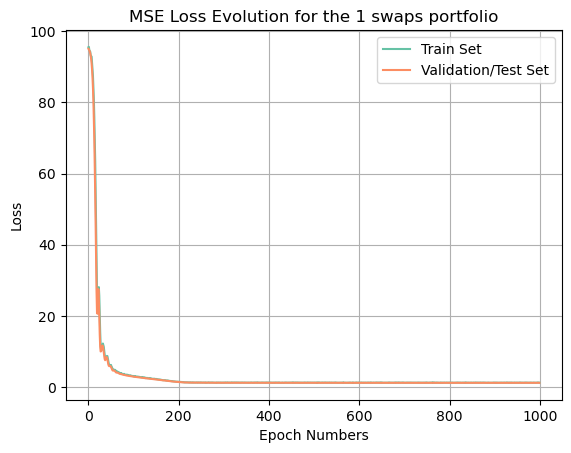

In [419]:
plt.plot(trainLoss,label="Train Set ")
plt.plot(testLoss,label="Validation/Test Set")
plt.legend()
plt.title("MSE Loss Evolution for the 1 swaps portfolio")
plt.xlabel("Epoch Numbers")
plt.ylabel("Loss")
plt.grid()
plt.savefig("5SwapsPortfolioLossError.png")

In [421]:
# Getting Some Metrics from now

MSETrain = trainLoss[-1].detach().numpy()
MSETest = testLoss[-1].detach().numpy()
MAETrain = MAETrainLoss[-1].detach().numpy()
MAETest = MAETestLoss[-1].detach().numpy()

Metrics = pd.DataFrame([MSETrain,MSETest,MAETrain,MAETest],index=["MSETrain","MSETest","MAETrain","MAETest"],columns=["Metrics"])

Metrics

,Metrics
MSETrain,1.220055
MSETest,1.180061
MAETrain,0.752931
MAETest,0.740112


In [ ]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.6
r0=0.015
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

<h3> 1 Swap Portfolio :  </h3>

In [312]:
# Getting Some Metrics from now

MSETrain = trainLoss[-1].detach().numpy()
MSETest = testLoss[-1].detach().numpy()
MAETrain = MAETrainLoss[-1].detach().numpy()
MAETest = MAETestLoss[-1].detach().numpy()

Metrics = pd.DataFrame([MSETrain,MSETest,MAETrain,MAETest],index=["MSETrain","MSETest","MAETrain","MAETest"],columns=["Metrics"])

Metrics

,Metrics
MSETrain,0.051206
MSETest,0.048375
MAETrain,0.150324
MAETest,0.146877


<h3> Making Some Predictions of DIM :  </h3>


In [431]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.6
r0=0.015
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [433]:
kappax = 0.10
kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= - 0.6
r0=0.015
NbrPaths=1000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [42:34<00:00, 25.54s/it]


MSE Error : 0.0016522505218016276


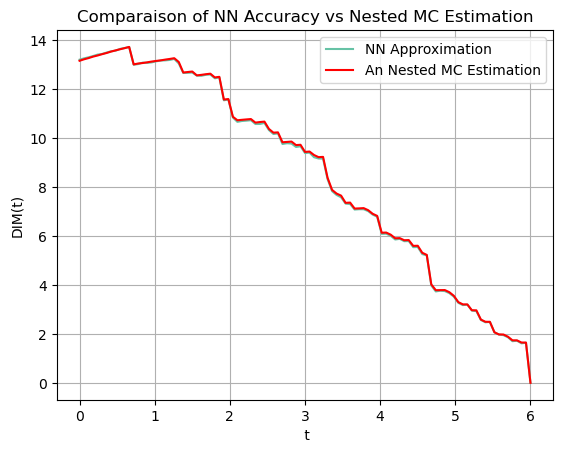

In [435]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC5Swapr0.015rho-0.6sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

In [455]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= -0.8
r0=0.01
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [457]:
kappax = 0.10
kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= - 0.8
r0=0.01
NbrPaths=1000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [45:19<00:00, 27.20s/it]


MSE Error : 0.00154825463449991


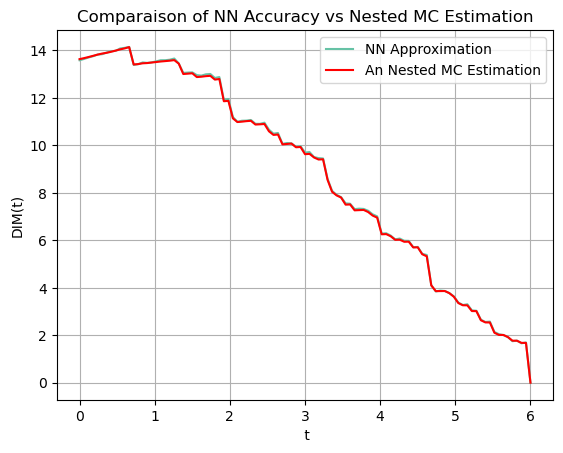

In [459]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC5Swapr0.01rho-0.8sigmaxsigmay0.02.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

In [134]:
time = np.linspace(0,6,100)


In [158]:
DIMNew[-1]=0

In [370]:
len(time[1:])

100

MSE Error : 0.05491047589188223


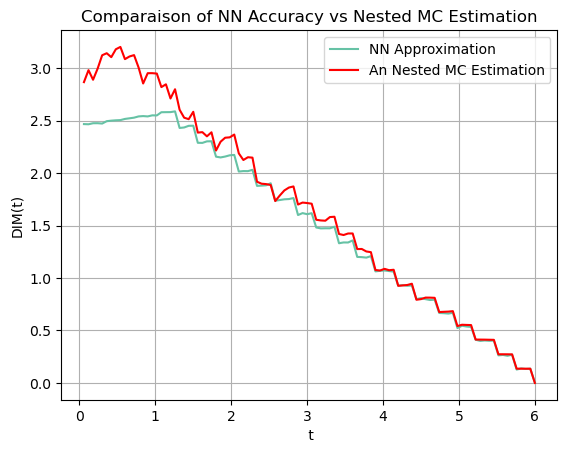

In [371]:
plt.plot(time[1:],y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time[1:],DIMNew,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMN5swapsvsNestedMCPortfolioOf5swapsr0.015rho-0.6sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew[1:])**2)))

<h3> One Swap Portfolio : </h3>

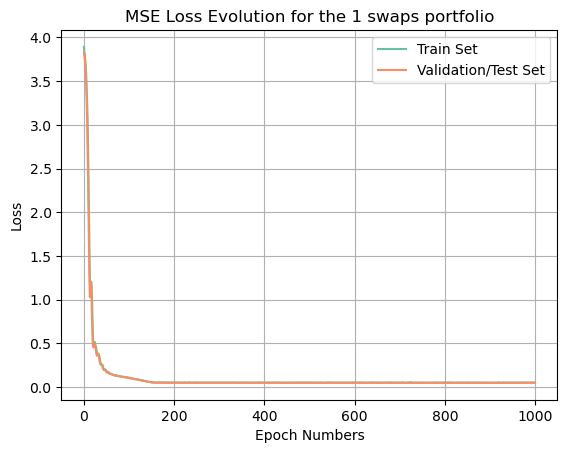

In [377]:
plt.plot(trainLoss,label="Train Set ")
plt.plot(testLoss,label="Validation/Test Set")
plt.legend()
plt.title("MSE Loss Evolution for the 1 swaps portfolio")
plt.xlabel("Epoch Numbers")
plt.ylabel("Loss")
plt.grid()
plt.savefig("1SwapsPortfolioLossError.png")

In [378]:
# Getting Some Metrics from now

MSETrain = trainLoss[-1].detach().numpy()
MSETest = testLoss[-1].detach().numpy()
MAETrain = MAETrainLoss[-1].detach().numpy()
MAETest = MAETestLoss[-1].detach().numpy()

Metrics = pd.DataFrame([MSETrain,MSETest,MAETrain,MAETest],index=["MSETrain","MSETest","MAETrain","MAETest"],columns=["Metrics"])

Metrics

,Metrics
MSETrain,0.049538
MSETest,0.047879
MAETrain,0.148430
MAETest,0.145334


In [379]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.6
r0=0.015
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [381]:
kappax = 0.10
kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= - 0.6
r0=0.015
NbrPaths=1000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [11:55<00:00,  7.09s/it]


MSE Error : 6.0176496244875936e-05


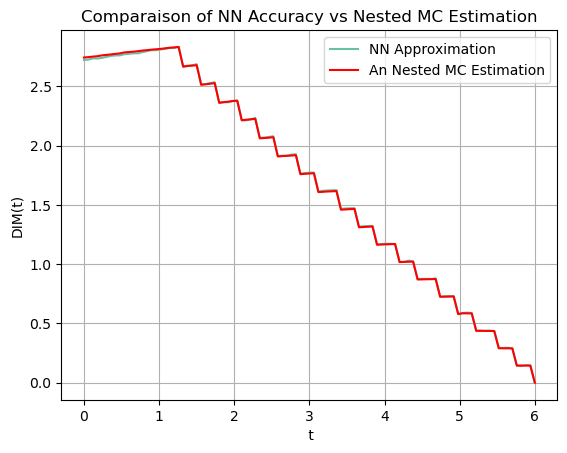

In [384]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC1Swapr0.015rho-0.6sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

In [387]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.8
r0=0.04
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [389]:
kappax = 0.10
kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= - 0.8
r0=0.04
NbrPaths=1000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [10:05<00:00,  6.00s/it]


MSE Error : 0.00010781401444296972


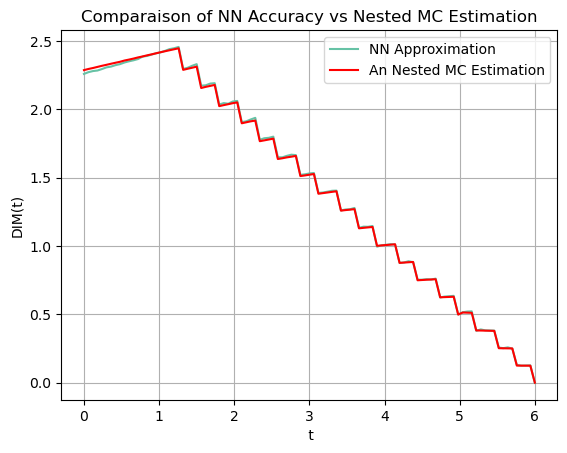

In [391]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC1Swapr0.04rho-0.8sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

In [393]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= -0.3
r0=0.03
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [395]:
kappax = 0.10
kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= - 0.3
r0=0.03
NbrPaths=1000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [10:13<00:00,  6.07s/it]


MSE Error : 6.282492097631044e-05


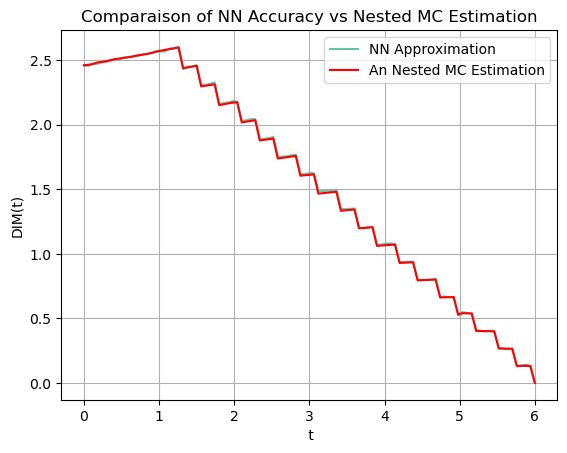

In [397]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC1Swapr0.03rho-0.3sigmaxsigmay0.02.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

In [399]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= 0
r0=0.01
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6,101)
y_predNN =net.forward(Xtensor)

In [402]:
kappax = 0.10
kappay = 0.12
sigmax=0.02
sigmay = 0.02
rho= 0
r0=0.01
NbrPaths=2000
IM,DIMNew2,ZCBArray,time = NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NbrPaths)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [20:47<00:00, 12.35s/it]


MSE Error : 0.00031957253950192204


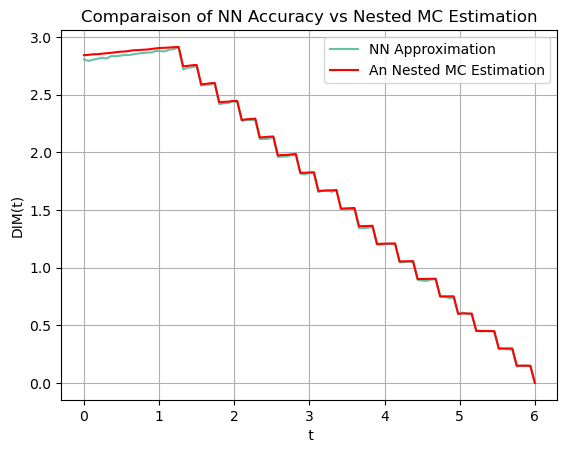

In [404]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,DIMNew2,label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMC1Swapr0.01rho0.0sigmaxsigmay0.02.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-DIMNew2)**2)))

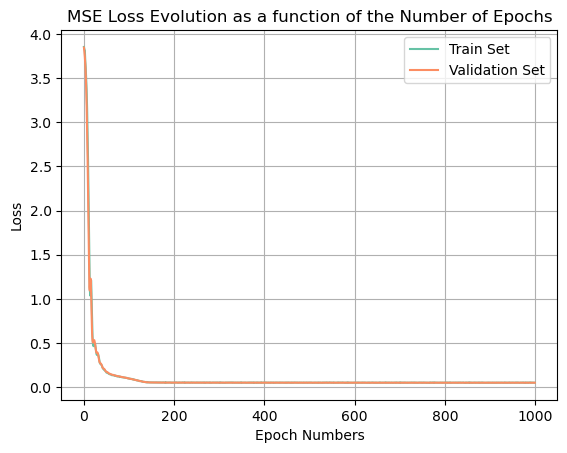

In [474]:
plt.plot(trainLoss,label="Train Set ")
plt.plot(testLoss,label="Validation/Test Set")
plt.legend()
plt.title("MSE Loss Evolution as a function of the Number of Epochs")
plt.xlabel("Epoch Numbers")
plt.ylabel("Loss")
plt.grid()


In [475]:
# Getting Some Metrics from now

MSETrain = trainLoss[-1].detach().numpy()
MSETest = testLoss[-1].detach().numpy()
MAETrain = MAETrainLoss[-1].detach().numpy()
MAETest = MAETestLoss[-1].detach().numpy()

Metrics = pd.DataFrame([MSETrain,MSETest,MAETrain,MAETest],index=["MSETrain","MSETest","MAETrain","MAETest"],columns=["Metrics"])

Metrics

,Metrics
MSETrain,0.051411
MSETest,0.051496
MAETrain,0.150844
MAETest,0.152072


<h3> Making Some Predictions of DIM :  </h3>

In [149]:
Kappax = 0.10
Kappay = 0.12
sigmax=0.015
sigmay = 0.015
rho= -0.6
r0=0.015
Xtensor = torch.tensor([Kappax,Kappay,sigmax,sigmay,rho,r0])
time = np.linspace(0,6+ 1/100,100)
y_predNN =net.forward(Xtensor)

In [152]:
y_predNN

array([0.        , 0.06070707, 0.12141414, 0.18212121, 0.24282828,
       0.30353535, 0.36424242, 0.42494949, 0.48565657, 0.54636364,
       0.60707071, 0.66777778, 0.72848485, 0.78919192, 0.84989899,
       0.91060606, 0.97131313, 1.0320202 , 1.09272727, 1.15343434,
       1.21414141, 1.27484848, 1.33555556, 1.39626263, 1.4569697 ,
       1.51767677, 1.57838384, 1.63909091, 1.69979798, 1.76050505,
       1.82121212, 1.88191919, 1.94262626, 2.00333333, 2.0640404 ,
       2.12474747, 2.18545455, 2.24616162, 2.30686869, 2.36757576,
       2.42828283, 2.4889899 , 2.54969697, 2.61040404, 2.67111111,
       2.73181818, 2.79252525, 2.85323232, 2.91393939, 2.97464646,
       3.03535354, 3.09606061, 3.15676768, 3.21747475, 3.27818182,
       3.33888889, 3.39959596, 3.46030303, 3.5210101 , 3.58171717,
       3.64242424, 3.70313131, 3.76383838, 3.82454545, 3.88525253,
       3.9459596 , 4.00666667, 4.06737374, 4.12808081, 4.18878788,
       4.24949495, 4.31020202, 4.37090909, 4.43161616, 4.49232

In [651]:
IM,GroundTruthDIMXtensor,ZCBArray,_ = NestedMCSimulationDIM(Kappax,Kappay,sigmax,sigmay,rho,r0,100)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:37<00:00,  1.04it/s]


NameError: name 'GroundTruthDIMXtensor' is not defined

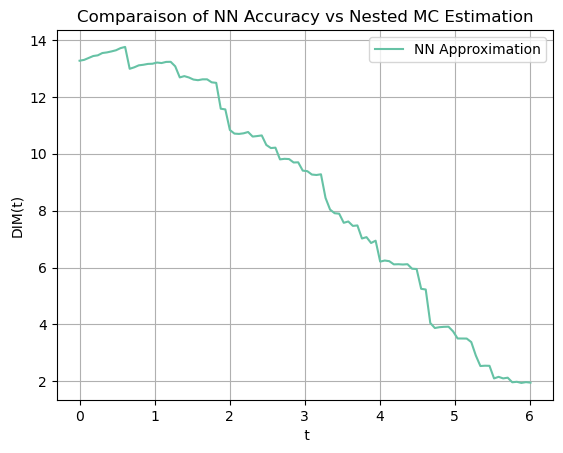

In [153]:
plt.plot(time[0:],y_predNN.detach().numpy(),label="NN Approximation")
#plt.plot(time,GroundTruthDIMXtensor[1:],label="An Nested MC Estimation",color="red")


# r_0 = 0.01 et $rho = -0.5 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMCr0.015rho-0.6sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

MSE Error : 5.176050008963225e-05


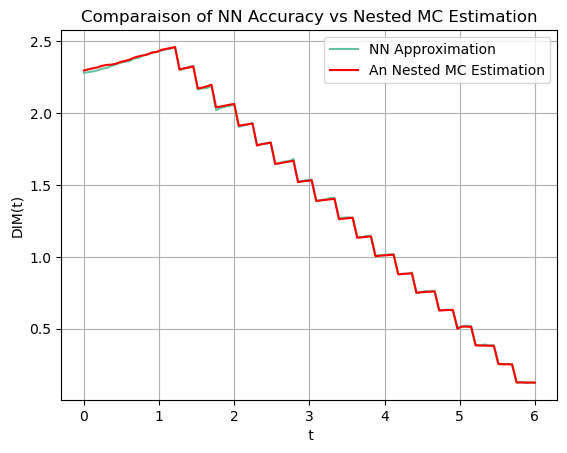

In [637]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,GroundTruthDIMXtensor[1:],label="An Nested MC Estimation",color="red")


# r_0 = 0.04 et $rho = - 0.3 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMCr0.04rho-0.8sigmaxsigmay0.015.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

MSE Error : 7.950299359657006e-05


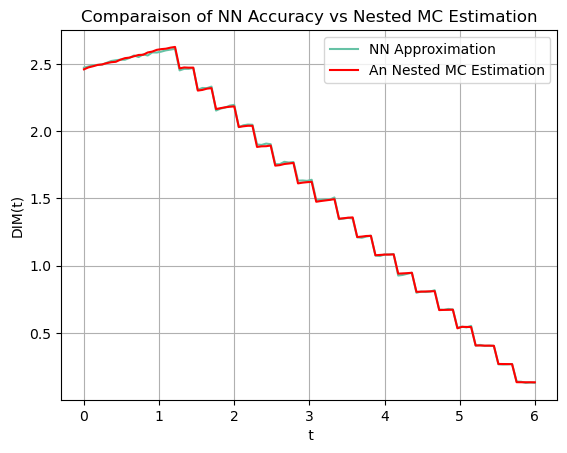

In [626]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,GroundTruthDIMXtensor[1:],label="An Nested MC Estimation",color="red")


# r_0 = 0.03 et $rho = - 0.3 , $sigma x = sigmay = 0.02$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" t")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()
plt.savefig("DIMNNvsNestedMCr0.03rho-0.3sigmaxsigmay0.02.png")

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

<h3>  Another Swap Characteristics : </h3>

In [ ]:
def NestedMCSimulationDIM(kappax,kappay,sigmax,sigmay,rho,r0,NoOfPaths):
    
    NoOfSteps = 100
    ISMMTenorsWeights={2/52 : 0.0109 , 1/12 : 0.0105 , 1/4 : 0.0090 , 1/2 : 0.0071 , 1 : 0.0066 , 2 : 0.0066
                       , 3: 0.0064 , 5 : 0.0060 , 10 : 0.0060 , 15 : 0.0061 ,20 : 0.0061 , 30 : 0.0067}
    Tenors = list(ISMMTenorsWeights.keys())
    Weights =list(ISMMTenorsWeights.values())
    P0T = lambda T: np.exp(-r0*T) # Initial Curve ZCB

    # Model Parameters
    
    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 6.0 # end date of the swap 
    n = 6   # number of payments between Ti and Tm
    dt = Tm / NoOfSteps
    
    
    
    IM = np.zeros([NoOfPaths,NoOfSteps + 1])
    ZCBArray= np.zeros([NoOfPaths,NoOfSteps + 1])
    DIM=np.zeros(NoOfSteps+1)
    notional  = 1000000.0 
 
    time, R,x,y = generate_G2_paths(NoOfPaths,NoOfSteps,Tm,P0T,kappax,kappay,sigmax,sigmay,rho)
    
    
    for i in tqdm(range(0,NoOfSteps+1)):
        current_t = time[i]
        for j in range(NoOfPaths):
            current_R , current_X,current_Y= R[j,i] ,x[j,i],y[j,i]
            sensitivity=np.zeros(len(Tenors)) # Sensitivity of Len Tenors
            YParams=[]
            for k in range(len(Tenors)):
                current_tenor = Tenors[k]
                if current_t==current_tenor :
                    YParams.append(0.0)
                else:
                    ZCB = G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,current_t,current_tenor,current_X,current_Y) # Calculation of
                    YParams.append((-np.log(ZCB)) / (current_tenor - current_t))
            
            # We will now interpolate the Yield Curve Function that we have
            V=G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti,Tm,n,P0T,kappax,kappay,sigmax,sigmay,rho,YParams)
            
            # Defining the G2_Swap Price Here
            for k in range(len(Tenors)):
                VShift=YParams.copy() # Copy of the Actual Yield Curve 
                VShift[k] = VShift[k] + 0.0001 # Shock to the k-th Yield
                NewSwapPrice = G2_SwapPriceInterpolated(CP,notional,K,current_t,Ti,Tm,n,P0T,kappax,kappay,sigmax,sigmay,rho,VShift)     # ReEvaluation of Instrument
                sensitivity[k] = NewSwapPrice - V # Sensitivity of k-th Yield
                
            for k,weight in enumerate(Weights):
                IM[j,i]+=weight * sensitivity[k]
                

            IM[j,i]=IM[j,i] *np.exp(-sum(R[j,:i+1])*dt) 
            ZCBArray[j,i]= np.exp(-sum(R[j,:i+1])*dt) 
            
        
    DIM=np.mean(IM,axis=0) # Computation of Dynamic Initial Margin
        
    return IM, DIM,ZCBArray,time
                
               
def MVACalculation(DIM):
    
    N = len(DIM)
    
    # Parameters Setting
    
    Tm=6
    # Parameters
    
    dt = Tm / N
    RecoveryB=0.4
    lambdaB= 0.0167
    spreadI= 0
    lambdaC= 0 
    
    f = lambda  t : ((1-RecoveryB)*lambdaB - spreadI)*np.exp(-(lambdaB+lambdaC)*t)
    
    MVA=0 # Margin Valuation Adjustment
    
    for i in range(0,N):
        current_t = i * T / N
        MVA += f(current_t) * DIM[i] * dt
        
    return MVA
    
                
                
                
                        

            
            
            
    

MSE Error : 0.00013840556611324068


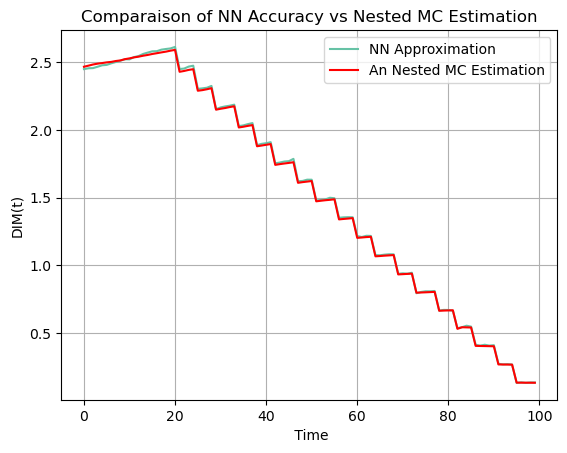

In [615]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,GroundTruthDIMXtensor[1:],label="An Nested MC Estimation",color="red")


# r_0 = 0.03 et $rho = - 0.9 , $sigma x = sigmay = 0.01$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

MSE Error : 8.972073102349712e-05


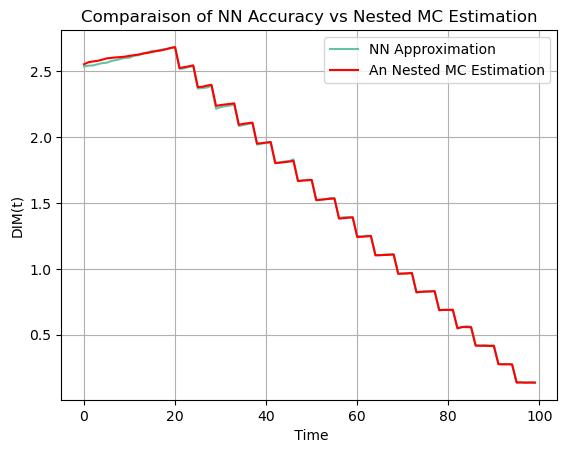

In [612]:
plt.plot(time,y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(time,GroundTruthDIMXtensor[1:],label="An Nested MC Estimation",color="red")


# r_0 = 0.025 et $rho = - 0.8 , $sigma x = sigmay = 0.0015$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

MSE Error : 0.0002532605707434069


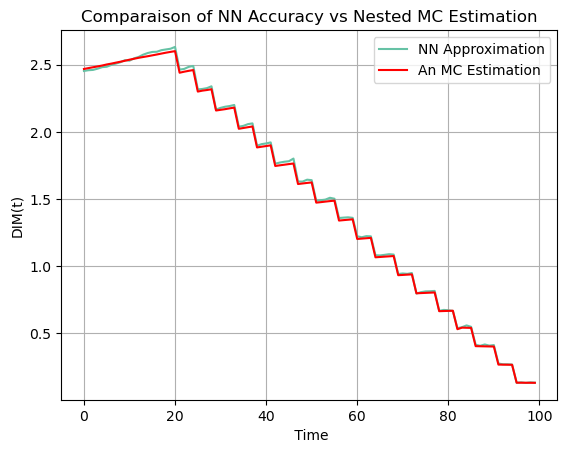

In [596]:
plt.plot(y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(GroundTruthDIMXtensor[1:],label="An MC Estimation",color="red")


# r_0 = 0.03 et $rho = -0.99 et $sigma_x = sigma_y = 0.2$
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

MSE Error : 0.0001369088246344746


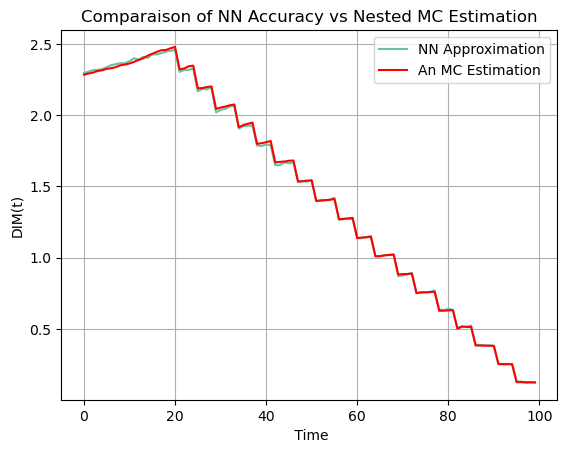

In [592]:
plt.plot(y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(GroundTruthDIMXtensor[1:],label="An MC Estimation",color="red")


# r_0 = 0.04
#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs Nested MC Estimation")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

print("MSE Error : " + str( np.mean((y_predNN.detach().numpy()-GroundTruthDIMXtensor[1:])**2)))

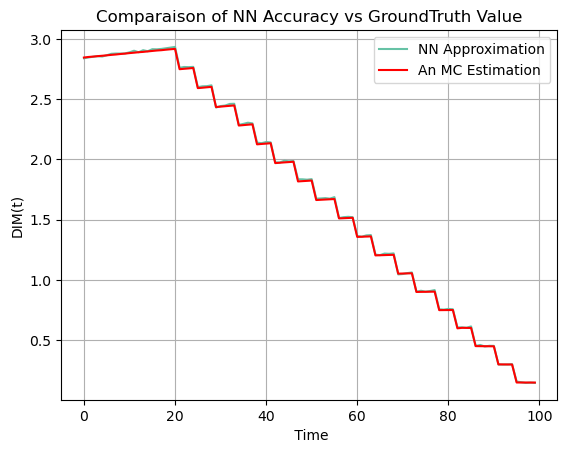

In [569]:
plt.plot(y_predNN.detach().numpy(),label="NN Approximation")
plt.plot(GroundTruthDIMXtensor[1:],label="An MC Estimation",color="red")


#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs GroundTruth Value")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

<h3> Plotting Some IM Strategies with $M_C = 1 Path$  : </h3>

In [341]:
DataParameters.describe()

,Kx,Ky,sigmax,sigmay,rho
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.071988,0.088813,0.015019,0.015021,-0.003325
std,0.027707,0.034171,0.005794,0.005774,0.577797
min,0.024001,0.029667,0.005000,0.005000,-0.998995
25%,0.047982,0.059303,0.009995,0.010034,-0.505281
50%,0.072056,0.088873,0.015030,0.015033,-0.006993
75%,0.095848,0.118150,0.020045,0.020013,0.500765
max,0.119997,0.148333,0.025000,0.025000,0.998974


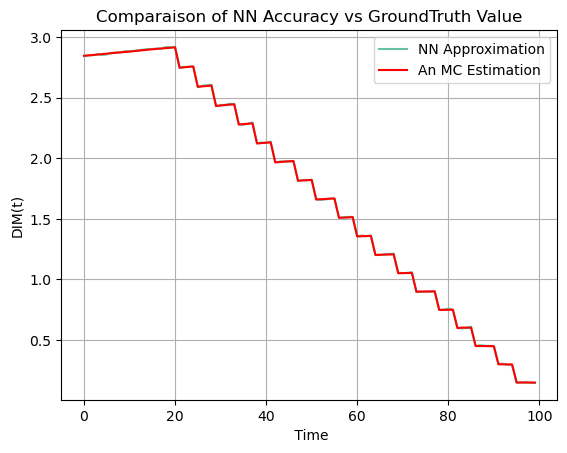

In [330]:
plt.plot(y_pred.detach().numpy(),label="NN Approximation")
plt.plot(GroundTruthDIM[1:],label="An MC Estimation",color="red")


#plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
#plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs GroundTruth Value")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

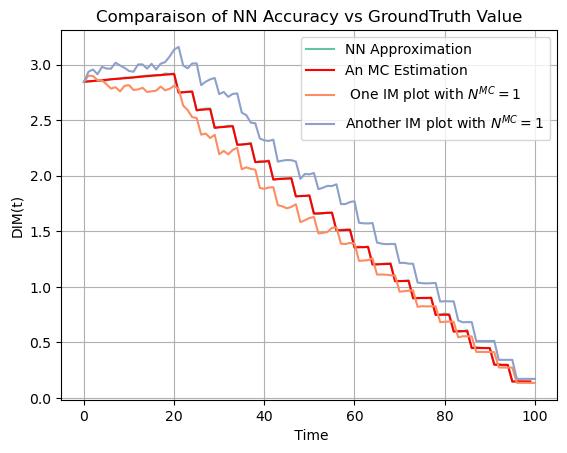

In [331]:
plt.plot(y_pred.detach().numpy(),label="NN Approximation")
plt.plot(GroundTruthDIM[1:],label="An MC Estimation",color="red")


plt.plot(DIM,label=" One IM plot with $N^{MC}=1 $ ")
plt.plot(DIM2,label="Another IM plot with $N^{MC}=1$ ")

plt.title("Comparaison of NN Accuracy vs GroundTruth Value")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.legend()
plt.grid()

<h3> Testing the code with other parameters :  </h3>



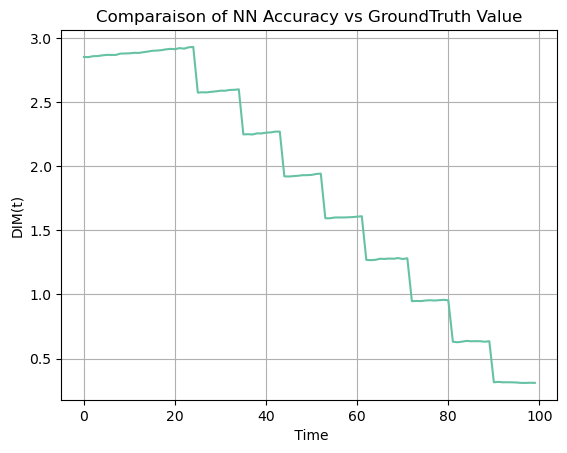

In [201]:
plt.plot(y_pred.detach().numpy(),label="NN Approximation")
#plt.plot(DIM,label="GroundTruth Value")
plt.title("Comparaison of NN Accuracy vs GroundTruth Value")
plt.xlabel(" Time")
plt.ylabel("DIM(t)")
plt.grid()

In [164]:
DIM2

array([2.84640598, 2.91606784, 2.97603867, 3.06277234, 3.07732712,
       3.02608884, 2.90039336, 2.79912713, 2.86016859, 2.86946289,
       3.00388122, 3.12344572, 3.29423204, 3.15173502, 2.93901838,
       2.84188107, 2.80309427, 2.81972296, 2.949422  , 3.03401749,
       3.03326935, 3.0304009 , 3.10252882, 3.07672186, 3.08610439,
       3.04105759, 2.71611525, 2.72884177, 2.77196716, 2.75364953,
       2.79247724, 2.73355831, 2.75120549, 2.72914767, 2.65127479,
       2.64611437, 2.18939213, 2.17275635, 2.15833498, 2.10408135,
       2.14207097, 2.1704252 , 2.12294129, 2.13216003, 2.16981541,
       1.80709489, 1.83554853, 1.82161542, 1.86064985, 1.85151468,
       1.84135708, 1.84639943, 1.83277864, 1.83826566, 1.53404606,
       1.5683379 , 1.55731566, 1.55144888, 1.56160753, 1.58900074,
       1.58795145, 1.59515978, 1.60245961, 1.28205316, 1.2869573 ,
       1.28475766, 1.28293915, 1.27732696, 1.2770036 , 1.29190598,
       1.30510477, 1.30695045, 1.30381244, 0.97745237, 0.98003

<h3> An experiment on a call option :  </h3>

In [3]:
def bsformula(cp, s, k, rf, t, v, div):
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """

        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
        delta = cp*st.norm.cdf(cp*d1)
        digital = cp * np.exp(-rf*t) * st.norm.cdf(cp*d2)
        vega  = s*np.sqrt(t)*st.norm.pdf(d1)
        gamma=st.norm.pdf(d1) / (s*v*np.sqrt(t))
        forward = cp*s*np.exp(-div*t) - (cp*k*np.exp(-rf*t))
        return optprice, delta, vega,gamma,digital,

In [14]:
def DIMCallOption(S0,r,K,T,sigma,NbrPaths,NbrSteps):
    
    dt = T / NbrSteps
    S=np.ones([NbrPaths,NbrSteps+1])
    optprice, delta, vega,gamma,digital=bsformula(1,S0,K,r,T,sigma,0)
    Delta=np.ones([NbrPaths,NbrSteps+1])*delta
    Gamma=np.ones([NbrPaths,NbrSteps+1])*gamma
    Vega = np.ones([NbrPaths,NbrSteps+1])*vega
    IM = np.ones([NbrPaths,NbrSteps + 1])
    DIM=np.zeros([NbrSteps+1])
    S[:,0]=S0
    IM[:,0]=Delta[:,0]+Vega[:,0]+Gamma[:,0]
    DIM[0]=np.mean(IM[:,0])
    for i in tqdm(range(1,NbrSteps+1)):
        current_t=float(i*dt)
        WT=np.random.normal(0,1,NbrPaths)*np.sqrt(dt)
        S[:,i]=S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT)
        for j in range(NbrPaths):
            optprice, delta, vega,gamma,digital=bsformula(1,S[j,i],K,r,T-current_t,sigma,0)
            Gamma[j,i]=gamma
            Delta[j,i]=delta
            Vega[j,i]=vega
            IM[j,i]=np.exp(-r* current_t)*(gamma+delta+vega)
        DIM[i]=np.mean(IM[:,i])
    
    return IM,DIM
            
            
    
        
    
    

In [29]:
S0=100
K=80
r=0.02
T=1
sigma=0.2
NbrPaths=1000
NbrSteps=20

IM,DIM3=DIMCallOption(S0,r,K,T,sigma,NbrPaths,NbrSteps)

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:24<00:01,  1.33s/it]C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_32248\266244046.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
C:\Users\samy.mekkaoui\AppData\Local\Temp\ipykernel_32248\266244046.py:19: RuntimeWarning: invalid value encountered in scalar divide
  gamma=st.norm.pdf(d1) / (s*v*np.sqrt(t))
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


In [16]:
time=np.linspace(0,T,len(DIM))

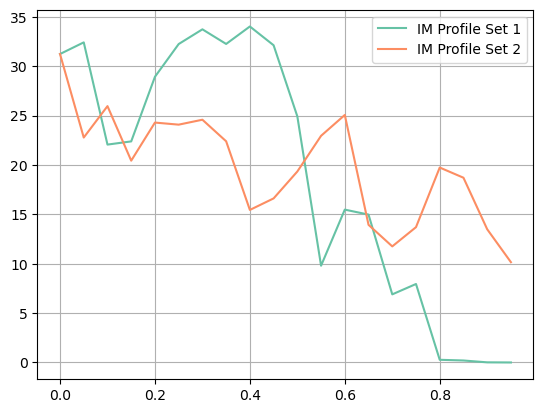

In [24]:
plt.plot(time,IM[1,:],label="IM Profile Set 1")
plt.plot(time,IM[2,:],label="IM Profile Set 2")
plt.legend()
plt.grid()

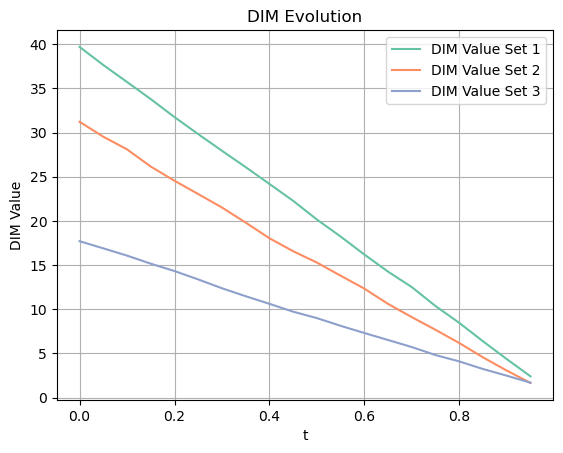

In [30]:
plt.plot(time,DIM,label= "DIM Value Set 1")
plt.plot(time,DIM2,label="DIM Value Set 2")
plt.plot(time,DIM3,label="DIM Value Set 3")

plt.legend()
plt.xlabel("t")
plt.ylabel("DIM Value")
plt.title("DIM Evolution")
plt.grid()